## `multi_autocorr`: An autocorrelation function for multiple trajectories of different lengths

For these tests, we will use a recent data set generated by Starwing Chen (https://github.com/starwingc) for the omega angles (the dihedral angle across an amide bond) for a peptoid trimer.

A set of 742 trajectories of three omega angles (in degrees) are stored with snapshots every 0.01 ns = 10 ps in the file `data/data.pkl`.

This file is too large to store in the repo, so we reduced it to 0/1 *BOOLEANS* representing 0=cis and 1=trans, in the file `data/all_cistrans.pkl`.

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import pickle

# Define a helper function to load and save pickles of lists of arrays

class Data:
    def __init__(self, array_list):
        self.array_list = array_list

    def save(self, filename):
        with open(filename, 'wb') as f:
            pickle.dump(self.array_list, f)

    @classmethod
    def load(cls, filename):
        with open(filename, 'rb') as f:
            array_list = pickle.load(f)
        return cls(array_list)

## Compute average and stddev over the 0=cis/1=trans trajectories 

In [2]:
all_cistrans = Data.load(f"data/all_cistrans.pkl").array_list 
# This a list of 742 (N_i, 3) np.arrays, where N_i is the size of the i^{th} trajectory
ntraj = len(all_cistrans)

# convert to floats for downstream operations
for i in range(ntraj):
    all_cistrans[i] = all_cistrans[i].astype(float)

# Find the longest traj
maxlength = max( [ len(all_cistrans[i]) for i in range(ntraj) ])
minlength = min( [ len(all_cistrans[i]) for i in range(ntraj) ])
ns_per_step = 0.01
print(f'minlength = {minlength} snapshots ({minlength*ns_per_step:.3f} ns)')
print(f'maxlength = {maxlength} snapshots ({maxlength*ns_per_step:.3f} ns)')

# Make an array to store all the trajectories
arr_cistrans = np.nan * np.ones( (ntraj, maxlength, 3) )

for i in range(ntraj):
    n = len(all_cistrans[i])
    arr_cistrans[i, 0:n, :] = all_cistrans[i]

arr_cistrans.shape

minlength = 1001 snapshots (10.010 ns)
maxlength = 142011 snapshots (1420.110 ns)


(742, 142011, 3)

In [3]:
# Compute the average over all trajectories for non-nan entries

n_included = np.sum(np.where(np.isnan(arr_cistrans[:,:,:]), 0, 1), axis=0)
print('n_included', n_included, 'n_included.shape', n_included.shape)

p_trans = np.nanmean(arr_cistrans, axis=0)
p_trans_std = ((np.nanvar(arr_cistrans, axis=0)) / (n_included-0.9999))**0.5    # 0.9999 ~ 1 designed to avoid dividing by zero

print('p_trans', p_trans)
print('p_trans_std', p_trans_std)


n_included [[742 742 742]
 [742 742 742]
 [742 742 742]
 ...
 [  1   1   1]
 [  1   1   1]
 [  1   1   1]] n_included.shape (142011, 3)
p_trans [[0.63342318 0.45552561 0.48921833]
 [0.63342318 0.45552561 0.48787062]
 [0.63342318 0.45552561 0.48787062]
 ...
 [0.         0.         1.        ]
 [0.         0.         1.        ]
 [0.         0.         1.        ]]
p_trans_std [[0.01770192 0.01829515 0.01836369]
 [0.01770192 0.01829515 0.01836255]
 [0.01770192 0.01829515 0.01836255]
 ...
 [0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]


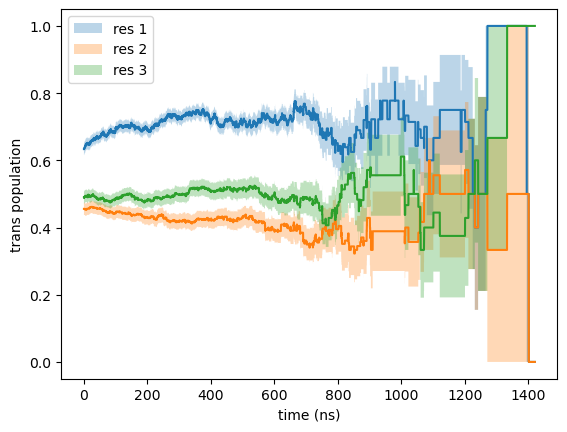

In [4]:
plt.figure()

ns_per_step = 0.01
time_in_ns = np.arange(maxlength)*ns_per_step

plt.plot(time_in_ns, p_trans) # all three residues
plt.fill_between(time_in_ns, (p_trans+p_trans_std)[:,0], (p_trans-p_trans_std)[:,0], alpha=0.3, lw=1, label='res 1') # all three residues
plt.fill_between(time_in_ns, (p_trans+p_trans_std)[:,1], (p_trans-p_trans_std)[:,1], alpha=0.3, lw=1, label='res 2') # all three residues
plt.fill_between(time_in_ns, (p_trans+p_trans_std)[:,2], (p_trans-p_trans_std)[:,2], alpha=0.3, lw=1, label='res 3') # all three residues
plt.xlabel('time (ns)')
plt.ylabel('trans population')
plt.legend(loc='best')

## The averages *seem* to converge, but let's calculate a `multi_autocorr` autocorrelation function...


In [6]:
from autocorrel import *

ntraj = len(all_cistrans)
all_cistrans_res0 = [ all_cistrans[i][:,0] for i in range(ntraj) ]
all_cistrans_res1 = [ all_cistrans[i][:,1] for i in range(ntraj) ]
all_cistrans_res2 = [ all_cistrans[i][:,2] for i in range(ntraj) ]

max_tau = 100000
stride = 1
1Q = multi_autocorr(all_cistrans_res0[0::stride], max_tau=max_tau)
result_res1 = multi_autocorr(all_cistrans_res1[0::stride], max_tau=max_tau)
result_res2 = multi_autocorr(all_cistrans_res2[0::stride], max_tau=max_tau)


  0%|                                                                                                  | 0/742 [00:00<?, ?it/s]

Analyzing traj 0 of 742 (55078 frames)...


  0%|                                                                                          | 1/742 [00:00<07:02,  1.75it/s]

Analyzing traj 1 of 742 (74022 frames)...


  1%|▋                                                                                         | 6/742 [00:01<02:45,  4.45it/s]

Analyzing traj 2 of 742 (9001 frames)...
Analyzing traj 3 of 742 (14001 frames)...
Analyzing traj 4 of 742 (1001 frames)...
Analyzing traj 5 of 742 (14001 frames)...
Analyzing traj 6 of 742 (61018 frames)...
Analyzing traj 7 of 742 (43011 frames)...


  1%|▉                                                                                         | 8/742 [00:02<04:23,  2.79it/s]

Analyzing traj 8 of 742 (81009 frames)...


  1%|█                                                                                         | 9/742 [00:03<06:00,  2.03it/s]

Analyzing traj 9 of 742 (9001 frames)...
Analyzing traj 10 of 742 (67260 frames)...


  1%|█▎                                                                                       | 11/742 [00:04<05:27,  2.23it/s]

Analyzing traj 11 of 742 (76145 frames)...


  2%|█▍                                                                                       | 12/742 [00:05<06:19,  1.92it/s]

Analyzing traj 12 of 742 (73027 frames)...


  2%|█▋                                                                                       | 14/742 [00:06<05:42,  2.13it/s]

Analyzing traj 13 of 742 (22060 frames)...
Analyzing traj 14 of 742 (54097 frames)...


  2%|█▊                                                                                       | 15/742 [00:06<05:46,  2.10it/s]

Analyzing traj 15 of 742 (70071 frames)...


  2%|█▉                                                                                       | 16/742 [00:07<06:34,  1.84it/s]

Analyzing traj 16 of 742 (74174 frames)...


  2%|██                                                                                       | 17/742 [00:08<08:04,  1.50it/s]

Analyzing traj 17 of 742 (34001 frames)...


  2%|██▏                                                                                      | 18/742 [00:08<06:42,  1.80it/s]

Analyzing traj 18 of 742 (15001 frames)...
Analyzing traj 19 of 742 (34001 frames)...


  3%|██▍                                                                                      | 20/742 [00:09<04:44,  2.54it/s]

Analyzing traj 20 of 742 (9001 frames)...
Analyzing traj 21 of 742 (67029 frames)...


  3%|██▋                                                                                      | 22/742 [00:10<04:45,  2.52it/s]

Analyzing traj 22 of 742 (79200 frames)...


  3%|██▊                                                                                      | 23/742 [00:11<06:25,  1.87it/s]

Analyzing traj 23 of 742 (9001 frames)...
Analyzing traj 24 of 742 (69011 frames)...


  3%|██▉                                                                                      | 25/742 [00:12<05:52,  2.03it/s]

Analyzing traj 25 of 742 (11001 frames)...
Analyzing traj 26 of 742 (51090 frames)...


  4%|███▏                                                                                     | 27/742 [00:12<05:00,  2.38it/s]

Analyzing traj 27 of 742 (42002 frames)...


  4%|███▎                                                                                     | 28/742 [00:12<04:54,  2.43it/s]

Analyzing traj 28 of 742 (79011 frames)...


  4%|███▍                                                                                     | 29/742 [00:13<06:19,  1.88it/s]

Analyzing traj 29 of 742 (12001 frames)...
Analyzing traj 30 of 742 (87268 frames)...


  4%|███▋                                                                                     | 31/742 [00:15<06:47,  1.75it/s]

Analyzing traj 31 of 742 (59095 frames)...


  4%|███▊                                                                                     | 32/742 [00:15<06:41,  1.77it/s]

Analyzing traj 32 of 742 (70009 frames)...


  4%|███▉                                                                                     | 33/742 [00:16<07:36,  1.55it/s]

Analyzing traj 33 of 742 (14034 frames)...
Analyzing traj 34 of 742 (46075 frames)...


  5%|████▏                                                                                    | 35/742 [00:17<05:48,  2.03it/s]

Analyzing traj 35 of 742 (15016 frames)...
Analyzing traj 36 of 742 (26010 frames)...


  5%|████▌                                                                                    | 38/742 [00:17<03:53,  3.02it/s]

Analyzing traj 37 of 742 (16001 frames)...
Analyzing traj 38 of 742 (20013 frames)...


  5%|████▋                                                                                    | 39/742 [00:17<03:23,  3.45it/s]

Analyzing traj 39 of 742 (59252 frames)...


  5%|████▊                                                                                    | 40/742 [00:18<04:26,  2.63it/s]

Analyzing traj 40 of 742 (40040 frames)...


  6%|████▉                                                                                    | 41/742 [00:18<04:16,  2.73it/s]

Analyzing traj 41 of 742 (44005 frames)...


  6%|█████                                                                                    | 42/742 [00:19<04:35,  2.54it/s]

Analyzing traj 42 of 742 (47047 frames)...


  6%|█████▏                                                                                   | 43/742 [00:19<04:40,  2.49it/s]

Analyzing traj 43 of 742 (50001 frames)...


  6%|█████▎                                                                                   | 44/742 [00:20<05:09,  2.26it/s]

Analyzing traj 44 of 742 (68031 frames)...


  6%|█████▌                                                                                   | 46/742 [00:21<04:45,  2.44it/s]

Analyzing traj 45 of 742 (22002 frames)...
Analyzing traj 46 of 742 (35388 frames)...


  6%|█████▋                                                                                   | 47/742 [00:21<04:03,  2.85it/s]

Analyzing traj 47 of 742 (32034 frames)...


  6%|█████▊                                                                                   | 48/742 [00:21<03:34,  3.23it/s]

Analyzing traj 48 of 742 (36001 frames)...


  7%|█████▉                                                                                   | 49/742 [00:21<03:13,  3.59it/s]

Analyzing traj 49 of 742 (40008 frames)...


  7%|█████▉                                                                                   | 50/742 [00:21<03:05,  3.72it/s]

Analyzing traj 50 of 742 (39062 frames)...


  7%|██████                                                                                   | 51/742 [00:22<03:11,  3.61it/s]

Analyzing traj 51 of 742 (44001 frames)...


  7%|██████▏                                                                                  | 52/742 [00:22<03:21,  3.43it/s]

Analyzing traj 52 of 742 (20005 frames)...
Analyzing traj 53 of 742 (69046 frames)...


  7%|██████▌                                                                                  | 55/742 [00:23<03:01,  3.79it/s]

Analyzing traj 54 of 742 (26007 frames)...
Analyzing traj 55 of 742 (61051 frames)...


  8%|██████▋                                                                                  | 56/742 [00:23<03:43,  3.07it/s]

Analyzing traj 56 of 742 (7001 frames)...
Analyzing traj 57 of 742 (70127 frames)...


  8%|███████▏                                                                                 | 60/742 [00:24<02:41,  4.23it/s]

Analyzing traj 58 of 742 (17001 frames)...
Analyzing traj 59 of 742 (17032 frames)...
Analyzing traj 60 of 742 (22019 frames)...


  8%|███████▍                                                                                 | 62/742 [00:25<02:16,  4.96it/s]

Analyzing traj 61 of 742 (30087 frames)...
Analyzing traj 62 of 742 (39001 frames)...


  8%|███████▌                                                                                 | 63/742 [00:25<02:24,  4.70it/s]

Analyzing traj 63 of 742 (16001 frames)...
Analyzing traj 64 of 742 (5001 frames)...
Analyzing traj 65 of 742 (8001 frames)...
Analyzing traj 66 of 742 (54069 frames)...


  9%|████████▎                                                                                | 69/742 [00:25<01:36,  6.96it/s]

Analyzing traj 67 of 742 (11027 frames)...
Analyzing traj 68 of 742 (25001 frames)...
Analyzing traj 69 of 742 (38034 frames)...


  9%|████████▍                                                                                | 70/742 [00:26<01:46,  6.29it/s]

Analyzing traj 70 of 742 (10116 frames)...
Analyzing traj 71 of 742 (44066 frames)...


 10%|████████▋                                                                                | 72/742 [00:26<01:56,  5.77it/s]

Analyzing traj 72 of 742 (46148 frames)...


 10%|████████▊                                                                                | 73/742 [00:26<02:21,  4.74it/s]

Analyzing traj 73 of 742 (71067 frames)...


 10%|████████▉                                                                                | 74/742 [00:27<03:23,  3.29it/s]

Analyzing traj 74 of 742 (16001 frames)...
Analyzing traj 75 of 742 (10001 frames)...
Analyzing traj 76 of 742 (8001 frames)...
Analyzing traj 77 of 742 (52048 frames)...


 11%|█████████▎                                                                               | 78/742 [00:28<02:19,  4.74it/s]

Analyzing traj 78 of 742 (10005 frames)...
Analyzing traj 79 of 742 (6009 frames)...
Analyzing traj 80 of 742 (30001 frames)...


 11%|█████████▋                                                                               | 81/742 [00:28<01:45,  6.25it/s]

Analyzing traj 81 of 742 (75001 frames)...


 11%|█████████▊                                                                               | 82/742 [00:29<02:36,  4.22it/s]

Analyzing traj 82 of 742 (37001 frames)...


 11%|█████████▉                                                                               | 83/742 [00:29<02:34,  4.28it/s]

Analyzing traj 83 of 742 (6028 frames)...
Analyzing traj 84 of 742 (62011 frames)...


 11%|██████████▏                                                                              | 85/742 [00:29<02:44,  4.01it/s]

Analyzing traj 85 of 742 (8001 frames)...
Analyzing traj 86 of 742 (73034 frames)...


 12%|██████████▍                                                                              | 87/742 [00:30<02:59,  3.65it/s]

Analyzing traj 87 of 742 (51032 frames)...


 12%|██████████▌                                                                              | 88/742 [00:30<03:12,  3.39it/s]

Analyzing traj 88 of 742 (57097 frames)...


 12%|██████████▋                                                                              | 89/742 [00:31<03:33,  3.06it/s]

Analyzing traj 89 of 742 (48002 frames)...


 12%|██████████▊                                                                              | 90/742 [00:31<03:39,  2.97it/s]

Analyzing traj 90 of 742 (61051 frames)...


 12%|██████████▉                                                                              | 91/742 [00:32<04:03,  2.67it/s]

Analyzing traj 91 of 742 (42107 frames)...


 13%|███████████▏                                                                             | 93/742 [00:32<03:06,  3.48it/s]

Analyzing traj 92 of 742 (24059 frames)...
Analyzing traj 93 of 742 (58009 frames)...


 13%|███████████▎                                                                             | 94/742 [00:33<03:43,  2.90it/s]

Analyzing traj 94 of 742 (79111 frames)...


 13%|███████████▍                                                                             | 95/742 [00:33<05:34,  1.94it/s]

Analyzing traj 95 of 742 (52018 frames)...


 13%|███████████▌                                                                             | 96/742 [00:34<05:28,  1.97it/s]

Analyzing traj 96 of 742 (5001 frames)...
Analyzing traj 97 of 742 (73213 frames)...


 13%|███████████▊                                                                             | 98/742 [00:35<04:55,  2.18it/s]

Analyzing traj 98 of 742 (73107 frames)...


 13%|███████████▊                                                                             | 99/742 [00:35<05:33,  1.93it/s]

Analyzing traj 99 of 742 (63123 frames)...


 14%|███████████▉                                                                            | 101/742 [00:36<04:37,  2.31it/s]

Analyzing traj 100 of 742 (26001 frames)...
Analyzing traj 101 of 742 (58068 frames)...


 14%|████████████▍                                                                           | 105/742 [00:37<02:47,  3.81it/s]

Analyzing traj 102 of 742 (12002 frames)...
Analyzing traj 103 of 742 (14021 frames)...
Analyzing traj 104 of 742 (16001 frames)...
Analyzing traj 105 of 742 (56115 frames)...


 14%|████████████▌                                                                           | 106/742 [00:38<03:11,  3.32it/s]

Analyzing traj 106 of 742 (65078 frames)...


 15%|████████████▊                                                                           | 108/742 [00:38<03:35,  2.94it/s]

Analyzing traj 107 of 742 (28097 frames)...
Analyzing traj 108 of 742 (12056 frames)...


 15%|█████████████▏                                                                          | 111/742 [00:39<02:01,  5.18it/s]

Analyzing traj 109 of 742 (6001 frames)...
Analyzing traj 110 of 742 (23058 frames)...
Analyzing traj 111 of 742 (65015 frames)...


 15%|█████████████▎                                                                          | 112/742 [00:39<03:05,  3.40it/s]

Analyzing traj 112 of 742 (39048 frames)...


 15%|█████████████▍                                                                          | 113/742 [00:40<03:10,  3.31it/s]

Analyzing traj 113 of 742 (47094 frames)...


 15%|█████████████▌                                                                          | 114/742 [00:40<03:18,  3.16it/s]

Analyzing traj 114 of 742 (63137 frames)...


 15%|█████████████▋                                                                          | 115/742 [00:41<04:14,  2.46it/s]

Analyzing traj 115 of 742 (66145 frames)...


 16%|█████████████▊                                                                          | 116/742 [00:41<05:19,  1.96it/s]

Analyzing traj 116 of 742 (52026 frames)...


 16%|█████████████▉                                                                          | 117/742 [00:42<05:02,  2.07it/s]

Analyzing traj 117 of 742 (73008 frames)...


 16%|██████████████                                                                          | 119/742 [00:43<04:42,  2.21it/s]

Analyzing traj 118 of 742 (23001 frames)...
Analyzing traj 119 of 742 (47051 frames)...


 16%|██████████████▍                                                                         | 122/742 [00:43<02:53,  3.58it/s]

Analyzing traj 120 of 742 (5015 frames)...
Analyzing traj 121 of 742 (23041 frames)...
Analyzing traj 122 of 742 (73116 frames)...


 17%|██████████████▌                                                                         | 123/742 [00:44<04:15,  2.43it/s]

Analyzing traj 123 of 742 (63051 frames)...


 17%|██████████████▋                                                                         | 124/742 [00:45<04:50,  2.13it/s]

Analyzing traj 124 of 742 (32029 frames)...


 17%|██████████████▊                                                                         | 125/742 [00:45<04:13,  2.43it/s]

Analyzing traj 125 of 742 (26001 frames)...


 17%|███████████████                                                                         | 127/742 [00:46<03:10,  3.23it/s]

Analyzing traj 126 of 742 (32022 frames)...
Analyzing traj 127 of 742 (25025 frames)...


 17%|███████████████▏                                                                        | 128/742 [00:46<03:00,  3.41it/s]

Analyzing traj 128 of 742 (72150 frames)...


 17%|███████████████▎                                                                        | 129/742 [00:47<04:50,  2.11it/s]

Analyzing traj 129 of 742 (32012 frames)...


 18%|███████████████▍                                                                        | 130/742 [00:47<04:45,  2.14it/s]

Analyzing traj 130 of 742 (47038 frames)...


 18%|███████████████▌                                                                        | 131/742 [00:48<04:59,  2.04it/s]

Analyzing traj 131 of 742 (45144 frames)...


 18%|███████████████▋                                                                        | 132/742 [00:48<04:35,  2.21it/s]

Analyzing traj 132 of 742 (18025 frames)...
Analyzing traj 133 of 742 (62067 frames)...


 18%|███████████████▉                                                                        | 134/742 [00:49<04:19,  2.34it/s]

Analyzing traj 134 of 742 (42041 frames)...


 18%|████████████████                                                                        | 135/742 [00:49<04:16,  2.37it/s]

Analyzing traj 135 of 742 (57011 frames)...


 18%|████████████████▏                                                                       | 136/742 [00:50<04:51,  2.08it/s]

Analyzing traj 136 of 742 (11001 frames)...
Analyzing traj 137 of 742 (10001 frames)...
Analyzing traj 138 of 742 (4001 frames)...
Analyzing traj 139 of 742 (59052 frames)...


 19%|████████████████▊                                                                       | 142/742 [00:51<02:12,  4.55it/s]

Analyzing traj 140 of 742 (16014 frames)...
Analyzing traj 141 of 742 (6001 frames)...
Analyzing traj 142 of 742 (72034 frames)...


 19%|████████████████▉                                                                       | 143/742 [00:52<03:30,  2.84it/s]

Analyzing traj 143 of 742 (75133 frames)...


 19%|█████████████████                                                                       | 144/742 [00:53<04:41,  2.13it/s]

Analyzing traj 144 of 742 (58007 frames)...


 20%|█████████████████▏                                                                      | 145/742 [00:53<05:07,  1.94it/s]

Analyzing traj 145 of 742 (43112 frames)...


 20%|█████████████████▎                                                                      | 146/742 [00:54<04:48,  2.06it/s]

Analyzing traj 146 of 742 (80175 frames)...


 20%|█████████████████▍                                                                      | 147/742 [00:55<06:02,  1.64it/s]

Analyzing traj 147 of 742 (67046 frames)...


 20%|█████████████████▌                                                                      | 148/742 [00:55<06:41,  1.48it/s]

Analyzing traj 148 of 742 (48073 frames)...


 20%|█████████████████▉                                                                      | 151/742 [00:56<03:41,  2.67it/s]

Analyzing traj 149 of 742 (6001 frames)...
Analyzing traj 150 of 742 (20068 frames)...
Analyzing traj 151 of 742 (67086 frames)...


 21%|██████████████████▎                                                                     | 154/742 [00:57<03:19,  2.94it/s]

Analyzing traj 152 of 742 (14001 frames)...
Analyzing traj 153 of 742 (22001 frames)...
Analyzing traj 154 of 742 (58076 frames)...


 21%|██████████████████▌                                                                     | 156/742 [00:58<03:00,  3.25it/s]

Analyzing traj 155 of 742 (20001 frames)...
Analyzing traj 156 of 742 (37051 frames)...


 21%|██████████████████▋                                                                     | 158/742 [00:58<02:20,  4.17it/s]

Analyzing traj 157 of 742 (22001 frames)...
Analyzing traj 158 of 742 (43010 frames)...


 21%|██████████████████▊                                                                     | 159/742 [00:58<02:27,  3.96it/s]

Analyzing traj 159 of 742 (20001 frames)...
Analyzing traj 160 of 742 (65013 frames)...


 22%|███████████████████                                                                     | 161/742 [00:59<02:50,  3.42it/s]

Analyzing traj 161 of 742 (79341 frames)...


 22%|███████████████████▎                                                                    | 163/742 [01:00<03:14,  2.98it/s]

Analyzing traj 162 of 742 (29048 frames)...
Analyzing traj 163 of 742 (83172 frames)...


 22%|███████████████████▍                                                                    | 164/742 [01:01<04:31,  2.13it/s]

Analyzing traj 164 of 742 (64033 frames)...


 22%|███████████████████▌                                                                    | 165/742 [01:02<05:09,  1.87it/s]

Analyzing traj 165 of 742 (51072 frames)...


 23%|███████████████████▊                                                                    | 167/742 [01:02<04:32,  2.11it/s]

Analyzing traj 166 of 742 (20041 frames)...
Analyzing traj 167 of 742 (53054 frames)...


 23%|███████████████████▉                                                                    | 168/742 [01:03<04:42,  2.03it/s]

Analyzing traj 168 of 742 (47152 frames)...


 23%|████████████████████▏                                                                   | 170/742 [01:04<03:35,  2.66it/s]

Analyzing traj 169 of 742 (23018 frames)...
Analyzing traj 170 of 742 (66044 frames)...


 23%|████████████████████▎                                                                   | 171/742 [01:04<04:33,  2.08it/s]

Analyzing traj 171 of 742 (36162 frames)...


 23%|████████████████████▍                                                                   | 172/742 [01:05<04:08,  2.29it/s]

Analyzing traj 172 of 742 (52313 frames)...


 23%|████████████████████▌                                                                   | 173/742 [01:06<05:57,  1.59it/s]

Analyzing traj 173 of 742 (39001 frames)...


 23%|████████████████████▋                                                                   | 174/742 [01:06<05:04,  1.86it/s]

Analyzing traj 174 of 742 (37001 frames)...


 24%|████████████████████▊                                                                   | 175/742 [01:06<04:23,  2.15it/s]

Analyzing traj 175 of 742 (44021 frames)...


 24%|████████████████████▊                                                                   | 176/742 [01:07<04:28,  2.11it/s]

Analyzing traj 176 of 742 (22038 frames)...


 24%|████████████████████▉                                                                   | 177/742 [01:07<04:13,  2.23it/s]

Analyzing traj 177 of 742 (72009 frames)...


 24%|█████████████████████                                                                   | 178/742 [01:08<05:15,  1.79it/s]

Analyzing traj 178 of 742 (57095 frames)...


 24%|█████████████████████▏                                                                  | 179/742 [01:09<05:07,  1.83it/s]

Analyzing traj 179 of 742 (63140 frames)...


 24%|█████████████████████▍                                                                  | 181/742 [01:09<04:02,  2.31it/s]

Analyzing traj 180 of 742 (34031 frames)...
Analyzing traj 181 of 742 (30001 frames)...


 25%|█████████████████████▌                                                                  | 182/742 [01:09<03:17,  2.84it/s]

Analyzing traj 182 of 742 (6001 frames)...
Analyzing traj 183 of 742 (10001 frames)...
Analyzing traj 184 of 742 (7001 frames)...
Analyzing traj 185 of 742 (60085 frames)...


 25%|██████████████████████                                                                  | 186/742 [01:10<01:56,  4.76it/s]

Analyzing traj 186 of 742 (112064 frames)...


 25%|██████████████████████▏                                                                 | 187/742 [01:11<03:51,  2.40it/s]

Analyzing traj 187 of 742 (140074 frames)...


 25%|██████████████████████▍                                                                 | 189/742 [01:13<05:33,  1.66it/s]

Analyzing traj 188 of 742 (29035 frames)...
Analyzing traj 189 of 742 (51091 frames)...


 26%|██████████████████████▌                                                                 | 190/742 [01:14<04:59,  1.84it/s]

Analyzing traj 190 of 742 (12001 frames)...
Analyzing traj 191 of 742 (59020 frames)...


 26%|██████████████████████▊                                                                 | 192/742 [01:14<03:50,  2.38it/s]

Analyzing traj 192 of 742 (120006 frames)...


 26%|██████████████████████▉                                                                 | 193/742 [01:16<05:59,  1.53it/s]

Analyzing traj 193 of 742 (17090 frames)...
Analyzing traj 194 of 742 (70047 frames)...


 26%|███████████████████████▏                                                                | 195/742 [01:16<04:50,  1.88it/s]

Analyzing traj 195 of 742 (82161 frames)...


 26%|███████████████████████▏                                                                | 196/742 [01:17<05:57,  1.53it/s]

Analyzing traj 196 of 742 (45096 frames)...


 27%|███████████████████████▎                                                                | 197/742 [01:18<05:11,  1.75it/s]

Analyzing traj 197 of 742 (110033 frames)...


 27%|███████████████████████▍                                                                | 198/742 [01:19<06:44,  1.34it/s]

Analyzing traj 198 of 742 (49003 frames)...


 27%|███████████████████████▌                                                                | 199/742 [01:19<05:48,  1.56it/s]

Analyzing traj 199 of 742 (62098 frames)...


 27%|███████████████████████▋                                                                | 200/742 [01:20<05:28,  1.65it/s]

Analyzing traj 200 of 742 (46026 frames)...


 27%|███████████████████████▊                                                                | 201/742 [01:20<04:43,  1.91it/s]

Analyzing traj 201 of 742 (107119 frames)...


 27%|███████████████████████▉                                                                | 202/742 [01:21<06:29,  1.39it/s]

Analyzing traj 202 of 742 (69036 frames)...


 28%|████████████████████████▍                                                               | 206/742 [01:22<02:59,  2.98it/s]

Analyzing traj 203 of 742 (15008 frames)...
Analyzing traj 204 of 742 (4045 frames)...
Analyzing traj 205 of 742 (25001 frames)...
Analyzing traj 206 of 742 (60098 frames)...


 28%|████████████████████████▌                                                               | 207/742 [01:23<03:14,  2.74it/s]

Analyzing traj 207 of 742 (53001 frames)...


 28%|████████████████████████▉                                                               | 210/742 [01:23<02:17,  3.87it/s]

Analyzing traj 208 of 742 (8001 frames)...
Analyzing traj 209 of 742 (31043 frames)...
Analyzing traj 210 of 742 (25001 frames)...


 28%|█████████████████████████                                                               | 211/742 [01:23<02:03,  4.30it/s]

Analyzing traj 211 of 742 (36001 frames)...


 29%|█████████████████████████▏                                                              | 212/742 [01:24<02:00,  4.41it/s]

Analyzing traj 212 of 742 (17034 frames)...
Analyzing traj 213 of 742 (57244 frames)...


 29%|█████████████████████████▍                                                              | 214/742 [01:24<02:04,  4.23it/s]

Analyzing traj 214 of 742 (57021 frames)...


 29%|█████████████████████████▍                                                              | 215/742 [01:24<02:28,  3.56it/s]

Analyzing traj 215 of 742 (11001 frames)...
Analyzing traj 216 of 742 (42022 frames)...


 29%|█████████████████████████▋                                                              | 217/742 [01:25<02:00,  4.34it/s]

Analyzing traj 217 of 742 (101171 frames)...


 29%|█████████████████████████▊                                                              | 218/742 [01:26<03:39,  2.39it/s]

Analyzing traj 218 of 742 (9001 frames)...
Analyzing traj 219 of 742 (81111 frames)...


 30%|██████████████████████████                                                              | 220/742 [01:27<03:32,  2.45it/s]

Analyzing traj 220 of 742 (53111 frames)...


 30%|██████████████████████████▏                                                             | 221/742 [01:27<03:33,  2.44it/s]

Analyzing traj 221 of 742 (43071 frames)...


 30%|██████████████████████████▎                                                             | 222/742 [01:28<03:46,  2.30it/s]

Analyzing traj 222 of 742 (71072 frames)...


 30%|██████████████████████████▍                                                             | 223/742 [01:28<04:08,  2.09it/s]

Analyzing traj 223 of 742 (39086 frames)...


 30%|██████████████████████████▌                                                             | 224/742 [01:28<03:36,  2.39it/s]

Analyzing traj 224 of 742 (68026 frames)...


 30%|██████████████████████████▊                                                             | 226/742 [01:29<03:14,  2.65it/s]

Analyzing traj 225 of 742 (31001 frames)...
Analyzing traj 226 of 742 (31001 frames)...


 31%|██████████████████████████▉                                                             | 227/742 [01:29<02:45,  3.11it/s]

Analyzing traj 227 of 742 (69175 frames)...


 31%|███████████████████████████                                                             | 228/742 [01:30<03:26,  2.49it/s]

Analyzing traj 228 of 742 (39001 frames)...


 31%|███████████████████████████▏                                                            | 229/742 [01:30<03:03,  2.80it/s]

Analyzing traj 229 of 742 (8001 frames)...
Analyzing traj 230 of 742 (50035 frames)...


 31%|███████████████████████████▍                                                            | 231/742 [01:31<02:22,  3.60it/s]

Analyzing traj 231 of 742 (65056 frames)...


 31%|███████████████████████████▌                                                            | 232/742 [01:31<02:54,  2.92it/s]

Analyzing traj 232 of 742 (45052 frames)...


 32%|███████████████████████████▊                                                            | 234/742 [01:32<02:29,  3.40it/s]

Analyzing traj 233 of 742 (33033 frames)...
Analyzing traj 234 of 742 (13001 frames)...
Analyzing traj 235 of 742 (61062 frames)...


 32%|███████████████████████████▉                                                            | 236/742 [01:32<02:21,  3.58it/s]

Analyzing traj 236 of 742 (6001 frames)...
Analyzing traj 237 of 742 (34001 frames)...


 32%|████████████████████████████▏                                                           | 238/742 [01:32<01:46,  4.72it/s]

Analyzing traj 238 of 742 (37001 frames)...


 32%|████████████████████████████▎                                                           | 239/742 [01:33<01:48,  4.64it/s]

Analyzing traj 239 of 742 (64033 frames)...


 32%|████████████████████████████▍                                                           | 240/742 [01:33<02:23,  3.49it/s]

Analyzing traj 240 of 742 (75076 frames)...


 32%|████████████████████████████▌                                                           | 241/742 [01:34<03:12,  2.61it/s]

Analyzing traj 241 of 742 (16001 frames)...
Analyzing traj 242 of 742 (44003 frames)...


 33%|████████████████████████████▊                                                           | 243/742 [01:34<02:28,  3.37it/s]

Analyzing traj 243 of 742 (62133 frames)...


 33%|████████████████████████████▉                                                           | 244/742 [01:35<02:50,  2.91it/s]

Analyzing traj 244 of 742 (66010 frames)...


 33%|█████████████████████████████                                                           | 245/742 [01:35<03:15,  2.55it/s]

Analyzing traj 245 of 742 (40029 frames)...


 33%|█████████████████████████████▏                                                          | 246/742 [01:35<03:00,  2.75it/s]

Analyzing traj 246 of 742 (15012 frames)...
Analyzing traj 247 of 742 (12031 frames)...
Analyzing traj 248 of 742 (53053 frames)...


 34%|█████████████████████████████▌                                                          | 249/742 [01:36<02:06,  3.90it/s]

Analyzing traj 249 of 742 (74014 frames)...


 34%|█████████████████████████████▋                                                          | 250/742 [01:37<02:46,  2.96it/s]

Analyzing traj 250 of 742 (44017 frames)...


 34%|█████████████████████████████▊                                                          | 251/742 [01:37<02:43,  3.01it/s]

Analyzing traj 251 of 742 (64001 frames)...


 34%|██████████████████████████████                                                          | 253/742 [01:38<02:44,  2.98it/s]

Analyzing traj 252 of 742 (28001 frames)...
Analyzing traj 253 of 742 (88050 frames)...


 35%|██████████████████████████████▎                                                         | 256/742 [01:39<02:23,  3.40it/s]

Analyzing traj 254 of 742 (19011 frames)...
Analyzing traj 255 of 742 (11001 frames)...
Analyzing traj 256 of 742 (68002 frames)...


 35%|██████████████████████████████▍                                                         | 257/742 [01:39<02:54,  2.79it/s]

Analyzing traj 257 of 742 (58100 frames)...


 35%|██████████████████████████████▌                                                         | 258/742 [01:40<03:04,  2.62it/s]

Analyzing traj 258 of 742 (44012 frames)...


 35%|██████████████████████████████▋                                                         | 259/742 [01:40<02:53,  2.79it/s]

Analyzing traj 259 of 742 (70006 frames)...


 35%|██████████████████████████████▊                                                         | 260/742 [01:41<03:25,  2.35it/s]

Analyzing traj 260 of 742 (42064 frames)...


 35%|██████████████████████████████▉                                                         | 261/742 [01:41<03:04,  2.61it/s]

Analyzing traj 261 of 742 (68063 frames)...


 35%|███████████████████████████████                                                         | 262/742 [01:41<03:31,  2.27it/s]

Analyzing traj 262 of 742 (14001 frames)...
Analyzing traj 263 of 742 (10095 frames)...
Analyzing traj 264 of 742 (67001 frames)...


 36%|███████████████████████████████▋                                                        | 267/742 [01:42<01:49,  4.33it/s]

Analyzing traj 265 of 742 (18001 frames)...
Analyzing traj 266 of 742 (19039 frames)...
Analyzing traj 267 of 742 (41013 frames)...


 36%|███████████████████████████████▉                                                        | 269/742 [01:43<01:47,  4.41it/s]

Analyzing traj 268 of 742 (33049 frames)...
Analyzing traj 269 of 742 (46071 frames)...


 36%|████████████████████████████████                                                        | 270/742 [01:43<01:57,  4.03it/s]

Analyzing traj 270 of 742 (41001 frames)...


 37%|████████████████████████████████▏                                                       | 271/742 [01:43<01:59,  3.94it/s]

Analyzing traj 271 of 742 (59058 frames)...


 37%|████████████████████████████████▎                                                       | 272/742 [01:44<02:33,  3.05it/s]

Analyzing traj 272 of 742 (37001 frames)...


 37%|████████████████████████████████▍                                                       | 273/742 [01:44<02:20,  3.34it/s]

Analyzing traj 273 of 742 (14001 frames)...
Analyzing traj 274 of 742 (43001 frames)...


 37%|████████████████████████████████▌                                                       | 275/742 [01:44<01:53,  4.12it/s]

Analyzing traj 275 of 742 (6001 frames)...
Analyzing traj 276 of 742 (45022 frames)...


 37%|████████████████████████████████▊                                                       | 277/742 [01:45<01:37,  4.78it/s]

Analyzing traj 277 of 742 (56001 frames)...


 37%|████████████████████████████████▉                                                       | 278/742 [01:45<02:06,  3.67it/s]

Analyzing traj 278 of 742 (78001 frames)...


 38%|█████████████████████████████████                                                       | 279/742 [01:46<02:58,  2.59it/s]

Analyzing traj 279 of 742 (44032 frames)...


 38%|█████████████████████████████████▏                                                      | 280/742 [01:46<02:48,  2.75it/s]

Analyzing traj 280 of 742 (1001 frames)...
Analyzing traj 281 of 742 (12047 frames)...
Analyzing traj 282 of 742 (15001 frames)...
Analyzing traj 283 of 742 (60023 frames)...


 38%|█████████████████████████████████▋                                                      | 284/742 [01:47<01:47,  4.26it/s]

Analyzing traj 284 of 742 (49061 frames)...


 39%|██████████████████████████████████                                                      | 287/742 [01:47<01:33,  4.89it/s]

Analyzing traj 285 of 742 (5001 frames)...
Analyzing traj 286 of 742 (22001 frames)...
Analyzing traj 287 of 742 (53075 frames)...


 39%|██████████████████████████████████▏                                                     | 288/742 [01:48<01:49,  4.16it/s]

Analyzing traj 288 of 742 (90374 frames)...


 39%|██████████████████████████████████▎                                                     | 289/742 [01:49<02:52,  2.62it/s]

Analyzing traj 289 of 742 (84045 frames)...


 39%|██████████████████████████████████▍                                                     | 290/742 [01:50<03:47,  1.99it/s]

Analyzing traj 290 of 742 (101051 frames)...


 39%|██████████████████████████████████▌                                                     | 291/742 [01:51<04:51,  1.54it/s]

Analyzing traj 291 of 742 (87013 frames)...


 39%|██████████████████████████████████▋                                                     | 293/742 [01:52<04:10,  1.79it/s]

Analyzing traj 292 of 742 (32128 frames)...
Analyzing traj 293 of 742 (71001 frames)...


 40%|██████████████████████████████████▊                                                     | 294/742 [01:52<04:17,  1.74it/s]

Analyzing traj 294 of 742 (65042 frames)...


 40%|██████████████████████████████████▉                                                     | 295/742 [01:53<04:12,  1.77it/s]

Analyzing traj 295 of 742 (11001 frames)...
Analyzing traj 296 of 742 (64075 frames)...


 40%|███████████████████████████████████▏                                                    | 297/742 [01:53<03:14,  2.29it/s]

Analyzing traj 297 of 742 (58007 frames)...


 40%|███████████████████████████████████▎                                                    | 298/742 [01:54<03:15,  2.28it/s]

Analyzing traj 298 of 742 (69094 frames)...


 40%|███████████████████████████████████▍                                                    | 299/742 [01:54<03:30,  2.10it/s]

Analyzing traj 299 of 742 (3001 frames)...
Analyzing traj 300 of 742 (47047 frames)...


 41%|███████████████████████████████████▋                                                    | 301/742 [01:55<02:32,  2.89it/s]

Analyzing traj 301 of 742 (11002 frames)...
Analyzing traj 302 of 742 (6003 frames)...
Analyzing traj 303 of 742 (12010 frames)...
Analyzing traj 304 of 742 (58055 frames)...


 41%|████████████████████████████████████▍                                                   | 307/742 [01:55<01:19,  5.49it/s]

Analyzing traj 305 of 742 (10001 frames)...
Analyzing traj 306 of 742 (21113 frames)...
Analyzing traj 307 of 742 (14001 frames)...
Analyzing traj 308 of 742 (16001 frames)...


 42%|████████████████████████████████████▋                                                   | 309/742 [01:55<01:03,  6.80it/s]

Analyzing traj 309 of 742 (12001 frames)...
Analyzing traj 310 of 742 (42020 frames)...


 42%|█████████████████████████████████████                                                   | 312/742 [01:56<01:06,  6.51it/s]

Analyzing traj 311 of 742 (32049 frames)...
Analyzing traj 312 of 742 (43024 frames)...


 42%|█████████████████████████████████████                                                   | 313/742 [01:56<01:16,  5.58it/s]

Analyzing traj 313 of 742 (13001 frames)...
Analyzing traj 314 of 742 (61092 frames)...


 42%|█████████████████████████████████████▎                                                  | 315/742 [01:57<01:30,  4.72it/s]

Analyzing traj 315 of 742 (21001 frames)...
Analyzing traj 316 of 742 (62041 frames)...


 43%|█████████████████████████████████████▌                                                  | 317/742 [01:57<01:42,  4.13it/s]

Analyzing traj 317 of 742 (75014 frames)...


 43%|█████████████████████████████████████▋                                                  | 318/742 [01:58<02:18,  3.07it/s]

Analyzing traj 318 of 742 (78204 frames)...


 43%|█████████████████████████████████████▊                                                  | 319/742 [01:59<03:01,  2.33it/s]

Analyzing traj 319 of 742 (48108 frames)...


 43%|█████████████████████████████████████▉                                                  | 320/742 [01:59<02:56,  2.39it/s]

Analyzing traj 320 of 742 (50006 frames)...


 43%|██████████████████████████████████████                                                  | 321/742 [02:00<02:50,  2.47it/s]

Analyzing traj 321 of 742 (47049 frames)...


 43%|██████████████████████████████████████▏                                                 | 322/742 [02:00<02:41,  2.60it/s]

Analyzing traj 322 of 742 (64050 frames)...


 44%|██████████████████████████████████████▍                                                 | 324/742 [02:01<02:24,  2.90it/s]

Analyzing traj 323 of 742 (28001 frames)...
Analyzing traj 324 of 742 (16001 frames)...
Analyzing traj 325 of 742 (12001 frames)...
Analyzing traj 326 of 742 (61001 frames)...


 44%|██████████████████████████████████████▊                                                 | 327/742 [02:01<01:48,  3.82it/s]

Analyzing traj 327 of 742 (33074 frames)...


 44%|██████████████████████████████████████▉                                                 | 328/742 [02:01<01:50,  3.76it/s]

Analyzing traj 328 of 742 (56007 frames)...


 44%|███████████████████████████████████████▏                                                | 330/742 [02:02<01:51,  3.68it/s]

Analyzing traj 329 of 742 (30023 frames)...
Analyzing traj 330 of 742 (47002 frames)...


 45%|███████████████████████████████████████▎                                                | 331/742 [02:02<01:56,  3.52it/s]

Analyzing traj 331 of 742 (17001 frames)...
Analyzing traj 332 of 742 (28081 frames)...


 45%|███████████████████████████████████████▍                                                | 333/742 [02:03<01:24,  4.82it/s]

Analyzing traj 333 of 742 (79062 frames)...


 45%|███████████████████████████████████████▌                                                | 334/742 [02:03<02:16,  2.99it/s]

Analyzing traj 334 of 742 (16001 frames)...
Analyzing traj 335 of 742 (40079 frames)...


 45%|███████████████████████████████████████▊                                                | 336/742 [02:04<01:47,  3.78it/s]

Analyzing traj 336 of 742 (47219 frames)...


 45%|███████████████████████████████████████▉                                                | 337/742 [02:04<01:52,  3.59it/s]

Analyzing traj 337 of 742 (75015 frames)...


 46%|████████████████████████████████████████                                                | 338/742 [02:05<02:30,  2.68it/s]

Analyzing traj 338 of 742 (62064 frames)...


 46%|████████████████████████████████████████▏                                               | 339/742 [02:05<02:43,  2.47it/s]

Analyzing traj 339 of 742 (12001 frames)...
Analyzing traj 340 of 742 (66157 frames)...


 46%|████████████████████████████████████████▍                                               | 341/742 [02:06<02:23,  2.80it/s]

Analyzing traj 341 of 742 (66121 frames)...


 46%|████████████████████████████████████████▋                                               | 343/742 [02:06<02:11,  3.04it/s]

Analyzing traj 342 of 742 (22046 frames)...
Analyzing traj 343 of 742 (16048 frames)...
Analyzing traj 344 of 742 (52117 frames)...


 46%|████████████████████████████████████████▉                                               | 345/742 [02:07<01:53,  3.50it/s]

Analyzing traj 345 of 742 (10001 frames)...
Analyzing traj 346 of 742 (133245 frames)...


 47%|█████████████████████████████████████████▏                                              | 347/742 [02:09<03:24,  1.93it/s]

Analyzing traj 347 of 742 (107081 frames)...


 47%|█████████████████████████████████████████▎                                              | 348/742 [02:10<04:32,  1.45it/s]

Analyzing traj 348 of 742 (57038 frames)...


 47%|█████████████████████████████████████████▍                                              | 349/742 [02:11<04:27,  1.47it/s]

Analyzing traj 349 of 742 (72001 frames)...


 47%|█████████████████████████████████████████▌                                              | 350/742 [02:12<04:46,  1.37it/s]

Analyzing traj 350 of 742 (54004 frames)...


 47%|█████████████████████████████████████████▋                                              | 351/742 [02:12<04:39,  1.40it/s]

Analyzing traj 351 of 742 (63139 frames)...


 47%|█████████████████████████████████████████▋                                              | 352/742 [02:13<04:39,  1.40it/s]

Analyzing traj 352 of 742 (75001 frames)...


 48%|█████████████████████████████████████████▊                                              | 353/742 [02:14<05:20,  1.21it/s]

Analyzing traj 353 of 742 (1001 frames)...
Analyzing traj 354 of 742 (72033 frames)...


 48%|██████████████████████████████████████████                                              | 355/742 [02:15<04:20,  1.49it/s]

Analyzing traj 355 of 742 (44013 frames)...


 48%|██████████████████████████████████████████▍                                             | 358/742 [02:16<02:30,  2.56it/s]

Analyzing traj 356 of 742 (18001 frames)...
Analyzing traj 357 of 742 (8001 frames)...
Analyzing traj 358 of 742 (29042 frames)...


 48%|██████████████████████████████████████████▌                                             | 359/742 [02:16<02:13,  2.87it/s]

Analyzing traj 359 of 742 (38001 frames)...


 49%|██████████████████████████████████████████▋                                             | 360/742 [02:16<02:16,  2.81it/s]

Analyzing traj 360 of 742 (75021 frames)...


 49%|██████████████████████████████████████████▊                                             | 361/742 [02:17<03:33,  1.78it/s]

Analyzing traj 361 of 742 (57081 frames)...


 49%|███████████████████████████████████████████                                             | 363/742 [02:18<02:49,  2.24it/s]

Analyzing traj 362 of 742 (19009 frames)...
Analyzing traj 363 of 742 (37001 frames)...


 49%|███████████████████████████████████████████▏                                            | 364/742 [02:18<02:32,  2.47it/s]

Analyzing traj 364 of 742 (90127 frames)...


 49%|███████████████████████████████████████████▎                                            | 365/742 [02:19<03:34,  1.75it/s]

Analyzing traj 365 of 742 (69021 frames)...


 49%|███████████████████████████████████████████▍                                            | 366/742 [02:20<03:41,  1.70it/s]

Analyzing traj 366 of 742 (17001 frames)...
Analyzing traj 367 of 742 (28001 frames)...


 50%|███████████████████████████████████████████▋                                            | 368/742 [02:20<02:18,  2.71it/s]

Analyzing traj 368 of 742 (69030 frames)...


 50%|████████████████████████████████████████████                                            | 371/742 [02:21<01:52,  3.30it/s]

Analyzing traj 369 of 742 (12016 frames)...
Analyzing traj 370 of 742 (15036 frames)...
Analyzing traj 371 of 742 (102180 frames)...


 50%|████████████████████████████████████████████▏                                           | 373/742 [02:22<02:34,  2.39it/s]

Analyzing traj 372 of 742 (31032 frames)...
Analyzing traj 373 of 742 (67099 frames)...


 50%|████████████████████████████████████████████▎                                           | 374/742 [02:23<02:47,  2.20it/s]

Analyzing traj 374 of 742 (67073 frames)...


 51%|████████████████████████████████████████████▌                                           | 376/742 [02:24<02:24,  2.54it/s]

Analyzing traj 375 of 742 (27001 frames)...
Analyzing traj 376 of 742 (23001 frames)...


 51%|████████████████████████████████████████████▋                                           | 377/742 [02:24<01:55,  3.17it/s]

Analyzing traj 377 of 742 (55024 frames)...


 51%|█████████████████████████████████████████████                                           | 380/742 [02:24<01:19,  4.53it/s]

Analyzing traj 378 of 742 (10001 frames)...
Analyzing traj 379 of 742 (24001 frames)...
Analyzing traj 380 of 742 (52036 frames)...


 51%|█████████████████████████████████████████████▏                                          | 381/742 [02:25<01:33,  3.88it/s]

Analyzing traj 381 of 742 (68092 frames)...


 51%|█████████████████████████████████████████████▎                                          | 382/742 [02:25<02:02,  2.94it/s]

Analyzing traj 382 of 742 (11010 frames)...
Analyzing traj 383 of 742 (33006 frames)...


 52%|█████████████████████████████████████████████▌                                          | 384/742 [02:26<01:27,  4.09it/s]

Analyzing traj 384 of 742 (66005 frames)...


 52%|█████████████████████████████████████████████▋                                          | 385/742 [02:26<01:52,  3.18it/s]

Analyzing traj 385 of 742 (6001 frames)...
Analyzing traj 386 of 742 (44069 frames)...


 52%|█████████████████████████████████████████████▉                                          | 387/742 [02:26<01:28,  4.01it/s]

Analyzing traj 387 of 742 (55011 frames)...


 52%|██████████████████████████████████████████████                                          | 388/742 [02:27<01:42,  3.45it/s]

Analyzing traj 388 of 742 (16001 frames)...
Analyzing traj 389 of 742 (62014 frames)...


 53%|██████████████████████████████████████████████▎                                         | 390/742 [02:27<01:41,  3.46it/s]

Analyzing traj 390 of 742 (59078 frames)...


 53%|██████████████████████████████████████████████▎                                         | 391/742 [02:28<01:55,  3.04it/s]

Analyzing traj 391 of 742 (12001 frames)...
Analyzing traj 392 of 742 (74059 frames)...


 53%|██████████████████████████████████████████████▌                                         | 393/742 [02:29<01:56,  2.99it/s]

Analyzing traj 393 of 742 (46139 frames)...


 53%|██████████████████████████████████████████████▋                                         | 394/742 [02:29<01:55,  3.00it/s]

Analyzing traj 394 of 742 (47015 frames)...


 53%|██████████████████████████████████████████████▊                                         | 395/742 [02:29<01:55,  3.00it/s]

Analyzing traj 395 of 742 (60045 frames)...


 53%|██████████████████████████████████████████████▉                                         | 396/742 [02:30<02:10,  2.64it/s]

Analyzing traj 396 of 742 (54024 frames)...


 54%|███████████████████████████████████████████████                                         | 397/742 [02:30<02:24,  2.39it/s]

Analyzing traj 397 of 742 (47016 frames)...


 54%|███████████████████████████████████████████████▏                                        | 398/742 [02:31<02:16,  2.51it/s]

Analyzing traj 398 of 742 (40006 frames)...


 54%|███████████████████████████████████████████████▎                                        | 399/742 [02:31<02:07,  2.68it/s]

Analyzing traj 399 of 742 (88038 frames)...


 54%|███████████████████████████████████████████████▍                                        | 400/742 [02:32<02:57,  1.93it/s]

Analyzing traj 400 of 742 (89019 frames)...


 54%|███████████████████████████████████████████████▌                                        | 401/742 [02:33<03:37,  1.57it/s]

Analyzing traj 401 of 742 (81082 frames)...


 55%|████████████████████████████████████████████████                                        | 405/742 [02:34<01:47,  3.13it/s]

Analyzing traj 402 of 742 (12001 frames)...
Analyzing traj 403 of 742 (4043 frames)...
Analyzing traj 404 of 742 (16001 frames)...
Analyzing traj 405 of 742 (14001 frames)...
Analyzing traj 406 of 742 (27001 frames)...


 55%|████████████████████████████████████████████████▎                                       | 407/742 [02:34<01:21,  4.13it/s]

Analyzing traj 407 of 742 (4001 frames)...
Analyzing traj 408 of 742 (41028 frames)...


 55%|████████████████████████████████████████████████▌                                       | 409/742 [02:34<01:09,  4.82it/s]

Analyzing traj 409 of 742 (50037 frames)...


 56%|████████████████████████████████████████████████▊                                       | 412/742 [02:35<00:59,  5.57it/s]

Analyzing traj 410 of 742 (20185 frames)...
Analyzing traj 411 of 742 (17025 frames)...
Analyzing traj 412 of 742 (18001 frames)...
Analyzing traj 413 of 742 (105295 frames)...


 56%|█████████████████████████████████████████████████                                       | 414/742 [02:36<01:47,  3.04it/s]

Analyzing traj 414 of 742 (42073 frames)...


 56%|█████████████████████████████████████████████████▏                                      | 415/742 [02:36<01:44,  3.12it/s]

Analyzing traj 415 of 742 (4001 frames)...
Analyzing traj 416 of 742 (76162 frames)...


 56%|█████████████████████████████████████████████████▍                                      | 417/742 [02:37<01:51,  2.91it/s]

Analyzing traj 417 of 742 (90047 frames)...


 56%|█████████████████████████████████████████████████▌                                      | 418/742 [02:38<02:29,  2.16it/s]

Analyzing traj 418 of 742 (16001 frames)...
Analyzing traj 419 of 742 (49079 frames)...


 57%|█████████████████████████████████████████████████▊                                      | 420/742 [02:38<01:59,  2.70it/s]

Analyzing traj 420 of 742 (10001 frames)...
Analyzing traj 421 of 742 (39001 frames)...


 57%|██████████████████████████████████████████████████                                      | 422/742 [02:39<01:33,  3.43it/s]

Analyzing traj 422 of 742 (7047 frames)...
Analyzing traj 423 of 742 (20001 frames)...
Analyzing traj 424 of 742 (72081 frames)...


 57%|██████████████████████████████████████████████████▌                                     | 426/742 [02:39<01:21,  3.87it/s]

Analyzing traj 425 of 742 (34020 frames)...
Analyzing traj 426 of 742 (23063 frames)...


 58%|██████████████████████████████████████████████████▋                                     | 427/742 [02:40<01:12,  4.32it/s]

Analyzing traj 427 of 742 (66001 frames)...


 58%|██████████████████████████████████████████████████▊                                     | 428/742 [02:40<01:34,  3.34it/s]

Analyzing traj 428 of 742 (52052 frames)...


 58%|██████████████████████████████████████████████████▉                                     | 429/742 [02:41<01:40,  3.10it/s]

Analyzing traj 429 of 742 (63048 frames)...


 58%|██████████████████████████████████████████████████▉                                     | 430/742 [02:41<01:56,  2.68it/s]

Analyzing traj 430 of 742 (44001 frames)...


 58%|███████████████████████████████████████████████████▎                                    | 433/742 [02:42<01:13,  4.21it/s]

Analyzing traj 431 of 742 (17001 frames)...
Analyzing traj 432 of 742 (22001 frames)...
Analyzing traj 433 of 742 (49028 frames)...


 58%|███████████████████████████████████████████████████▍                                    | 434/742 [02:42<01:21,  3.80it/s]

Analyzing traj 434 of 742 (43001 frames)...


 59%|███████████████████████████████████████████████████▌                                    | 435/742 [02:42<01:22,  3.70it/s]

Analyzing traj 435 of 742 (21058 frames)...
Analyzing traj 436 of 742 (43024 frames)...


 59%|███████████████████████████████████████████████████▊                                    | 437/742 [02:43<01:11,  4.24it/s]

Analyzing traj 437 of 742 (40001 frames)...


 59%|███████████████████████████████████████████████████▉                                    | 438/742 [02:43<01:13,  4.15it/s]

Analyzing traj 438 of 742 (85088 frames)...


 59%|████████████████████████████████████████████████████                                    | 439/742 [02:44<01:56,  2.59it/s]

Analyzing traj 439 of 742 (46021 frames)...


 59%|████████████████████████████████████████████████████▏                                   | 440/742 [02:44<01:51,  2.70it/s]

Analyzing traj 440 of 742 (47001 frames)...


 59%|████████████████████████████████████████████████████▎                                   | 441/742 [02:44<01:48,  2.78it/s]

Analyzing traj 441 of 742 (6070 frames)...
Analyzing traj 442 of 742 (54106 frames)...


 60%|████████████████████████████████████████████████████▋                                   | 444/742 [02:45<01:16,  3.89it/s]

Analyzing traj 443 of 742 (28001 frames)...
Analyzing traj 444 of 742 (48001 frames)...


 60%|████████████████████████████████████████████████████▊                                   | 445/742 [02:45<01:22,  3.58it/s]

Analyzing traj 445 of 742 (8001 frames)...
Analyzing traj 446 of 742 (60003 frames)...


 60%|█████████████████████████████████████████████████████                                   | 447/742 [02:46<01:25,  3.44it/s]

Analyzing traj 447 of 742 (48144 frames)...


 60%|█████████████████████████████████████████████████████▏                                  | 448/742 [02:46<01:29,  3.29it/s]

Analyzing traj 448 of 742 (40036 frames)...


 61%|█████████████████████████████████████████████████████▎                                  | 449/742 [02:46<01:25,  3.41it/s]

Analyzing traj 449 of 742 (51049 frames)...


 61%|█████████████████████████████████████████████████████▎                                  | 450/742 [02:47<01:33,  3.13it/s]

Analyzing traj 450 of 742 (65007 frames)...


 61%|█████████████████████████████████████████████████████▍                                  | 451/742 [02:48<02:03,  2.35it/s]

Analyzing traj 451 of 742 (9001 frames)...
Analyzing traj 452 of 742 (5001 frames)...
Analyzing traj 453 of 742 (45017 frames)...


 61%|█████████████████████████████████████████████████████▊                                  | 454/742 [02:48<01:15,  3.82it/s]

Analyzing traj 454 of 742 (6011 frames)...
Analyzing traj 455 of 742 (62058 frames)...


 61%|██████████████████████████████████████████████████████                                  | 456/742 [02:48<01:13,  3.88it/s]

Analyzing traj 456 of 742 (127045 frames)...


 62%|██████████████████████████████████████████████████████▏                                 | 457/742 [02:50<02:28,  1.92it/s]

Analyzing traj 457 of 742 (81033 frames)...


 62%|██████████████████████████████████████████████████████▎                                 | 458/742 [02:51<02:42,  1.74it/s]

Analyzing traj 458 of 742 (61133 frames)...


 62%|██████████████████████████████████████████████████████▍                                 | 459/742 [02:51<02:39,  1.77it/s]

Analyzing traj 459 of 742 (57001 frames)...


 62%|██████████████████████████████████████████████████████▌                                 | 460/742 [02:52<02:30,  1.87it/s]

Analyzing traj 460 of 742 (36014 frames)...


 62%|██████████████████████████████████████████████████████▋                                 | 461/742 [02:52<02:06,  2.22it/s]

Analyzing traj 461 of 742 (67114 frames)...


 62%|██████████████████████████████████████████████████████▊                                 | 462/742 [02:52<02:14,  2.08it/s]

Analyzing traj 462 of 742 (42001 frames)...


 62%|██████████████████████████████████████████████████████▉                                 | 463/742 [02:53<01:58,  2.36it/s]

Analyzing traj 463 of 742 (59043 frames)...


 63%|███████████████████████████████████████████████████████                                 | 464/742 [02:53<02:00,  2.30it/s]

Analyzing traj 464 of 742 (63091 frames)...


 63%|███████████████████████████████████████████████████████▏                                | 465/742 [02:54<02:07,  2.18it/s]

Analyzing traj 465 of 742 (43057 frames)...


 63%|███████████████████████████████████████████████████████▍                                | 467/742 [02:54<01:27,  3.13it/s]

Analyzing traj 466 of 742 (22065 frames)...
Analyzing traj 467 of 742 (34001 frames)...


 63%|███████████████████████████████████████████████████████▌                                | 469/742 [02:55<01:07,  4.03it/s]

Analyzing traj 468 of 742 (30001 frames)...
Analyzing traj 469 of 742 (54057 frames)...


 63%|███████████████████████████████████████████████████████▋                                | 470/742 [02:55<01:19,  3.42it/s]

Analyzing traj 470 of 742 (8001 frames)...
Analyzing traj 471 of 742 (64068 frames)...


 64%|████████████████████████████████████████████████████████                                | 473/742 [02:56<01:05,  4.11it/s]

Analyzing traj 472 of 742 (25012 frames)...
Analyzing traj 473 of 742 (5001 frames)...
Analyzing traj 474 of 742 (15014 frames)...
Analyzing traj 475 of 742 (4001 frames)...
Analyzing traj 476 of 742 (32001 frames)...


 64%|████████████████████████████████████████████████████████▌                               | 477/742 [02:56<00:36,  7.27it/s]

Analyzing traj 477 of 742 (13001 frames)...
Analyzing traj 478 of 742 (52041 frames)...


 65%|████████████████████████████████████████████████████████▊                               | 479/742 [02:56<00:42,  6.16it/s]

Analyzing traj 479 of 742 (8001 frames)...
Analyzing traj 480 of 742 (66077 frames)...


 65%|█████████████████████████████████████████████████████████                               | 481/742 [02:57<00:52,  4.98it/s]

Analyzing traj 481 of 742 (19115 frames)...
Analyzing traj 482 of 742 (75080 frames)...


 65%|█████████████████████████████████████████████████████████▍                              | 484/742 [02:58<01:00,  4.24it/s]

Analyzing traj 483 of 742 (27100 frames)...
Analyzing traj 484 of 742 (66114 frames)...


 65%|█████████████████████████████████████████████████████████▌                              | 485/742 [02:58<01:16,  3.36it/s]

Analyzing traj 485 of 742 (57019 frames)...


 65%|█████████████████████████████████████████████████████████▋                              | 486/742 [02:59<01:24,  3.05it/s]

Analyzing traj 486 of 742 (13001 frames)...
Analyzing traj 487 of 742 (71046 frames)...


 66%|█████████████████████████████████████████████████████████▉                              | 488/742 [02:59<01:23,  3.06it/s]

Analyzing traj 488 of 742 (48052 frames)...


 66%|██████████████████████████████████████████████████████████▏                             | 491/742 [03:00<00:56,  4.45it/s]

Analyzing traj 489 of 742 (15007 frames)...
Analyzing traj 490 of 742 (15001 frames)...
Analyzing traj 491 of 742 (68072 frames)...


 66%|██████████████████████████████████████████████████████████▎                             | 492/742 [03:00<01:14,  3.34it/s]

Analyzing traj 492 of 742 (67085 frames)...


 67%|██████████████████████████████████████████████████████████▌                             | 494/742 [03:01<01:14,  3.32it/s]

Analyzing traj 493 of 742 (25011 frames)...
Analyzing traj 494 of 742 (8001 frames)...
Analyzing traj 495 of 742 (40031 frames)...


 67%|██████████████████████████████████████████████████████████▊                             | 496/742 [03:01<00:57,  4.31it/s]

Analyzing traj 496 of 742 (35001 frames)...


 67%|███████████████████████████████████████████████████████████                             | 498/742 [03:02<00:49,  4.89it/s]

Analyzing traj 497 of 742 (19001 frames)...
Analyzing traj 498 of 742 (73001 frames)...


 67%|███████████████████████████████████████████████████████████▏                            | 499/742 [03:03<02:01,  2.01it/s]

Analyzing traj 499 of 742 (64068 frames)...


 67%|███████████████████████████████████████████████████████████▎                            | 500/742 [03:04<02:15,  1.79it/s]

Analyzing traj 500 of 742 (67044 frames)...


 68%|███████████████████████████████████████████████████████████▍                            | 501/742 [03:04<02:21,  1.70it/s]

Analyzing traj 501 of 742 (64010 frames)...


 68%|███████████████████████████████████████████████████████████▌                            | 502/742 [03:05<02:39,  1.50it/s]

Analyzing traj 502 of 742 (89021 frames)...


 68%|███████████████████████████████████████████████████████████▋                            | 503/742 [03:07<03:20,  1.19it/s]

Analyzing traj 503 of 742 (17048 frames)...
Analyzing traj 504 of 742 (44097 frames)...


 68%|███████████████████████████████████████████████████████████▉                            | 505/742 [03:07<02:18,  1.71it/s]

Analyzing traj 505 of 742 (42038 frames)...


 68%|████████████████████████████████████████████████████████████                            | 506/742 [03:08<02:09,  1.82it/s]

Analyzing traj 506 of 742 (46108 frames)...


 68%|████████████████████████████████████████████████████████████▏                           | 507/742 [03:08<01:59,  1.96it/s]

Analyzing traj 507 of 742 (64078 frames)...


 68%|████████████████████████████████████████████████████████████▏                           | 508/742 [03:09<02:29,  1.56it/s]

Analyzing traj 508 of 742 (45029 frames)...


 69%|████████████████████████████████████████████████████████████▎                           | 509/742 [03:09<02:15,  1.72it/s]

Analyzing traj 509 of 742 (53255 frames)...


 69%|████████████████████████████████████████████████████████████▍                           | 510/742 [03:10<02:13,  1.73it/s]

Analyzing traj 510 of 742 (124132 frames)...


 69%|████████████████████████████████████████████████████████████▌                           | 511/742 [03:12<04:06,  1.07s/it]

Analyzing traj 511 of 742 (21058 frames)...
Analyzing traj 512 of 742 (83495 frames)...


 69%|████████████████████████████████████████████████████████████▊                           | 513/742 [03:13<03:11,  1.19it/s]

Analyzing traj 513 of 742 (26032 frames)...


 69%|████████████████████████████████████████████████████████████▉                           | 514/742 [03:14<02:38,  1.44it/s]

Analyzing traj 514 of 742 (39001 frames)...


 69%|█████████████████████████████████████████████████████████████                           | 515/742 [03:14<02:21,  1.61it/s]

Analyzing traj 515 of 742 (14001 frames)...
Analyzing traj 516 of 742 (40027 frames)...


 70%|█████████████████████████████████████████████████████████████▎                          | 517/742 [03:14<01:40,  2.25it/s]

Analyzing traj 517 of 742 (79056 frames)...


 70%|█████████████████████████████████████████████████████████████▍                          | 518/742 [03:15<01:55,  1.94it/s]

Analyzing traj 518 of 742 (49001 frames)...


 70%|█████████████████████████████████████████████████████████████▌                          | 519/742 [03:16<01:49,  2.04it/s]

Analyzing traj 519 of 742 (73049 frames)...


 70%|█████████████████████████████████████████████████████████████▋                          | 520/742 [03:17<02:21,  1.57it/s]

Analyzing traj 520 of 742 (73040 frames)...


 70%|█████████████████████████████████████████████████████████████▊                          | 521/742 [03:18<02:46,  1.33it/s]

Analyzing traj 521 of 742 (89080 frames)...


 70%|█████████████████████████████████████████████████████████████▉                          | 522/742 [03:19<03:23,  1.08it/s]

Analyzing traj 522 of 742 (2001 frames)...
Analyzing traj 523 of 742 (42031 frames)...


 71%|██████████████████████████████████████████████████████████████▏                         | 524/742 [03:19<02:05,  1.74it/s]

Analyzing traj 524 of 742 (51111 frames)...


 71%|██████████████████████████████████████████████████████████████▎                         | 525/742 [03:20<01:56,  1.86it/s]

Analyzing traj 525 of 742 (13001 frames)...
Analyzing traj 526 of 742 (50001 frames)...


 71%|██████████████████████████████████████████████████████████████▌                         | 528/742 [03:20<01:11,  2.98it/s]

Analyzing traj 527 of 742 (24001 frames)...
Analyzing traj 528 of 742 (57001 frames)...


 71%|██████████████████████████████████████████████████████████████▋                         | 529/742 [03:21<01:25,  2.48it/s]

Analyzing traj 529 of 742 (10001 frames)...
Analyzing traj 530 of 742 (40001 frames)...


 72%|███████████████████████████████████████████████████████████████                         | 532/742 [03:21<00:52,  4.01it/s]

Analyzing traj 531 of 742 (22038 frames)...
Analyzing traj 532 of 742 (27001 frames)...


 72%|███████████████████████████████████████████████████████████████▏                        | 533/742 [03:21<00:48,  4.30it/s]

Analyzing traj 533 of 742 (53001 frames)...


 72%|███████████████████████████████████████████████████████████████▎                        | 534/742 [03:22<00:57,  3.62it/s]

Analyzing traj 534 of 742 (14001 frames)...
Analyzing traj 535 of 742 (71208 frames)...


 72%|███████████████████████████████████████████████████████████████▌                        | 536/742 [03:22<01:00,  3.39it/s]

Analyzing traj 536 of 742 (14009 frames)...
Analyzing traj 537 of 742 (41007 frames)...


 73%|███████████████████████████████████████████████████████████████▊                        | 538/742 [03:23<00:49,  4.09it/s]

Analyzing traj 538 of 742 (15001 frames)...
Analyzing traj 539 of 742 (52018 frames)...


 73%|████████████████████████████████████████████████████████████████                        | 540/742 [03:23<00:50,  4.02it/s]

Analyzing traj 540 of 742 (40132 frames)...


 73%|████████████████████████████████████████████████████████████████▏                       | 541/742 [03:24<00:51,  3.91it/s]

Analyzing traj 541 of 742 (72116 frames)...


 73%|████████████████████████████████████████████████████████████████▎                       | 542/742 [03:25<01:47,  1.86it/s]

Analyzing traj 542 of 742 (10001 frames)...
Analyzing traj 543 of 742 (43021 frames)...


 73%|████████████████████████████████████████████████████████████████▌                       | 544/742 [03:26<01:21,  2.43it/s]

Analyzing traj 544 of 742 (45053 frames)...


 74%|████████████████████████████████████████████████████████████████▊                       | 546/742 [03:26<01:07,  2.92it/s]

Analyzing traj 545 of 742 (25001 frames)...
Analyzing traj 546 of 742 (13058 frames)...
Analyzing traj 547 of 742 (68180 frames)...


 74%|████████████████████████████████████████████████████████████████▉                       | 548/742 [03:28<02:11,  1.47it/s]

Analyzing traj 548 of 742 (10010 frames)...
Analyzing traj 549 of 742 (66075 frames)...


 74%|█████████████████████████████████████████████████████████████████▏                      | 550/742 [03:31<02:46,  1.16it/s]

Analyzing traj 550 of 742 (64005 frames)...


 74%|█████████████████████████████████████████████████████████████████▎                      | 551/742 [03:32<02:50,  1.12it/s]

Analyzing traj 551 of 742 (43021 frames)...


 74%|█████████████████████████████████████████████████████████████████▍                      | 552/742 [03:32<02:26,  1.30it/s]

Analyzing traj 552 of 742 (33001 frames)...


 75%|█████████████████████████████████████████████████████████████████▋                      | 554/742 [03:32<01:32,  2.02it/s]

Analyzing traj 553 of 742 (23014 frames)...
Analyzing traj 554 of 742 (22001 frames)...


 75%|█████████████████████████████████████████████████████████████████▉                      | 556/742 [03:33<00:58,  3.17it/s]

Analyzing traj 555 of 742 (15013 frames)...
Analyzing traj 556 of 742 (64271 frames)...


 75%|██████████████████████████████████████████████████████████████████▍                     | 560/742 [03:33<00:38,  4.79it/s]

Analyzing traj 557 of 742 (12093 frames)...
Analyzing traj 558 of 742 (8001 frames)...
Analyzing traj 559 of 742 (25001 frames)...
Analyzing traj 560 of 742 (14001 frames)...


 76%|██████████████████████████████████████████████████████████████████▋                     | 562/742 [03:33<00:29,  6.16it/s]

Analyzing traj 561 of 742 (20007 frames)...
Analyzing traj 562 of 742 (56068 frames)...
Analyzing traj 563 of 742 (51063 frames)...


 76%|██████████████████████████████████████████████████████████████████▉                     | 564/742 [03:34<00:42,  4.23it/s]

Analyzing traj 564 of 742 (14001 frames)...
Analyzing traj 565 of 742 (49001 frames)...


 76%|███████████████████████████████████████████████████████████████████▏                    | 566/742 [03:35<00:39,  4.46it/s]

Analyzing traj 566 of 742 (9001 frames)...
Analyzing traj 567 of 742 (65105 frames)...


 77%|███████████████████████████████████████████████████████████████████▌                    | 570/742 [03:35<00:31,  5.43it/s]

Analyzing traj 568 of 742 (21001 frames)...
Analyzing traj 569 of 742 (11001 frames)...
Analyzing traj 570 of 742 (31051 frames)...


 77%|███████████████████████████████████████████████████████████████████▋                    | 571/742 [03:35<00:30,  5.52it/s]

Analyzing traj 571 of 742 (11001 frames)...
Analyzing traj 572 of 742 (32001 frames)...


 77%|████████████████████████████████████████████████████████████████████                    | 574/742 [03:36<00:26,  6.27it/s]

Analyzing traj 573 of 742 (29003 frames)...
Analyzing traj 574 of 742 (89120 frames)...


 77%|████████████████████████████████████████████████████████████████████▏                   | 575/742 [03:37<00:52,  3.19it/s]

Analyzing traj 575 of 742 (65005 frames)...


 78%|████████████████████████████████████████████████████████████████████▎                   | 576/742 [03:37<01:00,  2.74it/s]

Analyzing traj 576 of 742 (27001 frames)...


 78%|████████████████████████████████████████████████████████████████████▍                   | 577/742 [03:37<00:53,  3.09it/s]

Analyzing traj 577 of 742 (68001 frames)...


 78%|████████████████████████████████████████████████████████████████████▌                   | 578/742 [03:38<01:08,  2.39it/s]

Analyzing traj 578 of 742 (61061 frames)...


 78%|████████████████████████████████████████████████████████████████████▋                   | 579/742 [03:39<01:18,  2.08it/s]

Analyzing traj 579 of 742 (74117 frames)...


 78%|████████████████████████████████████████████████████████████████████▊                   | 580/742 [03:40<01:30,  1.78it/s]

Analyzing traj 580 of 742 (73001 frames)...


 78%|████████████████████████████████████████████████████████████████████▉                   | 581/742 [03:40<01:41,  1.58it/s]

Analyzing traj 581 of 742 (79025 frames)...


 78%|█████████████████████████████████████████████████████████████████████                   | 582/742 [03:41<01:47,  1.48it/s]

Analyzing traj 582 of 742 (7019 frames)...
Analyzing traj 583 of 742 (18001 frames)...
Analyzing traj 584 of 742 (36020 frames)...


 79%|█████████████████████████████████████████████████████████████████████▍                  | 585/742 [03:41<00:55,  2.84it/s]

Analyzing traj 585 of 742 (8001 frames)...
Analyzing traj 586 of 742 (61020 frames)...


 79%|█████████████████████████████████████████████████████████████████████▋                  | 588/742 [03:42<00:44,  3.44it/s]

Analyzing traj 587 of 742 (35022 frames)...
Analyzing traj 588 of 742 (43001 frames)...


 79%|█████████████████████████████████████████████████████████████████████▊                  | 589/742 [03:42<00:43,  3.50it/s]

Analyzing traj 589 of 742 (78106 frames)...


 80%|█████████████████████████████████████████████████████████████████████▉                  | 590/742 [03:43<00:58,  2.61it/s]

Analyzing traj 590 of 742 (40025 frames)...


 80%|██████████████████████████████████████████████████████████████████████                  | 591/742 [03:43<00:53,  2.82it/s]

Analyzing traj 591 of 742 (36037 frames)...


 80%|██████████████████████████████████████████████████████████████████████▎                 | 593/742 [03:44<00:46,  3.19it/s]

Analyzing traj 592 of 742 (30001 frames)...
Analyzing traj 593 of 742 (20025 frames)...
Analyzing traj 594 of 742 (57086 frames)...


 80%|██████████████████████████████████████████████████████████████████████▌                 | 595/742 [03:44<00:43,  3.41it/s]

Analyzing traj 595 of 742 (39062 frames)...


 80%|██████████████████████████████████████████████████████████████████████▋                 | 596/742 [03:45<00:41,  3.48it/s]

Analyzing traj 596 of 742 (10001 frames)...
Analyzing traj 597 of 742 (8001 frames)...
Analyzing traj 598 of 742 (37035 frames)...


 81%|███████████████████████████████████████████████████████████████████████▏                | 600/742 [03:45<00:26,  5.43it/s]

Analyzing traj 599 of 742 (23001 frames)...
Analyzing traj 600 of 742 (61002 frames)...


 81%|███████████████████████████████████████████████████████████████████████▎                | 601/742 [03:46<00:50,  2.81it/s]

Analyzing traj 601 of 742 (32001 frames)...


 81%|███████████████████████████████████████████████████████████████████████▍                | 602/742 [03:46<00:46,  3.01it/s]

Analyzing traj 602 of 742 (77035 frames)...


 81%|███████████████████████████████████████████████████████████████████████▌                | 603/742 [03:48<01:20,  1.73it/s]

Analyzing traj 603 of 742 (54021 frames)...


 81%|███████████████████████████████████████████████████████████████████████▋                | 604/742 [03:48<01:17,  1.78it/s]

Analyzing traj 604 of 742 (71072 frames)...


 82%|███████████████████████████████████████████████████████████████████████▊                | 605/742 [03:49<01:24,  1.62it/s]

Analyzing traj 605 of 742 (54123 frames)...


 82%|███████████████████████████████████████████████████████████████████████▊                | 606/742 [03:50<01:23,  1.63it/s]

Analyzing traj 606 of 742 (56230 frames)...


 82%|███████████████████████████████████████████████████████████████████████▉                | 607/742 [03:50<01:19,  1.69it/s]

Analyzing traj 607 of 742 (78001 frames)...


 82%|████████████████████████████████████████████████████████████████████████                | 608/742 [03:51<01:34,  1.42it/s]

Analyzing traj 608 of 742 (16003 frames)...
Analyzing traj 609 of 742 (39033 frames)...


 82%|████████████████████████████████████████████████████████████████████████▍               | 611/742 [03:52<00:49,  2.64it/s]

Analyzing traj 610 of 742 (19001 frames)...
Analyzing traj 611 of 742 (81255 frames)...


 82%|████████████████████████████████████████████████████████████████████████▌               | 612/742 [03:53<01:10,  1.84it/s]

Analyzing traj 612 of 742 (86032 frames)...


 83%|████████████████████████████████████████████████████████████████████████▋               | 613/742 [03:54<01:40,  1.29it/s]

Analyzing traj 613 of 742 (121078 frames)...


 83%|████████████████████████████████████████████████████████████████████████▊               | 614/742 [03:55<02:03,  1.04it/s]

Analyzing traj 614 of 742 (63001 frames)...


 83%|████████████████████████████████████████████████████████████████████████▉               | 615/742 [03:56<01:50,  1.15it/s]

Analyzing traj 615 of 742 (8001 frames)...
Analyzing traj 616 of 742 (7001 frames)...
Analyzing traj 617 of 742 (2036 frames)...
Analyzing traj 618 of 742 (79048 frames)...


 83%|█████████████████████████████████████████████████████████████████████████▍              | 619/742 [03:57<00:58,  2.12it/s]

Analyzing traj 619 of 742 (3001 frames)...
Analyzing traj 620 of 742 (69119 frames)...


 84%|█████████████████████████████████████████████████████████████████████████▊              | 622/742 [03:58<00:48,  2.46it/s]

Analyzing traj 621 of 742 (23001 frames)...
Analyzing traj 622 of 742 (17001 frames)...
Analyzing traj 623 of 742 (45005 frames)...


 84%|██████████████████████████████████████████████████████████████████████████              | 624/742 [03:58<00:41,  2.87it/s]

Analyzing traj 624 of 742 (65104 frames)...


 84%|██████████████████████████████████████████████████████████████████████████              | 625/742 [03:59<00:45,  2.55it/s]

Analyzing traj 625 of 742 (72119 frames)...


 84%|██████████████████████████████████████████████████████████████████████████▏             | 626/742 [04:00<00:57,  2.02it/s]

Analyzing traj 626 of 742 (78191 frames)...


 85%|██████████████████████████████████████████████████████████████████████████▎             | 627/742 [04:01<01:14,  1.55it/s]

Analyzing traj 627 of 742 (49016 frames)...


 85%|██████████████████████████████████████████████████████████████████████████▍             | 628/742 [04:02<01:09,  1.64it/s]

Analyzing traj 628 of 742 (46035 frames)...


 85%|██████████████████████████████████████████████████████████████████████████▌             | 629/742 [04:02<01:10,  1.61it/s]

Analyzing traj 629 of 742 (50135 frames)...


 85%|██████████████████████████████████████████████████████████████████████████▋             | 630/742 [04:03<01:10,  1.59it/s]

Analyzing traj 630 of 742 (52029 frames)...


 85%|██████████████████████████████████████████████████████████████████████████▉             | 632/742 [04:03<00:51,  2.15it/s]

Analyzing traj 631 of 742 (22001 frames)...
Analyzing traj 632 of 742 (20001 frames)...


 85%|███████████████████████████████████████████████████████████████████████████             | 633/742 [04:04<00:40,  2.66it/s]

Analyzing traj 633 of 742 (12001 frames)...
Analyzing traj 634 of 742 (67055 frames)...


 86%|███████████████████████████████████████████████████████████████████████████▎            | 635/742 [04:04<00:42,  2.52it/s]

Analyzing traj 635 of 742 (64039 frames)...


 86%|███████████████████████████████████████████████████████████████████████████▍            | 636/742 [04:05<00:50,  2.09it/s]

Analyzing traj 636 of 742 (56087 frames)...


 86%|███████████████████████████████████████████████████████████████████████████▋            | 638/742 [04:06<00:43,  2.39it/s]

Analyzing traj 637 of 742 (19039 frames)...
Analyzing traj 638 of 742 (47068 frames)...


 86%|███████████████████████████████████████████████████████████████████████████▊            | 639/742 [04:06<00:43,  2.37it/s]

Analyzing traj 639 of 742 (9001 frames)...
Analyzing traj 640 of 742 (14004 frames)...
Analyzing traj 641 of 742 (53009 frames)...


 87%|████████████████████████████████████████████████████████████████████████████▏           | 642/742 [04:07<00:31,  3.13it/s]

Analyzing traj 642 of 742 (6068 frames)...
Analyzing traj 643 of 742 (32001 frames)...


 87%|████████████████████████████████████████████████████████████████████████████▍           | 644/742 [04:07<00:25,  3.90it/s]

Analyzing traj 644 of 742 (52021 frames)...


 87%|████████████████████████████████████████████████████████████████████████████▍           | 645/742 [04:08<00:31,  3.08it/s]

Analyzing traj 645 of 742 (44001 frames)...


 87%|████████████████████████████████████████████████████████████████████████████▌           | 646/742 [04:08<00:32,  2.93it/s]

Analyzing traj 646 of 742 (58147 frames)...


 87%|████████████████████████████████████████████████████████████████████████████▋           | 647/742 [04:09<00:37,  2.55it/s]

Analyzing traj 647 of 742 (13001 frames)...
Analyzing traj 648 of 742 (53038 frames)...


 87%|████████████████████████████████████████████████████████████████████████████▉           | 649/742 [04:10<00:34,  2.67it/s]

Analyzing traj 649 of 742 (60019 frames)...


 88%|█████████████████████████████████████████████████████████████████████████████           | 650/742 [04:10<00:41,  2.23it/s]

Analyzing traj 650 of 742 (50022 frames)...


 88%|█████████████████████████████████████████████████████████████████████████████▏          | 651/742 [04:11<00:41,  2.21it/s]

Analyzing traj 651 of 742 (53001 frames)...


 88%|█████████████████████████████████████████████████████████████████████████████▎          | 652/742 [04:11<00:45,  2.00it/s]

Analyzing traj 652 of 742 (32007 frames)...


 88%|█████████████████████████████████████████████████████████████████████████████▍          | 653/742 [04:12<00:39,  2.28it/s]

Analyzing traj 653 of 742 (51041 frames)...


 88%|█████████████████████████████████████████████████████████████████████████████▌          | 654/742 [04:12<00:40,  2.19it/s]

Analyzing traj 654 of 742 (55027 frames)...


 88%|█████████████████████████████████████████████████████████████████████████████▋          | 655/742 [04:13<00:43,  2.01it/s]

Analyzing traj 655 of 742 (6007 frames)...
Analyzing traj 656 of 742 (47001 frames)...


 89%|█████████████████████████████████████████████████████████████████████████████▉          | 657/742 [04:13<00:32,  2.59it/s]

Analyzing traj 657 of 742 (57044 frames)...


 89%|██████████████████████████████████████████████████████████████████████████████          | 658/742 [04:14<00:36,  2.28it/s]

Analyzing traj 658 of 742 (36035 frames)...


 89%|██████████████████████████████████████████████████████████████████████████████▏         | 659/742 [04:14<00:34,  2.41it/s]

Analyzing traj 659 of 742 (76074 frames)...


 89%|██████████████████████████████████████████████████████████████████████████████▎         | 660/742 [04:15<00:46,  1.78it/s]

Analyzing traj 660 of 742 (42163 frames)...


 89%|██████████████████████████████████████████████████████████████████████████████▌         | 662/742 [04:16<00:31,  2.55it/s]

Analyzing traj 661 of 742 (22031 frames)...
Analyzing traj 662 of 742 (46129 frames)...


 89%|██████████████████████████████████████████████████████████████████████████████▋         | 663/742 [04:16<00:30,  2.56it/s]

Analyzing traj 663 of 742 (31001 frames)...


 90%|██████████████████████████████████████████████████████████████████████████████▊         | 665/742 [04:16<00:22,  3.50it/s]

Analyzing traj 664 of 742 (21027 frames)...
Analyzing traj 665 of 742 (66038 frames)...


 90%|██████████████████████████████████████████████████████████████████████████████▉         | 666/742 [04:17<00:37,  2.04it/s]

Analyzing traj 666 of 742 (123100 frames)...


 90%|███████████████████████████████████████████████████████████████████████████████         | 667/742 [04:19<01:11,  1.05it/s]

Analyzing traj 667 of 742 (17001 frames)...
Analyzing traj 668 of 742 (22002 frames)...


 90%|███████████████████████████████████████████████████████████████████████████████▎        | 669/742 [04:20<00:41,  1.77it/s]

Analyzing traj 669 of 742 (6006 frames)...
Analyzing traj 670 of 742 (39218 frames)...


 90%|███████████████████████████████████████████████████████████████████████████████▌        | 671/742 [04:20<00:30,  2.35it/s]

Analyzing traj 671 of 742 (142011 frames)...


 91%|███████████████████████████████████████████████████████████████████████████████▋        | 672/742 [04:22<00:59,  1.18it/s]

Analyzing traj 672 of 742 (8001 frames)...
Analyzing traj 673 of 742 (53012 frames)...


 91%|███████████████████████████████████████████████████████████████████████████████▉        | 674/742 [04:23<00:42,  1.62it/s]

Analyzing traj 674 of 742 (34057 frames)...


 91%|████████████████████████████████████████████████████████████████████████████████        | 675/742 [04:23<00:36,  1.83it/s]

Analyzing traj 675 of 742 (41017 frames)...


 91%|████████████████████████████████████████████████████████████████████████████████▏       | 676/742 [04:24<00:32,  2.03it/s]

Analyzing traj 676 of 742 (4001 frames)...
Analyzing traj 677 of 742 (60072 frames)...


 91%|████████████████████████████████████████████████████████████████████████████████▍       | 678/742 [04:24<00:25,  2.56it/s]

Analyzing traj 678 of 742 (14001 frames)...
Analyzing traj 679 of 742 (77029 frames)...


 92%|████████████████████████████████████████████████████████████████████████████████▋       | 680/742 [04:25<00:25,  2.47it/s]

Analyzing traj 680 of 742 (68069 frames)...


 92%|████████████████████████████████████████████████████████████████████████████████▊       | 681/742 [04:26<00:27,  2.23it/s]

Analyzing traj 681 of 742 (54013 frames)...


 92%|█████████████████████████████████████████████████████████████████████████████████       | 683/742 [04:26<00:22,  2.61it/s]

Analyzing traj 682 of 742 (25011 frames)...
Analyzing traj 683 of 742 (67099 frames)...


 92%|█████████████████████████████████████████████████████████████████████████████████▎      | 686/742 [04:27<00:16,  3.35it/s]

Analyzing traj 684 of 742 (13001 frames)...
Analyzing traj 685 of 742 (26102 frames)...
Analyzing traj 686 of 742 (73026 frames)...


 93%|█████████████████████████████████████████████████████████████████████████████████▍      | 687/742 [04:28<00:21,  2.51it/s]

Analyzing traj 687 of 742 (41029 frames)...


 93%|█████████████████████████████████████████████████████████████████████████████████▌      | 688/742 [04:28<00:19,  2.72it/s]

Analyzing traj 688 of 742 (36001 frames)...


 93%|█████████████████████████████████████████████████████████████████████████████████▋      | 689/742 [04:28<00:17,  3.03it/s]

Analyzing traj 689 of 742 (36001 frames)...


 93%|█████████████████████████████████████████████████████████████████████████████████▊      | 690/742 [04:28<00:15,  3.36it/s]

Analyzing traj 690 of 742 (14047 frames)...
Analyzing traj 691 of 742 (56008 frames)...


 93%|██████████████████████████████████████████████████████████████████████████████████      | 692/742 [04:29<00:14,  3.56it/s]

Analyzing traj 692 of 742 (57043 frames)...


 93%|██████████████████████████████████████████████████████████████████████████████████▏     | 693/742 [04:29<00:16,  3.00it/s]

Analyzing traj 693 of 742 (65055 frames)...


 94%|██████████████████████████████████████████████████████████████████████████████████▍     | 695/742 [04:30<00:16,  2.88it/s]

Analyzing traj 694 of 742 (23082 frames)...
Analyzing traj 695 of 742 (23035 frames)...


 94%|██████████████████████████████████████████████████████████████████████████████████▌     | 696/742 [04:30<00:13,  3.44it/s]

Analyzing traj 696 of 742 (33015 frames)...


 94%|██████████████████████████████████████████████████████████████████████████████████▋     | 697/742 [04:31<00:13,  3.36it/s]

Analyzing traj 697 of 742 (17026 frames)...
Analyzing traj 698 of 742 (25001 frames)...


 94%|███████████████████████████████████████████████████████████████████████████████████     | 700/742 [04:31<00:08,  5.07it/s]

Analyzing traj 699 of 742 (18001 frames)...
Analyzing traj 700 of 742 (35001 frames)...


 94%|███████████████████████████████████████████████████████████████████████████████████▏    | 701/742 [04:31<00:09,  4.49it/s]

Analyzing traj 701 of 742 (83093 frames)...


 95%|███████████████████████████████████████████████████████████████████████████████████▎    | 702/742 [04:32<00:17,  2.23it/s]

Analyzing traj 702 of 742 (73064 frames)...


 95%|███████████████████████████████████████████████████████████████████████████████████▎    | 703/742 [04:33<00:20,  1.93it/s]

Analyzing traj 703 of 742 (40072 frames)...


 95%|███████████████████████████████████████████████████████████████████████████████████▍    | 704/742 [04:33<00:16,  2.25it/s]

Analyzing traj 704 of 742 (106029 frames)...


 95%|███████████████████████████████████████████████████████████████████████████████████▌    | 705/742 [04:35<00:24,  1.51it/s]

Analyzing traj 705 of 742 (101016 frames)...


 95%|███████████████████████████████████████████████████████████████████████████████████▋    | 706/742 [04:36<00:29,  1.23it/s]

Analyzing traj 706 of 742 (77033 frames)...


 95%|███████████████████████████████████████████████████████████████████████████████████▊    | 707/742 [04:37<00:30,  1.15it/s]

Analyzing traj 707 of 742 (19001 frames)...
Analyzing traj 708 of 742 (58088 frames)...


 96%|████████████████████████████████████████████████████████████████████████████████████▏   | 710/742 [04:38<00:16,  2.00it/s]

Analyzing traj 709 of 742 (19001 frames)...
Analyzing traj 710 of 742 (59020 frames)...


 96%|████████████████████████████████████████████████████████████████████████████████████▎   | 711/742 [04:38<00:17,  1.80it/s]

Analyzing traj 711 of 742 (38010 frames)...


 96%|████████████████████████████████████████████████████████████████████████████████████▍   | 712/742 [04:39<00:14,  2.10it/s]

Analyzing traj 712 of 742 (59020 frames)...


 96%|████████████████████████████████████████████████████████████████████████████████████▌   | 713/742 [04:39<00:14,  1.94it/s]

Analyzing traj 713 of 742 (46115 frames)...


 96%|████████████████████████████████████████████████████████████████████████████████████▉   | 716/742 [04:40<00:07,  3.40it/s]

Analyzing traj 714 of 742 (10027 frames)...
Analyzing traj 715 of 742 (17018 frames)...
Analyzing traj 716 of 742 (6001 frames)...
Analyzing traj 717 of 742 (29029 frames)...


 97%|█████████████████████████████████████████████████████████████████████████████████████▎  | 719/742 [04:40<00:04,  5.23it/s]

Analyzing traj 718 of 742 (20001 frames)...
Analyzing traj 719 of 742 (73505 frames)...


 97%|█████████████████████████████████████████████████████████████████████████████████████▍  | 720/742 [04:41<00:06,  3.19it/s]

Analyzing traj 720 of 742 (60036 frames)...


 97%|█████████████████████████████████████████████████████████████████████████████████████▌  | 721/742 [04:41<00:07,  2.76it/s]

Analyzing traj 721 of 742 (85296 frames)...


 97%|█████████████████████████████████████████████████████████████████████████████████████▋  | 723/742 [04:42<00:07,  2.52it/s]

Analyzing traj 722 of 742 (23006 frames)...
Analyzing traj 723 of 742 (12001 frames)...
Analyzing traj 724 of 742 (66168 frames)...


 98%|██████████████████████████████████████████████████████████████████████████████████████  | 726/742 [04:43<00:04,  3.24it/s]

Analyzing traj 725 of 742 (21001 frames)...
Analyzing traj 726 of 742 (54132 frames)...


 98%|██████████████████████████████████████████████████████████████████████████████████████▏ | 727/742 [04:44<00:05,  2.73it/s]

Analyzing traj 727 of 742 (69048 frames)...


 98%|██████████████████████████████████████████████████████████████████████████████████████▎ | 728/742 [04:44<00:06,  2.09it/s]

Analyzing traj 728 of 742 (9001 frames)...
Analyzing traj 729 of 742 (55053 frames)...


 98%|██████████████████████████████████████████████████████████████████████████████████████▌ | 730/742 [04:45<00:05,  2.35it/s]

Analyzing traj 730 of 742 (7001 frames)...
Analyzing traj 731 of 742 (55031 frames)...


 99%|██████████████████████████████████████████████████████████████████████████████████████▊ | 732/742 [04:46<00:03,  2.79it/s]

Analyzing traj 732 of 742 (6001 frames)...
Analyzing traj 733 of 742 (66096 frames)...


 99%|███████████████████████████████████████████████████████████████████████████████████████ | 734/742 [04:46<00:02,  2.80it/s]

Analyzing traj 734 of 742 (8001 frames)...
Analyzing traj 735 of 742 (33038 frames)...


 99%|███████████████████████████████████████████████████████████████████████████████████████▎| 736/742 [04:47<00:01,  3.47it/s]

Analyzing traj 736 of 742 (51034 frames)...


 99%|███████████████████████████████████████████████████████████████████████████████████████▌| 738/742 [04:47<00:01,  3.29it/s]

Analyzing traj 737 of 742 (19028 frames)...
Analyzing traj 738 of 742 (76055 frames)...


100%|███████████████████████████████████████████████████████████████████████████████████████▋| 739/742 [04:48<00:01,  2.21it/s]

Analyzing traj 739 of 742 (55137 frames)...


100%|███████████████████████████████████████████████████████████████████████████████████████▊| 740/742 [04:49<00:00,  2.17it/s]

Analyzing traj 740 of 742 (46024 frames)...


100%|███████████████████████████████████████████████████████████████████████████████████████▉| 741/742 [04:49<00:00,  2.13it/s]

Analyzing traj 741 of 742 (62047 frames)...


  0%|                                                                                                  | 0/742 [00:00<?, ?it/s]

Analyzing traj 0 of 742 (55078 frames)...


  0%|                                                                                          | 1/742 [00:00<06:28,  1.91it/s]

Analyzing traj 1 of 742 (74022 frames)...


  1%|▋                                                                                         | 6/742 [00:01<02:02,  6.03it/s]

Analyzing traj 2 of 742 (9001 frames)...
Analyzing traj 3 of 742 (14001 frames)...
Analyzing traj 4 of 742 (1001 frames)...
Analyzing traj 5 of 742 (14001 frames)...
Analyzing traj 6 of 742 (61018 frames)...
Analyzing traj 7 of 742 (43011 frames)...


  1%|▉                                                                                         | 8/742 [00:02<03:10,  3.85it/s]

Analyzing traj 8 of 742 (81009 frames)...


  1%|█▏                                                                                       | 10/742 [00:03<03:44,  3.26it/s]

Analyzing traj 9 of 742 (9001 frames)...
Analyzing traj 10 of 742 (67260 frames)...


  1%|█▎                                                                                       | 11/742 [00:03<04:28,  2.72it/s]

Analyzing traj 11 of 742 (76145 frames)...


  2%|█▍                                                                                       | 12/742 [00:04<05:24,  2.25it/s]

Analyzing traj 12 of 742 (73027 frames)...


  2%|█▌                                                                                       | 13/742 [00:05<06:01,  2.01it/s]

Analyzing traj 13 of 742 (22060 frames)...
Analyzing traj 14 of 742 (54097 frames)...


  2%|█▊                                                                                       | 15/742 [00:05<04:52,  2.49it/s]

Analyzing traj 15 of 742 (70071 frames)...


  2%|█▉                                                                                       | 16/742 [00:06<05:32,  2.18it/s]

Analyzing traj 16 of 742 (74174 frames)...


  2%|██▏                                                                                      | 18/742 [00:07<05:16,  2.29it/s]

Analyzing traj 17 of 742 (34001 frames)...
Analyzing traj 18 of 742 (15001 frames)...
Analyzing traj 19 of 742 (34001 frames)...


  3%|██▍                                                                                      | 20/742 [00:07<03:55,  3.06it/s]

Analyzing traj 20 of 742 (9001 frames)...
Analyzing traj 21 of 742 (67029 frames)...


  3%|██▋                                                                                      | 22/742 [00:08<04:00,  3.00it/s]

Analyzing traj 22 of 742 (79200 frames)...


  3%|██▊                                                                                      | 23/742 [00:09<06:15,  1.91it/s]

Analyzing traj 23 of 742 (9001 frames)...
Analyzing traj 24 of 742 (69011 frames)...


  3%|██▉                                                                                      | 25/742 [00:10<05:50,  2.04it/s]

Analyzing traj 25 of 742 (11001 frames)...
Analyzing traj 26 of 742 (51090 frames)...


  4%|███▏                                                                                     | 27/742 [00:10<04:58,  2.39it/s]

Analyzing traj 27 of 742 (42002 frames)...


  4%|███▎                                                                                     | 28/742 [00:11<04:57,  2.40it/s]

Analyzing traj 28 of 742 (79011 frames)...


  4%|███▍                                                                                     | 29/742 [00:12<06:39,  1.79it/s]

Analyzing traj 29 of 742 (12001 frames)...
Analyzing traj 30 of 742 (87268 frames)...


  4%|███▋                                                                                     | 31/742 [00:13<06:55,  1.71it/s]

Analyzing traj 31 of 742 (59095 frames)...


  4%|███▊                                                                                     | 32/742 [00:14<07:06,  1.67it/s]

Analyzing traj 32 of 742 (70009 frames)...


  4%|███▉                                                                                     | 33/742 [00:15<07:43,  1.53it/s]

Analyzing traj 33 of 742 (14034 frames)...
Analyzing traj 34 of 742 (46075 frames)...


  5%|████▍                                                                                    | 37/742 [00:15<03:52,  3.04it/s]

Analyzing traj 35 of 742 (15016 frames)...
Analyzing traj 36 of 742 (26010 frames)...
Analyzing traj 37 of 742 (16001 frames)...


  5%|████▋                                                                                    | 39/742 [00:15<02:50,  4.12it/s]

Analyzing traj 38 of 742 (20013 frames)...
Analyzing traj 39 of 742 (59252 frames)...


  5%|████▊                                                                                    | 40/742 [00:16<03:21,  3.48it/s]

Analyzing traj 40 of 742 (40040 frames)...


  6%|████▉                                                                                    | 41/742 [00:16<03:17,  3.55it/s]

Analyzing traj 41 of 742 (44005 frames)...


  6%|█████                                                                                    | 42/742 [00:16<03:31,  3.30it/s]

Analyzing traj 42 of 742 (47047 frames)...


  6%|█████▏                                                                                   | 43/742 [00:17<03:50,  3.04it/s]

Analyzing traj 43 of 742 (50001 frames)...


  6%|█████▎                                                                                   | 44/742 [00:17<03:58,  2.93it/s]

Analyzing traj 44 of 742 (68031 frames)...


  6%|█████▌                                                                                   | 46/742 [00:18<04:05,  2.84it/s]

Analyzing traj 45 of 742 (22002 frames)...
Analyzing traj 46 of 742 (35388 frames)...


  6%|█████▊                                                                                   | 48/742 [00:18<03:13,  3.59it/s]

Analyzing traj 47 of 742 (32034 frames)...
Analyzing traj 48 of 742 (36001 frames)...


  7%|█████▉                                                                                   | 49/742 [00:19<03:13,  3.58it/s]

Analyzing traj 49 of 742 (40008 frames)...


  7%|█████▉                                                                                   | 50/742 [00:19<03:18,  3.49it/s]

Analyzing traj 50 of 742 (39062 frames)...


  7%|██████                                                                                   | 51/742 [00:19<03:15,  3.53it/s]

Analyzing traj 51 of 742 (44001 frames)...


  7%|██████▎                                                                                  | 53/742 [00:20<02:41,  4.26it/s]

Analyzing traj 52 of 742 (20005 frames)...
Analyzing traj 53 of 742 (69046 frames)...


  7%|██████▌                                                                                  | 55/742 [00:20<03:18,  3.46it/s]

Analyzing traj 54 of 742 (26007 frames)...
Analyzing traj 55 of 742 (61051 frames)...


  8%|██████▋                                                                                  | 56/742 [00:21<04:10,  2.74it/s]

Analyzing traj 56 of 742 (7001 frames)...
Analyzing traj 57 of 742 (70127 frames)...


  8%|███████▏                                                                                 | 60/742 [00:22<03:03,  3.72it/s]

Analyzing traj 58 of 742 (17001 frames)...
Analyzing traj 59 of 742 (17032 frames)...
Analyzing traj 60 of 742 (22019 frames)...


  8%|███████▍                                                                                 | 62/742 [00:22<02:33,  4.42it/s]

Analyzing traj 61 of 742 (30087 frames)...
Analyzing traj 62 of 742 (39001 frames)...


  8%|███████▌                                                                                 | 63/742 [00:23<02:43,  4.15it/s]

Analyzing traj 63 of 742 (16001 frames)...
Analyzing traj 64 of 742 (5001 frames)...
Analyzing traj 65 of 742 (8001 frames)...
Analyzing traj 66 of 742 (54069 frames)...


  9%|████████                                                                                 | 67/742 [00:23<02:10,  5.18it/s]

Analyzing traj 67 of 742 (11027 frames)...
Analyzing traj 68 of 742 (25001 frames)...


  9%|████████▎                                                                                | 69/742 [00:23<01:51,  6.01it/s]

Analyzing traj 69 of 742 (38034 frames)...


  9%|████████▍                                                                                | 70/742 [00:24<02:21,  4.76it/s]

Analyzing traj 70 of 742 (10116 frames)...
Analyzing traj 71 of 742 (44066 frames)...


 10%|████████▋                                                                                | 72/742 [00:24<02:34,  4.33it/s]

Analyzing traj 72 of 742 (46148 frames)...


 10%|████████▊                                                                                | 73/742 [00:25<03:07,  3.56it/s]

Analyzing traj 73 of 742 (71067 frames)...


 10%|█████████                                                                                | 76/742 [00:26<02:54,  3.82it/s]

Analyzing traj 74 of 742 (16001 frames)...
Analyzing traj 75 of 742 (10001 frames)...
Analyzing traj 76 of 742 (8001 frames)...
Analyzing traj 77 of 742 (52048 frames)...


 11%|█████████▎                                                                               | 78/742 [00:26<03:03,  3.62it/s]

Analyzing traj 78 of 742 (10005 frames)...
Analyzing traj 79 of 742 (6009 frames)...
Analyzing traj 80 of 742 (30001 frames)...


 11%|█████████▋                                                                               | 81/742 [00:27<02:12,  4.98it/s]

Analyzing traj 81 of 742 (75001 frames)...


 11%|█████████▊                                                                               | 82/742 [00:27<03:23,  3.24it/s]

Analyzing traj 82 of 742 (37001 frames)...


 11%|█████████▉                                                                               | 83/742 [00:28<03:17,  3.33it/s]

Analyzing traj 83 of 742 (6028 frames)...
Analyzing traj 84 of 742 (62011 frames)...


 11%|██████████▏                                                                              | 85/742 [00:28<03:19,  3.30it/s]

Analyzing traj 85 of 742 (8001 frames)...
Analyzing traj 86 of 742 (73034 frames)...


 12%|██████████▍                                                                              | 87/742 [00:29<03:34,  3.06it/s]

Analyzing traj 87 of 742 (51032 frames)...


 12%|██████████▌                                                                              | 88/742 [00:30<03:42,  2.94it/s]

Analyzing traj 88 of 742 (57097 frames)...


 12%|██████████▋                                                                              | 89/742 [00:30<04:22,  2.49it/s]

Analyzing traj 89 of 742 (48002 frames)...


 12%|██████████▊                                                                              | 90/742 [00:31<04:28,  2.43it/s]

Analyzing traj 90 of 742 (61051 frames)...


 12%|██████████▉                                                                              | 91/742 [00:31<04:44,  2.29it/s]

Analyzing traj 91 of 742 (42107 frames)...


 13%|███████████▏                                                                             | 93/742 [00:32<03:31,  3.08it/s]

Analyzing traj 92 of 742 (24059 frames)...
Analyzing traj 93 of 742 (58009 frames)...


 13%|███████████▎                                                                             | 94/742 [00:32<04:10,  2.59it/s]

Analyzing traj 94 of 742 (79111 frames)...


 13%|███████████▍                                                                             | 95/742 [00:33<05:49,  1.85it/s]

Analyzing traj 95 of 742 (52018 frames)...


 13%|███████████▌                                                                             | 96/742 [00:33<05:27,  1.97it/s]

Analyzing traj 96 of 742 (5001 frames)...
Analyzing traj 97 of 742 (73213 frames)...


 13%|███████████▊                                                                             | 98/742 [00:34<04:33,  2.36it/s]

Analyzing traj 98 of 742 (73107 frames)...


 13%|███████████▊                                                                             | 99/742 [00:35<05:07,  2.09it/s]

Analyzing traj 99 of 742 (63123 frames)...


 14%|███████████▉                                                                            | 101/742 [00:36<04:37,  2.31it/s]

Analyzing traj 100 of 742 (26001 frames)...
Analyzing traj 101 of 742 (58068 frames)...


 14%|████████████▎                                                                           | 104/742 [00:36<02:56,  3.61it/s]

Analyzing traj 102 of 742 (12002 frames)...
Analyzing traj 103 of 742 (14021 frames)...
Analyzing traj 104 of 742 (16001 frames)...


 14%|████████████▍                                                                           | 105/742 [00:36<02:30,  4.24it/s]

Analyzing traj 105 of 742 (56115 frames)...


 14%|████████████▌                                                                           | 106/742 [00:37<03:18,  3.20it/s]

Analyzing traj 106 of 742 (65078 frames)...


 15%|████████████▊                                                                           | 108/742 [00:38<03:41,  2.86it/s]

Analyzing traj 107 of 742 (28097 frames)...
Analyzing traj 108 of 742 (12056 frames)...


 15%|█████████████▏                                                                          | 111/742 [00:38<02:03,  5.10it/s]

Analyzing traj 109 of 742 (6001 frames)...
Analyzing traj 110 of 742 (23058 frames)...
Analyzing traj 111 of 742 (65015 frames)...


 15%|█████████████▎                                                                          | 112/742 [00:39<03:34,  2.93it/s]

Analyzing traj 112 of 742 (39048 frames)...


 15%|█████████████▍                                                                          | 113/742 [00:39<03:22,  3.10it/s]

Analyzing traj 113 of 742 (47094 frames)...


 15%|█████████████▌                                                                          | 114/742 [00:39<03:33,  2.94it/s]

Analyzing traj 114 of 742 (63137 frames)...


 15%|█████████████▋                                                                          | 115/742 [00:40<04:05,  2.55it/s]

Analyzing traj 115 of 742 (66145 frames)...


 16%|█████████████▊                                                                          | 116/742 [00:41<04:37,  2.26it/s]

Analyzing traj 116 of 742 (52026 frames)...


 16%|█████████████▉                                                                          | 117/742 [00:41<04:29,  2.32it/s]

Analyzing traj 117 of 742 (73008 frames)...


 16%|██████████████                                                                          | 119/742 [00:42<04:05,  2.54it/s]

Analyzing traj 118 of 742 (23001 frames)...
Analyzing traj 119 of 742 (47051 frames)...


 16%|██████████████▍                                                                         | 122/742 [00:42<02:22,  4.34it/s]

Analyzing traj 120 of 742 (5015 frames)...
Analyzing traj 121 of 742 (23041 frames)...
Analyzing traj 122 of 742 (73116 frames)...


 17%|██████████████▌                                                                         | 123/742 [00:43<03:33,  2.90it/s]

Analyzing traj 123 of 742 (63051 frames)...


 17%|██████████████▊                                                                         | 125/742 [00:44<03:28,  2.95it/s]

Analyzing traj 124 of 742 (32029 frames)...
Analyzing traj 125 of 742 (26001 frames)...


 17%|███████████████                                                                         | 127/742 [00:44<02:38,  3.88it/s]

Analyzing traj 126 of 742 (32022 frames)...
Analyzing traj 127 of 742 (25025 frames)...


 17%|███████████████▏                                                                        | 128/742 [00:44<02:16,  4.51it/s]

Analyzing traj 128 of 742 (72150 frames)...


 18%|███████████████▍                                                                        | 130/742 [00:45<03:07,  3.26it/s]

Analyzing traj 129 of 742 (32012 frames)...
Analyzing traj 130 of 742 (47038 frames)...


 18%|███████████████▌                                                                        | 131/742 [00:45<03:13,  3.16it/s]

Analyzing traj 131 of 742 (45144 frames)...


 18%|███████████████▋                                                                        | 132/742 [00:46<03:12,  3.16it/s]

Analyzing traj 132 of 742 (18025 frames)...
Analyzing traj 133 of 742 (62067 frames)...


 18%|███████████████▉                                                                        | 134/742 [00:46<03:03,  3.32it/s]

Analyzing traj 134 of 742 (42041 frames)...


 18%|████████████████                                                                        | 135/742 [00:47<03:03,  3.30it/s]

Analyzing traj 135 of 742 (57011 frames)...


 18%|████████████████▏                                                                       | 136/742 [00:47<03:27,  2.93it/s]

Analyzing traj 136 of 742 (11001 frames)...
Analyzing traj 137 of 742 (10001 frames)...
Analyzing traj 138 of 742 (4001 frames)...
Analyzing traj 139 of 742 (59052 frames)...


 19%|████████████████▌                                                                       | 140/742 [00:48<02:10,  4.60it/s]

Analyzing traj 140 of 742 (16014 frames)...
Analyzing traj 141 of 742 (6001 frames)...
Analyzing traj 142 of 742 (72034 frames)...


 19%|████████████████▉                                                                       | 143/742 [00:48<02:13,  4.48it/s]

Analyzing traj 143 of 742 (75133 frames)...


 19%|█████████████████                                                                       | 144/742 [00:49<02:57,  3.37it/s]

Analyzing traj 144 of 742 (58007 frames)...


 20%|█████████████████▏                                                                      | 145/742 [00:49<03:15,  3.05it/s]

Analyzing traj 145 of 742 (43112 frames)...


 20%|█████████████████▎                                                                      | 146/742 [00:50<03:15,  3.04it/s]

Analyzing traj 146 of 742 (80175 frames)...


 20%|█████████████████▍                                                                      | 147/742 [00:51<04:34,  2.17it/s]

Analyzing traj 147 of 742 (67046 frames)...


 20%|█████████████████▌                                                                      | 148/742 [00:52<05:39,  1.75it/s]

Analyzing traj 148 of 742 (48073 frames)...


 20%|█████████████████▉                                                                      | 151/742 [00:52<03:14,  3.04it/s]

Analyzing traj 149 of 742 (6001 frames)...
Analyzing traj 150 of 742 (20068 frames)...
Analyzing traj 151 of 742 (67086 frames)...


 21%|██████████████████▎                                                                     | 154/742 [00:53<02:40,  3.66it/s]

Analyzing traj 152 of 742 (14001 frames)...
Analyzing traj 153 of 742 (22001 frames)...
Analyzing traj 154 of 742 (58076 frames)...


 21%|██████████████████▍                                                                     | 155/742 [00:53<03:04,  3.18it/s]

Analyzing traj 155 of 742 (20001 frames)...
Analyzing traj 156 of 742 (37051 frames)...


 21%|██████████████████▋                                                                     | 158/742 [00:54<02:10,  4.47it/s]

Analyzing traj 157 of 742 (22001 frames)...
Analyzing traj 158 of 742 (43010 frames)...


 21%|██████████████████▊                                                                     | 159/742 [00:54<02:19,  4.18it/s]

Analyzing traj 159 of 742 (20001 frames)...
Analyzing traj 160 of 742 (65013 frames)...


 22%|███████████████████                                                                     | 161/742 [00:55<02:40,  3.63it/s]

Analyzing traj 161 of 742 (79341 frames)...


 22%|███████████████████▎                                                                    | 163/742 [00:56<03:15,  2.97it/s]

Analyzing traj 162 of 742 (29048 frames)...
Analyzing traj 163 of 742 (83172 frames)...


 22%|███████████████████▍                                                                    | 164/742 [00:57<05:06,  1.88it/s]

Analyzing traj 164 of 742 (64033 frames)...


 22%|███████████████████▌                                                                    | 165/742 [00:57<05:35,  1.72it/s]

Analyzing traj 165 of 742 (51072 frames)...


 22%|███████████████████▋                                                                    | 166/742 [00:58<05:13,  1.84it/s]

Analyzing traj 166 of 742 (20041 frames)...
Analyzing traj 167 of 742 (53054 frames)...


 23%|███████████████████▉                                                                    | 168/742 [00:59<04:09,  2.30it/s]

Analyzing traj 168 of 742 (47152 frames)...


 23%|████████████████████▏                                                                   | 170/742 [00:59<03:11,  2.98it/s]

Analyzing traj 169 of 742 (23018 frames)...
Analyzing traj 170 of 742 (66044 frames)...


 23%|████████████████████▎                                                                   | 171/742 [01:00<03:54,  2.44it/s]

Analyzing traj 171 of 742 (36162 frames)...


 23%|████████████████████▍                                                                   | 172/742 [01:00<03:25,  2.77it/s]

Analyzing traj 172 of 742 (52313 frames)...


 23%|████████████████████▌                                                                   | 173/742 [01:00<03:28,  2.72it/s]

Analyzing traj 173 of 742 (39001 frames)...


 23%|████████████████████▋                                                                   | 174/742 [01:00<03:16,  2.89it/s]

Analyzing traj 174 of 742 (37001 frames)...


 24%|████████████████████▊                                                                   | 175/742 [01:01<03:22,  2.80it/s]

Analyzing traj 175 of 742 (44021 frames)...


 24%|████████████████████▉                                                                   | 177/742 [01:01<02:46,  3.40it/s]

Analyzing traj 176 of 742 (22038 frames)...
Analyzing traj 177 of 742 (72009 frames)...


 24%|█████████████████████                                                                   | 178/742 [01:02<03:54,  2.40it/s]

Analyzing traj 178 of 742 (57095 frames)...


 24%|█████████████████████▏                                                                  | 179/742 [01:03<04:36,  2.04it/s]

Analyzing traj 179 of 742 (63140 frames)...


 24%|█████████████████████▎                                                                  | 180/742 [01:03<04:49,  1.94it/s]

Analyzing traj 180 of 742 (34031 frames)...


 24%|█████████████████████▍                                                                  | 181/742 [01:04<04:09,  2.25it/s]

Analyzing traj 181 of 742 (30001 frames)...


 25%|█████████████████████▌                                                                  | 182/742 [01:04<03:35,  2.59it/s]

Analyzing traj 182 of 742 (6001 frames)...
Analyzing traj 183 of 742 (10001 frames)...
Analyzing traj 184 of 742 (7001 frames)...
Analyzing traj 185 of 742 (60085 frames)...


 25%|██████████████████████                                                                  | 186/742 [01:05<02:19,  3.99it/s]

Analyzing traj 186 of 742 (112064 frames)...


 25%|██████████████████████▏                                                                 | 187/742 [01:06<04:24,  2.10it/s]

Analyzing traj 187 of 742 (140074 frames)...


 25%|██████████████████████▎                                                                 | 188/742 [01:09<08:57,  1.03it/s]

Analyzing traj 188 of 742 (29035 frames)...


 25%|██████████████████████▍                                                                 | 189/742 [01:09<07:23,  1.25it/s]

Analyzing traj 189 of 742 (51091 frames)...


 26%|██████████████████████▌                                                                 | 190/742 [01:10<06:46,  1.36it/s]

Analyzing traj 190 of 742 (12001 frames)...
Analyzing traj 191 of 742 (59020 frames)...


 26%|██████████████████████▊                                                                 | 192/742 [01:10<05:18,  1.73it/s]

Analyzing traj 192 of 742 (120006 frames)...


 26%|██████████████████████▉                                                                 | 193/742 [01:13<08:45,  1.04it/s]

Analyzing traj 193 of 742 (17090 frames)...
Analyzing traj 194 of 742 (70047 frames)...


 26%|███████████████████████▏                                                                | 195/742 [01:14<07:06,  1.28it/s]

Analyzing traj 195 of 742 (82161 frames)...


 26%|███████████████████████▏                                                                | 196/742 [01:15<07:47,  1.17it/s]

Analyzing traj 196 of 742 (45096 frames)...


 27%|███████████████████████▎                                                                | 197/742 [01:15<06:52,  1.32it/s]

Analyzing traj 197 of 742 (110033 frames)...


 27%|███████████████████████▍                                                                | 198/742 [01:17<09:58,  1.10s/it]

Analyzing traj 198 of 742 (49003 frames)...


 27%|███████████████████████▌                                                                | 199/742 [01:18<09:06,  1.01s/it]

Analyzing traj 199 of 742 (62098 frames)...


 27%|███████████████████████▋                                                                | 200/742 [01:19<08:11,  1.10it/s]

Analyzing traj 200 of 742 (46026 frames)...


 27%|███████████████████████▊                                                                | 201/742 [01:19<07:17,  1.24it/s]

Analyzing traj 201 of 742 (107119 frames)...


 27%|███████████████████████▉                                                                | 202/742 [01:21<09:39,  1.07s/it]

Analyzing traj 202 of 742 (69036 frames)...


 28%|████████████████████████▍                                                               | 206/742 [01:22<04:04,  2.19it/s]

Analyzing traj 203 of 742 (15008 frames)...
Analyzing traj 204 of 742 (4045 frames)...
Analyzing traj 205 of 742 (25001 frames)...
Analyzing traj 206 of 742 (60098 frames)...


 28%|████████████████████████▌                                                               | 207/742 [01:22<04:06,  2.17it/s]

Analyzing traj 207 of 742 (53001 frames)...


 28%|████████████████████████▉                                                               | 210/742 [01:23<02:42,  3.27it/s]

Analyzing traj 208 of 742 (8001 frames)...
Analyzing traj 209 of 742 (31043 frames)...
Analyzing traj 210 of 742 (25001 frames)...


 28%|█████████████████████████                                                               | 211/742 [01:23<02:22,  3.72it/s]

Analyzing traj 211 of 742 (36001 frames)...


 29%|█████████████████████████▏                                                              | 212/742 [01:23<02:18,  3.83it/s]

Analyzing traj 212 of 742 (17034 frames)...
Analyzing traj 213 of 742 (57244 frames)...


 29%|█████████████████████████▍                                                              | 214/742 [01:24<02:17,  3.85it/s]

Analyzing traj 214 of 742 (57021 frames)...


 29%|█████████████████████████▍                                                              | 215/742 [01:24<02:46,  3.17it/s]

Analyzing traj 215 of 742 (11001 frames)...
Analyzing traj 216 of 742 (42022 frames)...


 29%|█████████████████████████▋                                                              | 217/742 [01:25<02:13,  3.93it/s]

Analyzing traj 217 of 742 (101171 frames)...


 29%|█████████████████████████▊                                                              | 218/742 [01:26<03:49,  2.28it/s]

Analyzing traj 218 of 742 (9001 frames)...
Analyzing traj 219 of 742 (81111 frames)...


 30%|██████████████████████████                                                              | 220/742 [01:27<03:54,  2.22it/s]

Analyzing traj 220 of 742 (53111 frames)...


 30%|██████████████████████████▏                                                             | 221/742 [01:27<03:53,  2.23it/s]

Analyzing traj 221 of 742 (43071 frames)...


 30%|██████████████████████████▎                                                             | 222/742 [01:27<03:47,  2.28it/s]

Analyzing traj 222 of 742 (71072 frames)...


 30%|██████████████████████████▍                                                             | 223/742 [01:28<04:13,  2.05it/s]

Analyzing traj 223 of 742 (39086 frames)...


 30%|██████████████████████████▌                                                             | 224/742 [01:28<03:41,  2.34it/s]

Analyzing traj 224 of 742 (68026 frames)...


 30%|██████████████████████████▊                                                             | 226/742 [01:29<03:20,  2.57it/s]

Analyzing traj 225 of 742 (31001 frames)...
Analyzing traj 226 of 742 (31001 frames)...


 31%|██████████████████████████▉                                                             | 227/742 [01:29<02:52,  2.99it/s]

Analyzing traj 227 of 742 (69175 frames)...


 31%|███████████████████████████                                                             | 228/742 [01:30<04:01,  2.13it/s]

Analyzing traj 228 of 742 (39001 frames)...


 31%|███████████████████████████▏                                                            | 229/742 [01:30<03:29,  2.45it/s]

Analyzing traj 229 of 742 (8001 frames)...
Analyzing traj 230 of 742 (50035 frames)...


 31%|███████████████████████████▍                                                            | 231/742 [01:31<02:39,  3.21it/s]

Analyzing traj 231 of 742 (65056 frames)...


 31%|███████████████████████████▌                                                            | 232/742 [01:31<03:29,  2.44it/s]

Analyzing traj 232 of 742 (45052 frames)...


 32%|███████████████████████████▊                                                            | 234/742 [01:32<02:56,  2.88it/s]

Analyzing traj 233 of 742 (33033 frames)...
Analyzing traj 234 of 742 (13001 frames)...
Analyzing traj 235 of 742 (61062 frames)...


 32%|███████████████████████████▉                                                            | 236/742 [01:33<02:53,  2.91it/s]

Analyzing traj 236 of 742 (6001 frames)...
Analyzing traj 237 of 742 (34001 frames)...


 32%|████████████████████████████▏                                                           | 238/742 [01:33<02:07,  3.96it/s]

Analyzing traj 238 of 742 (37001 frames)...


 32%|████████████████████████████▎                                                           | 239/742 [01:33<02:08,  3.91it/s]

Analyzing traj 239 of 742 (64033 frames)...


 32%|████████████████████████████▍                                                           | 240/742 [01:34<03:31,  2.37it/s]

Analyzing traj 240 of 742 (75076 frames)...


 32%|████████████████████████████▌                                                           | 241/742 [01:35<04:29,  1.86it/s]

Analyzing traj 241 of 742 (16001 frames)...
Analyzing traj 242 of 742 (44003 frames)...


 33%|████████████████████████████▊                                                           | 243/742 [01:35<03:21,  2.48it/s]

Analyzing traj 243 of 742 (62133 frames)...


 33%|████████████████████████████▉                                                           | 244/742 [01:36<04:08,  2.00it/s]

Analyzing traj 244 of 742 (66010 frames)...


 33%|█████████████████████████████                                                           | 245/742 [01:37<04:23,  1.88it/s]

Analyzing traj 245 of 742 (40029 frames)...


 33%|█████████████████████████████▍                                                          | 248/742 [01:37<02:28,  3.33it/s]

Analyzing traj 246 of 742 (15012 frames)...
Analyzing traj 247 of 742 (12031 frames)...
Analyzing traj 248 of 742 (53053 frames)...


 34%|█████████████████████████████▌                                                          | 249/742 [01:38<02:58,  2.76it/s]

Analyzing traj 249 of 742 (74014 frames)...


 34%|█████████████████████████████▋                                                          | 250/742 [01:39<03:57,  2.08it/s]

Analyzing traj 250 of 742 (44017 frames)...


 34%|█████████████████████████████▊                                                          | 251/742 [01:39<03:53,  2.11it/s]

Analyzing traj 251 of 742 (64001 frames)...


 34%|██████████████████████████████                                                          | 253/742 [01:40<03:15,  2.50it/s]

Analyzing traj 252 of 742 (28001 frames)...
Analyzing traj 253 of 742 (88050 frames)...


 35%|██████████████████████████████▎                                                         | 256/742 [01:41<02:47,  2.91it/s]

Analyzing traj 254 of 742 (19011 frames)...
Analyzing traj 255 of 742 (11001 frames)...
Analyzing traj 256 of 742 (68002 frames)...


 35%|██████████████████████████████▍                                                         | 257/742 [01:42<03:28,  2.32it/s]

Analyzing traj 257 of 742 (58100 frames)...


 35%|██████████████████████████████▌                                                         | 258/742 [01:42<03:42,  2.17it/s]

Analyzing traj 258 of 742 (44012 frames)...


 35%|██████████████████████████████▋                                                         | 259/742 [01:43<03:37,  2.22it/s]

Analyzing traj 259 of 742 (70006 frames)...


 35%|██████████████████████████████▊                                                         | 260/742 [01:43<04:12,  1.91it/s]

Analyzing traj 260 of 742 (42064 frames)...


 35%|██████████████████████████████▉                                                         | 261/742 [01:44<03:45,  2.13it/s]

Analyzing traj 261 of 742 (68063 frames)...


 35%|███████████████████████████████                                                         | 262/742 [01:44<04:02,  1.98it/s]

Analyzing traj 262 of 742 (14001 frames)...
Analyzing traj 263 of 742 (10095 frames)...
Analyzing traj 264 of 742 (67001 frames)...


 36%|███████████████████████████████▋                                                        | 267/742 [01:45<01:59,  3.96it/s]

Analyzing traj 265 of 742 (18001 frames)...
Analyzing traj 266 of 742 (19039 frames)...
Analyzing traj 267 of 742 (41013 frames)...


 36%|███████████████████████████████▉                                                        | 269/742 [01:46<01:56,  4.06it/s]

Analyzing traj 268 of 742 (33049 frames)...
Analyzing traj 269 of 742 (46071 frames)...


 36%|████████████████████████████████                                                        | 270/742 [01:46<02:06,  3.74it/s]

Analyzing traj 270 of 742 (41001 frames)...


 37%|████████████████████████████████▏                                                       | 271/742 [01:47<02:54,  2.70it/s]

Analyzing traj 271 of 742 (59058 frames)...


 37%|████████████████████████████████▎                                                       | 272/742 [01:47<03:26,  2.27it/s]

Analyzing traj 272 of 742 (37001 frames)...


 37%|████████████████████████████████▍                                                       | 273/742 [01:48<03:33,  2.19it/s]

Analyzing traj 273 of 742 (14001 frames)...
Analyzing traj 274 of 742 (43001 frames)...


 37%|████████████████████████████████▌                                                       | 275/742 [01:48<02:40,  2.91it/s]

Analyzing traj 275 of 742 (6001 frames)...
Analyzing traj 276 of 742 (45022 frames)...


 37%|████████████████████████████████▊                                                       | 277/742 [01:49<02:22,  3.27it/s]

Analyzing traj 277 of 742 (56001 frames)...


 37%|████████████████████████████████▉                                                       | 278/742 [01:49<02:53,  2.67it/s]

Analyzing traj 278 of 742 (78001 frames)...


 38%|█████████████████████████████████                                                       | 279/742 [01:50<04:05,  1.89it/s]

Analyzing traj 279 of 742 (44032 frames)...


 38%|█████████████████████████████████▌                                                      | 283/742 [01:51<02:00,  3.80it/s]

Analyzing traj 280 of 742 (1001 frames)...
Analyzing traj 281 of 742 (12047 frames)...
Analyzing traj 282 of 742 (15001 frames)...
Analyzing traj 283 of 742 (60023 frames)...


 38%|█████████████████████████████████▋                                                      | 284/742 [01:52<02:35,  2.95it/s]

Analyzing traj 284 of 742 (49061 frames)...


 39%|██████████████████████████████████                                                      | 287/742 [01:52<01:58,  3.83it/s]

Analyzing traj 285 of 742 (5001 frames)...
Analyzing traj 286 of 742 (22001 frames)...
Analyzing traj 287 of 742 (53075 frames)...


 39%|██████████████████████████████████▏                                                     | 288/742 [01:53<02:31,  2.99it/s]

Analyzing traj 288 of 742 (90374 frames)...


 39%|██████████████████████████████████▎                                                     | 289/742 [01:54<04:28,  1.69it/s]

Analyzing traj 289 of 742 (84045 frames)...


 39%|██████████████████████████████████▍                                                     | 290/742 [01:56<06:18,  1.19it/s]

Analyzing traj 290 of 742 (101051 frames)...


 39%|██████████████████████████████████▌                                                     | 291/742 [01:57<07:55,  1.05s/it]

Analyzing traj 291 of 742 (87013 frames)...


 39%|██████████████████████████████████▋                                                     | 292/742 [01:58<07:31,  1.00s/it]

Analyzing traj 292 of 742 (32128 frames)...


 39%|██████████████████████████████████▋                                                     | 293/742 [01:59<05:57,  1.26it/s]

Analyzing traj 293 of 742 (71001 frames)...


 40%|██████████████████████████████████▊                                                     | 294/742 [01:59<05:49,  1.28it/s]

Analyzing traj 294 of 742 (65042 frames)...


 40%|██████████████████████████████████▉                                                     | 295/742 [02:00<05:32,  1.35it/s]

Analyzing traj 295 of 742 (11001 frames)...
Analyzing traj 296 of 742 (64075 frames)...


 40%|███████████████████████████████████▏                                                    | 297/742 [02:01<04:02,  1.83it/s]

Analyzing traj 297 of 742 (58007 frames)...


 40%|███████████████████████████████████▎                                                    | 298/742 [02:01<03:53,  1.90it/s]

Analyzing traj 298 of 742 (69094 frames)...


 40%|███████████████████████████████████▍                                                    | 299/742 [02:02<04:01,  1.84it/s]

Analyzing traj 299 of 742 (3001 frames)...
Analyzing traj 300 of 742 (47047 frames)...


 41%|███████████████████████████████████▋                                                    | 301/742 [02:02<02:50,  2.59it/s]

Analyzing traj 301 of 742 (11002 frames)...
Analyzing traj 302 of 742 (6003 frames)...
Analyzing traj 303 of 742 (12010 frames)...
Analyzing traj 304 of 742 (58055 frames)...


 41%|████████████████████████████████████▍                                                   | 307/742 [02:03<01:25,  5.09it/s]

Analyzing traj 305 of 742 (10001 frames)...
Analyzing traj 306 of 742 (21113 frames)...
Analyzing traj 307 of 742 (14001 frames)...
Analyzing traj 308 of 742 (16001 frames)...


 42%|████████████████████████████████████▋                                                   | 309/742 [02:03<01:09,  6.20it/s]

Analyzing traj 309 of 742 (12001 frames)...
Analyzing traj 310 of 742 (42020 frames)...


 42%|█████████████████████████████████████                                                   | 312/742 [02:03<01:14,  5.76it/s]

Analyzing traj 311 of 742 (32049 frames)...
Analyzing traj 312 of 742 (43024 frames)...


 42%|█████████████████████████████████████                                                   | 313/742 [02:04<01:24,  5.07it/s]

Analyzing traj 313 of 742 (13001 frames)...
Analyzing traj 314 of 742 (61092 frames)...


 42%|█████████████████████████████████████▎                                                  | 315/742 [02:04<01:35,  4.49it/s]

Analyzing traj 315 of 742 (21001 frames)...
Analyzing traj 316 of 742 (62041 frames)...


 43%|█████████████████████████████████████▌                                                  | 317/742 [02:05<01:45,  4.01it/s]

Analyzing traj 317 of 742 (75014 frames)...


 43%|█████████████████████████████████████▋                                                  | 318/742 [02:06<02:21,  3.01it/s]

Analyzing traj 318 of 742 (78204 frames)...


 43%|█████████████████████████████████████▊                                                  | 319/742 [02:06<02:56,  2.39it/s]

Analyzing traj 319 of 742 (48108 frames)...


 43%|█████████████████████████████████████▉                                                  | 320/742 [02:07<02:51,  2.46it/s]

Analyzing traj 320 of 742 (50006 frames)...


 43%|██████████████████████████████████████                                                  | 321/742 [02:07<02:47,  2.51it/s]

Analyzing traj 321 of 742 (47049 frames)...


 43%|██████████████████████████████████████▏                                                 | 322/742 [02:07<02:40,  2.61it/s]

Analyzing traj 322 of 742 (64050 frames)...


 44%|██████████████████████████████████████▍                                                 | 324/742 [02:08<02:25,  2.88it/s]

Analyzing traj 323 of 742 (28001 frames)...
Analyzing traj 324 of 742 (16001 frames)...


 44%|██████████████████████████████████████▋                                                 | 326/742 [02:08<01:29,  4.63it/s]

Analyzing traj 325 of 742 (12001 frames)...
Analyzing traj 326 of 742 (61001 frames)...


 44%|██████████████████████████████████████▉                                                 | 328/742 [02:09<01:47,  3.85it/s]

Analyzing traj 327 of 742 (33074 frames)...
Analyzing traj 328 of 742 (56007 frames)...


 44%|███████████████████████████████████████▏                                                | 330/742 [02:09<01:51,  3.71it/s]

Analyzing traj 329 of 742 (30023 frames)...
Analyzing traj 330 of 742 (47002 frames)...


 45%|███████████████████████████████████████▎                                                | 331/742 [02:10<02:08,  3.21it/s]

Analyzing traj 331 of 742 (17001 frames)...
Analyzing traj 332 of 742 (28081 frames)...


 45%|███████████████████████████████████████▍                                                | 333/742 [02:10<01:29,  4.56it/s]

Analyzing traj 333 of 742 (79062 frames)...


 45%|███████████████████████████████████████▌                                                | 334/742 [02:11<02:21,  2.89it/s]

Analyzing traj 334 of 742 (16001 frames)...
Analyzing traj 335 of 742 (40079 frames)...


 45%|███████████████████████████████████████▊                                                | 336/742 [02:11<01:50,  3.69it/s]

Analyzing traj 336 of 742 (47219 frames)...


 45%|███████████████████████████████████████▉                                                | 337/742 [02:11<01:57,  3.46it/s]

Analyzing traj 337 of 742 (75015 frames)...


 46%|████████████████████████████████████████                                                | 338/742 [02:12<02:50,  2.37it/s]

Analyzing traj 338 of 742 (62064 frames)...


 46%|████████████████████████████████████████▏                                               | 339/742 [02:13<03:12,  2.09it/s]

Analyzing traj 339 of 742 (12001 frames)...
Analyzing traj 340 of 742 (66157 frames)...


 46%|████████████████████████████████████████▍                                               | 341/742 [02:14<03:02,  2.20it/s]

Analyzing traj 341 of 742 (66121 frames)...


 46%|████████████████████████████████████████▋                                               | 343/742 [02:15<02:39,  2.50it/s]

Analyzing traj 342 of 742 (22046 frames)...
Analyzing traj 343 of 742 (16048 frames)...
Analyzing traj 344 of 742 (52117 frames)...


 46%|████████████████████████████████████████▉                                               | 345/742 [02:15<02:10,  3.04it/s]

Analyzing traj 345 of 742 (10001 frames)...
Analyzing traj 346 of 742 (133245 frames)...


 47%|█████████████████████████████████████████▏                                              | 347/742 [02:17<03:44,  1.76it/s]

Analyzing traj 347 of 742 (107081 frames)...


 47%|█████████████████████████████████████████▎                                              | 348/742 [02:18<04:40,  1.40it/s]

Analyzing traj 348 of 742 (57038 frames)...


 47%|█████████████████████████████████████████▍                                              | 349/742 [02:19<04:17,  1.53it/s]

Analyzing traj 349 of 742 (72001 frames)...


 47%|█████████████████████████████████████████▌                                              | 350/742 [02:19<04:16,  1.53it/s]

Analyzing traj 350 of 742 (54004 frames)...


 47%|█████████████████████████████████████████▋                                              | 351/742 [02:20<03:51,  1.69it/s]

Analyzing traj 351 of 742 (63139 frames)...


 47%|█████████████████████████████████████████▋                                              | 352/742 [02:20<03:45,  1.73it/s]

Analyzing traj 352 of 742 (75001 frames)...


 48%|█████████████████████████████████████████▊                                              | 353/742 [02:21<03:57,  1.64it/s]

Analyzing traj 353 of 742 (1001 frames)...
Analyzing traj 354 of 742 (72033 frames)...


 48%|██████████████████████████████████████████                                              | 355/742 [02:22<03:07,  2.06it/s]

Analyzing traj 355 of 742 (44013 frames)...


 48%|██████████████████████████████████████████▏                                             | 356/742 [02:22<02:50,  2.26it/s]

Analyzing traj 356 of 742 (18001 frames)...
Analyzing traj 357 of 742 (8001 frames)...
Analyzing traj 358 of 742 (29042 frames)...


 48%|██████████████████████████████████████████▌                                             | 359/742 [02:22<01:40,  3.81it/s]

Analyzing traj 359 of 742 (38001 frames)...


 49%|██████████████████████████████████████████▋                                             | 360/742 [02:22<01:40,  3.81it/s]

Analyzing traj 360 of 742 (75021 frames)...


 49%|██████████████████████████████████████████▊                                             | 361/742 [02:23<02:15,  2.81it/s]

Analyzing traj 361 of 742 (57081 frames)...


 49%|██████████████████████████████████████████▉                                             | 362/742 [02:24<02:29,  2.55it/s]

Analyzing traj 362 of 742 (19009 frames)...
Analyzing traj 363 of 742 (37001 frames)...


 49%|███████████████████████████████████████████▏                                            | 364/742 [02:24<01:53,  3.33it/s]

Analyzing traj 364 of 742 (90127 frames)...


 49%|███████████████████████████████████████████▎                                            | 365/742 [02:25<02:46,  2.27it/s]

Analyzing traj 365 of 742 (69021 frames)...


 49%|███████████████████████████████████████████▍                                            | 366/742 [02:26<03:01,  2.07it/s]

Analyzing traj 366 of 742 (17001 frames)...
Analyzing traj 367 of 742 (28001 frames)...


 50%|███████████████████████████████████████████▋                                            | 368/742 [02:26<02:03,  3.02it/s]

Analyzing traj 368 of 742 (69030 frames)...


 50%|███████████████████████████████████████████▊                                            | 369/742 [02:26<02:26,  2.55it/s]

Analyzing traj 369 of 742 (12016 frames)...
Analyzing traj 370 of 742 (15036 frames)...


 50%|████████████████████████████████████████████                                            | 371/742 [02:27<01:43,  3.59it/s]

Analyzing traj 371 of 742 (102180 frames)...


 50%|████████████████████████████████████████████▏                                           | 373/742 [02:28<02:26,  2.51it/s]

Analyzing traj 372 of 742 (31032 frames)...
Analyzing traj 373 of 742 (67099 frames)...


 50%|████████████████████████████████████████████▎                                           | 374/742 [02:28<02:48,  2.19it/s]

Analyzing traj 374 of 742 (67073 frames)...


 51%|████████████████████████████████████████████▌                                           | 376/742 [02:29<02:24,  2.52it/s]

Analyzing traj 375 of 742 (27001 frames)...
Analyzing traj 376 of 742 (23001 frames)...


 51%|████████████████████████████████████████████▋                                           | 377/742 [02:29<01:56,  3.14it/s]

Analyzing traj 377 of 742 (55024 frames)...


 51%|█████████████████████████████████████████████                                           | 380/742 [02:30<01:22,  4.36it/s]

Analyzing traj 378 of 742 (10001 frames)...
Analyzing traj 379 of 742 (24001 frames)...
Analyzing traj 380 of 742 (52036 frames)...


 51%|█████████████████████████████████████████████▏                                          | 381/742 [02:30<01:36,  3.73it/s]

Analyzing traj 381 of 742 (68092 frames)...


 51%|█████████████████████████████████████████████▎                                          | 382/742 [02:31<02:05,  2.87it/s]

Analyzing traj 382 of 742 (11010 frames)...
Analyzing traj 383 of 742 (33006 frames)...


 52%|█████████████████████████████████████████████▌                                          | 384/742 [02:31<01:30,  3.96it/s]

Analyzing traj 384 of 742 (66005 frames)...


 52%|█████████████████████████████████████████████▋                                          | 385/742 [02:32<01:56,  3.06it/s]

Analyzing traj 385 of 742 (6001 frames)...
Analyzing traj 386 of 742 (44069 frames)...


 52%|█████████████████████████████████████████████▉                                          | 387/742 [02:32<01:32,  3.83it/s]

Analyzing traj 387 of 742 (55011 frames)...


 52%|██████████████████████████████████████████████                                          | 388/742 [02:32<01:45,  3.36it/s]

Analyzing traj 388 of 742 (16001 frames)...
Analyzing traj 389 of 742 (62014 frames)...


 53%|██████████████████████████████████████████████▎                                         | 390/742 [02:33<01:43,  3.40it/s]

Analyzing traj 390 of 742 (59078 frames)...


 53%|██████████████████████████████████████████████▎                                         | 391/742 [02:34<01:58,  2.97it/s]

Analyzing traj 391 of 742 (12001 frames)...
Analyzing traj 392 of 742 (74059 frames)...


 53%|██████████████████████████████████████████████▌                                         | 393/742 [02:34<01:59,  2.92it/s]

Analyzing traj 393 of 742 (46139 frames)...


 53%|██████████████████████████████████████████████▋                                         | 394/742 [02:35<01:58,  2.94it/s]

Analyzing traj 394 of 742 (47015 frames)...


 53%|██████████████████████████████████████████████▊                                         | 395/742 [02:35<01:58,  2.94it/s]

Analyzing traj 395 of 742 (60045 frames)...


 53%|██████████████████████████████████████████████▉                                         | 396/742 [02:35<02:11,  2.63it/s]

Analyzing traj 396 of 742 (54024 frames)...


 54%|███████████████████████████████████████████████                                         | 397/742 [02:36<02:16,  2.52it/s]

Analyzing traj 397 of 742 (47016 frames)...


 54%|███████████████████████████████████████████████▏                                        | 398/742 [02:36<02:10,  2.64it/s]

Analyzing traj 398 of 742 (40006 frames)...


 54%|███████████████████████████████████████████████▎                                        | 399/742 [02:36<02:01,  2.82it/s]

Analyzing traj 399 of 742 (88038 frames)...


 54%|███████████████████████████████████████████████▍                                        | 400/742 [02:37<02:53,  1.97it/s]

Analyzing traj 400 of 742 (89019 frames)...


 54%|███████████████████████████████████████████████▌                                        | 401/742 [02:38<03:39,  1.56it/s]

Analyzing traj 401 of 742 (81082 frames)...


 55%|████████████████████████████████████████████████                                        | 405/742 [02:39<01:48,  3.10it/s]

Analyzing traj 402 of 742 (12001 frames)...
Analyzing traj 403 of 742 (4043 frames)...
Analyzing traj 404 of 742 (16001 frames)...
Analyzing traj 405 of 742 (14001 frames)...
Analyzing traj 406 of 742 (27001 frames)...


 55%|████████████████████████████████████████████████▎                                       | 407/742 [02:39<01:22,  4.04it/s]

Analyzing traj 407 of 742 (4001 frames)...
Analyzing traj 408 of 742 (41028 frames)...


 55%|████████████████████████████████████████████████▌                                       | 409/742 [02:40<01:10,  4.69it/s]

Analyzing traj 409 of 742 (50037 frames)...


 56%|████████████████████████████████████████████████▊                                       | 412/742 [02:40<01:01,  5.35it/s]

Analyzing traj 410 of 742 (20185 frames)...
Analyzing traj 411 of 742 (17025 frames)...
Analyzing traj 412 of 742 (18001 frames)...
Analyzing traj 413 of 742 (105295 frames)...


 56%|█████████████████████████████████████████████████                                       | 414/742 [02:42<01:51,  2.95it/s]

Analyzing traj 414 of 742 (42073 frames)...


 56%|█████████████████████████████████████████████████▏                                      | 415/742 [02:42<01:47,  3.03it/s]

Analyzing traj 415 of 742 (4001 frames)...
Analyzing traj 416 of 742 (76162 frames)...


 56%|█████████████████████████████████████████████████▍                                      | 417/742 [02:43<01:50,  2.94it/s]

Analyzing traj 417 of 742 (90047 frames)...


 56%|█████████████████████████████████████████████████▌                                      | 418/742 [02:43<02:29,  2.17it/s]

Analyzing traj 418 of 742 (16001 frames)...


 56%|█████████████████████████████████████████████████▋                                      | 419/742 [02:44<02:18,  2.34it/s]

Analyzing traj 419 of 742 (49079 frames)...


 57%|█████████████████████████████████████████████████▊                                      | 420/742 [02:45<02:48,  1.91it/s]

Analyzing traj 420 of 742 (10001 frames)...
Analyzing traj 421 of 742 (39001 frames)...


 57%|██████████████████████████████████████████████████                                      | 422/742 [02:45<02:27,  2.17it/s]

Analyzing traj 422 of 742 (7047 frames)...
Analyzing traj 423 of 742 (20001 frames)...


 57%|██████████████████████████████████████████████████▎                                     | 424/742 [02:46<01:46,  2.98it/s]

Analyzing traj 424 of 742 (72081 frames)...


 57%|██████████████████████████████████████████████████▌                                     | 426/742 [02:47<02:12,  2.39it/s]

Analyzing traj 425 of 742 (34020 frames)...
Analyzing traj 426 of 742 (23063 frames)...


 58%|██████████████████████████████████████████████████▋                                     | 427/742 [02:47<01:48,  2.90it/s]

Analyzing traj 427 of 742 (66001 frames)...


 58%|██████████████████████████████████████████████████▊                                     | 428/742 [02:48<02:11,  2.38it/s]

Analyzing traj 428 of 742 (52052 frames)...


 58%|██████████████████████████████████████████████████▉                                     | 429/742 [02:48<02:10,  2.41it/s]

Analyzing traj 429 of 742 (63048 frames)...


 58%|██████████████████████████████████████████████████▉                                     | 430/742 [02:49<02:20,  2.22it/s]

Analyzing traj 430 of 742 (44001 frames)...


 58%|███████████████████████████████████████████████████▎                                    | 433/742 [02:49<01:22,  3.74it/s]

Analyzing traj 431 of 742 (17001 frames)...
Analyzing traj 432 of 742 (22001 frames)...
Analyzing traj 433 of 742 (49028 frames)...


 58%|███████████████████████████████████████████████████▍                                    | 434/742 [02:49<01:30,  3.40it/s]

Analyzing traj 434 of 742 (43001 frames)...


 59%|███████████████████████████████████████████████████▋                                    | 436/742 [02:50<01:14,  4.11it/s]

Analyzing traj 435 of 742 (21058 frames)...
Analyzing traj 436 of 742 (43024 frames)...


 59%|███████████████████████████████████████████████████▊                                    | 437/742 [02:50<01:20,  3.79it/s]

Analyzing traj 437 of 742 (40001 frames)...


 59%|███████████████████████████████████████████████████▉                                    | 438/742 [02:51<01:32,  3.30it/s]

Analyzing traj 438 of 742 (85088 frames)...


 59%|████████████████████████████████████████████████████                                    | 439/742 [02:51<02:19,  2.18it/s]

Analyzing traj 439 of 742 (46021 frames)...


 59%|████████████████████████████████████████████████████▏                                   | 440/742 [02:52<02:06,  2.38it/s]

Analyzing traj 440 of 742 (47001 frames)...


 59%|████████████████████████████████████████████████████▎                                   | 441/742 [02:52<02:00,  2.49it/s]

Analyzing traj 441 of 742 (6070 frames)...
Analyzing traj 442 of 742 (54106 frames)...


 60%|████████████████████████████████████████████████████▌                                   | 443/742 [02:52<01:33,  3.18it/s]

Analyzing traj 443 of 742 (28001 frames)...


 60%|████████████████████████████████████████████████████▋                                   | 444/742 [02:53<01:26,  3.45it/s]

Analyzing traj 444 of 742 (48001 frames)...


 60%|████████████████████████████████████████████████████▊                                   | 445/742 [02:53<01:31,  3.24it/s]

Analyzing traj 445 of 742 (8001 frames)...
Analyzing traj 446 of 742 (60003 frames)...


 60%|█████████████████████████████████████████████████████                                   | 447/742 [02:54<01:24,  3.49it/s]

Analyzing traj 447 of 742 (48144 frames)...


 60%|█████████████████████████████████████████████████████▏                                  | 448/742 [02:54<01:30,  3.26it/s]

Analyzing traj 448 of 742 (40036 frames)...


 61%|█████████████████████████████████████████████████████▎                                  | 449/742 [02:54<01:27,  3.36it/s]

Analyzing traj 449 of 742 (51049 frames)...


 61%|█████████████████████████████████████████████████████▎                                  | 450/742 [02:55<01:34,  3.09it/s]

Analyzing traj 450 of 742 (65007 frames)...


 61%|█████████████████████████████████████████████████████▍                                  | 451/742 [02:55<01:52,  2.59it/s]

Analyzing traj 451 of 742 (9001 frames)...
Analyzing traj 452 of 742 (5001 frames)...
Analyzing traj 453 of 742 (45017 frames)...


 61%|█████████████████████████████████████████████████████▊                                  | 454/742 [02:56<01:16,  3.74it/s]

Analyzing traj 454 of 742 (6011 frames)...
Analyzing traj 455 of 742 (62058 frames)...


 61%|██████████████████████████████████████████████████████                                  | 456/742 [02:57<01:37,  2.93it/s]

Analyzing traj 456 of 742 (127045 frames)...


 62%|██████████████████████████████████████████████████████▏                                 | 457/742 [02:59<03:24,  1.39it/s]

Analyzing traj 457 of 742 (81033 frames)...


 62%|██████████████████████████████████████████████████████▎                                 | 458/742 [03:00<03:59,  1.19it/s]

Analyzing traj 458 of 742 (61133 frames)...


 62%|██████████████████████████████████████████████████████▍                                 | 459/742 [03:01<03:40,  1.28it/s]

Analyzing traj 459 of 742 (57001 frames)...


 62%|██████████████████████████████████████████████████████▌                                 | 460/742 [03:01<03:26,  1.36it/s]

Analyzing traj 460 of 742 (36014 frames)...


 62%|██████████████████████████████████████████████████████▋                                 | 461/742 [03:02<02:50,  1.65it/s]

Analyzing traj 461 of 742 (67114 frames)...


 62%|██████████████████████████████████████████████████████▊                                 | 462/742 [03:03<03:21,  1.39it/s]

Analyzing traj 462 of 742 (42001 frames)...


 62%|██████████████████████████████████████████████████████▉                                 | 463/742 [03:03<03:13,  1.44it/s]

Analyzing traj 463 of 742 (59043 frames)...


 63%|███████████████████████████████████████████████████████                                 | 464/742 [03:04<03:17,  1.40it/s]

Analyzing traj 464 of 742 (63091 frames)...


 63%|███████████████████████████████████████████████████████▏                                | 465/742 [03:05<03:16,  1.41it/s]

Analyzing traj 465 of 742 (43057 frames)...


 63%|███████████████████████████████████████████████████████▍                                | 467/742 [03:05<02:08,  2.15it/s]

Analyzing traj 466 of 742 (22065 frames)...
Analyzing traj 467 of 742 (34001 frames)...


 63%|███████████████████████████████████████████████████████▌                                | 468/742 [03:06<01:54,  2.40it/s]

Analyzing traj 468 of 742 (30001 frames)...


 63%|███████████████████████████████████████████████████████▌                                | 469/742 [03:06<01:38,  2.78it/s]

Analyzing traj 469 of 742 (54057 frames)...


 63%|███████████████████████████████████████████████████████▋                                | 470/742 [03:06<02:04,  2.18it/s]

Analyzing traj 470 of 742 (8001 frames)...
Analyzing traj 471 of 742 (64068 frames)...


 64%|███████████████████████████████████████████████████████▉                                | 472/742 [03:07<01:54,  2.35it/s]

Analyzing traj 472 of 742 (25012 frames)...


 64%|████████████████████████████████████████████████████████▎                               | 475/742 [03:08<01:05,  4.06it/s]

Analyzing traj 473 of 742 (5001 frames)...
Analyzing traj 474 of 742 (15014 frames)...
Analyzing traj 475 of 742 (4001 frames)...
Analyzing traj 476 of 742 (32001 frames)...


 64%|████████████████████████████████████████████████████████▌                               | 477/742 [03:08<00:53,  5.00it/s]

Analyzing traj 477 of 742 (13001 frames)...
Analyzing traj 478 of 742 (52041 frames)...


 65%|████████████████████████████████████████████████████████▊                               | 479/742 [03:08<00:59,  4.44it/s]

Analyzing traj 479 of 742 (8001 frames)...
Analyzing traj 480 of 742 (66077 frames)...


 65%|█████████████████████████████████████████████████████████▏                              | 482/742 [03:09<01:05,  3.98it/s]

Analyzing traj 481 of 742 (19115 frames)...
Analyzing traj 482 of 742 (75080 frames)...


 65%|█████████████████████████████████████████████████████████▍                              | 484/742 [03:10<01:32,  2.79it/s]

Analyzing traj 483 of 742 (27100 frames)...
Analyzing traj 484 of 742 (66114 frames)...


 65%|█████████████████████████████████████████████████████████▌                              | 485/742 [03:11<01:53,  2.27it/s]

Analyzing traj 485 of 742 (57019 frames)...


 65%|█████████████████████████████████████████████████████████▋                              | 486/742 [03:12<02:02,  2.09it/s]

Analyzing traj 486 of 742 (13001 frames)...
Analyzing traj 487 of 742 (71046 frames)...


 66%|█████████████████████████████████████████████████████████▉                              | 488/742 [03:13<02:02,  2.07it/s]

Analyzing traj 488 of 742 (48052 frames)...


 66%|██████████████████████████████████████████████████████████▏                             | 491/742 [03:13<01:19,  3.15it/s]

Analyzing traj 489 of 742 (15007 frames)...
Analyzing traj 490 of 742 (15001 frames)...
Analyzing traj 491 of 742 (68072 frames)...


 66%|██████████████████████████████████████████████████████████▎                             | 492/742 [03:14<01:46,  2.34it/s]

Analyzing traj 492 of 742 (67085 frames)...


 66%|██████████████████████████████████████████████████████████▍                             | 493/742 [03:15<02:05,  1.98it/s]

Analyzing traj 493 of 742 (25011 frames)...


 67%|██████████████████████████████████████████████████████████▌                             | 494/742 [03:15<01:46,  2.33it/s]

Analyzing traj 494 of 742 (8001 frames)...
Analyzing traj 495 of 742 (40031 frames)...


 67%|██████████████████████████████████████████████████████████▊                             | 496/742 [03:15<01:17,  3.15it/s]

Analyzing traj 496 of 742 (35001 frames)...


 67%|███████████████████████████████████████████████████████████                             | 498/742 [03:16<01:06,  3.66it/s]

Analyzing traj 497 of 742 (19001 frames)...
Analyzing traj 498 of 742 (73001 frames)...


 67%|███████████████████████████████████████████████████████████▏                            | 499/742 [03:17<01:53,  2.15it/s]

Analyzing traj 499 of 742 (64068 frames)...


 67%|███████████████████████████████████████████████████████████▎                            | 500/742 [03:18<02:04,  1.95it/s]

Analyzing traj 500 of 742 (67044 frames)...


 68%|███████████████████████████████████████████████████████████▍                            | 501/742 [03:18<02:12,  1.82it/s]

Analyzing traj 501 of 742 (64010 frames)...


 68%|███████████████████████████████████████████████████████████▌                            | 502/742 [03:19<02:11,  1.83it/s]

Analyzing traj 502 of 742 (89021 frames)...


 68%|███████████████████████████████████████████████████████████▋                            | 503/742 [03:20<02:35,  1.54it/s]

Analyzing traj 503 of 742 (17048 frames)...
Analyzing traj 504 of 742 (44097 frames)...


 68%|███████████████████████████████████████████████████████████▉                            | 505/742 [03:20<01:44,  2.26it/s]

Analyzing traj 505 of 742 (42038 frames)...


 68%|████████████████████████████████████████████████████████████                            | 506/742 [03:20<01:35,  2.46it/s]

Analyzing traj 506 of 742 (46108 frames)...


 68%|████████████████████████████████████████████████████████████▏                           | 507/742 [03:21<01:32,  2.54it/s]

Analyzing traj 507 of 742 (64078 frames)...


 68%|████████████████████████████████████████████████████████████▏                           | 508/742 [03:21<01:41,  2.31it/s]

Analyzing traj 508 of 742 (45029 frames)...


 69%|████████████████████████████████████████████████████████████▎                           | 509/742 [03:22<01:33,  2.48it/s]

Analyzing traj 509 of 742 (53255 frames)...


 69%|████████████████████████████████████████████████████████████▍                           | 510/742 [03:22<01:33,  2.47it/s]

Analyzing traj 510 of 742 (124132 frames)...


 69%|████████████████████████████████████████████████████████████▋                           | 512/742 [03:24<02:06,  1.81it/s]

Analyzing traj 511 of 742 (21058 frames)...
Analyzing traj 512 of 742 (83495 frames)...


 69%|████████████████████████████████████████████████████████████▉                           | 514/742 [03:25<01:54,  2.00it/s]

Analyzing traj 513 of 742 (26032 frames)...
Analyzing traj 514 of 742 (39001 frames)...


 69%|█████████████████████████████████████████████████████████████                           | 515/742 [03:25<01:37,  2.33it/s]

Analyzing traj 515 of 742 (14001 frames)...
Analyzing traj 516 of 742 (40027 frames)...


 70%|█████████████████████████████████████████████████████████████▎                          | 517/742 [03:25<01:08,  3.27it/s]

Analyzing traj 517 of 742 (79056 frames)...


 70%|█████████████████████████████████████████████████████████████▍                          | 518/742 [03:26<01:33,  2.40it/s]

Analyzing traj 518 of 742 (49001 frames)...


 70%|█████████████████████████████████████████████████████████████▌                          | 519/742 [03:26<01:29,  2.48it/s]

Analyzing traj 519 of 742 (73049 frames)...


 70%|█████████████████████████████████████████████████████████████▋                          | 520/742 [03:27<01:54,  1.94it/s]

Analyzing traj 520 of 742 (73040 frames)...


 70%|█████████████████████████████████████████████████████████████▊                          | 521/742 [03:28<02:03,  1.79it/s]

Analyzing traj 521 of 742 (89080 frames)...


 70%|█████████████████████████████████████████████████████████████▉                          | 522/742 [03:29<02:30,  1.47it/s]

Analyzing traj 522 of 742 (2001 frames)...
Analyzing traj 523 of 742 (42031 frames)...


 71%|██████████████████████████████████████████████████████████████▏                         | 524/742 [03:29<01:36,  2.26it/s]

Analyzing traj 524 of 742 (51111 frames)...


 71%|██████████████████████████████████████████████████████████████▎                         | 525/742 [03:30<01:39,  2.18it/s]

Analyzing traj 525 of 742 (13001 frames)...
Analyzing traj 526 of 742 (50001 frames)...


 71%|██████████████████████████████████████████████████████████████▌                         | 528/742 [03:30<01:05,  3.28it/s]

Analyzing traj 527 of 742 (24001 frames)...
Analyzing traj 528 of 742 (57001 frames)...


 71%|██████████████████████████████████████████████████████████████▋                         | 529/742 [03:31<01:12,  2.93it/s]

Analyzing traj 529 of 742 (10001 frames)...
Analyzing traj 530 of 742 (40001 frames)...


 72%|███████████████████████████████████████████████████████████████                         | 532/742 [03:31<00:47,  4.43it/s]

Analyzing traj 531 of 742 (22038 frames)...
Analyzing traj 532 of 742 (27001 frames)...


 72%|███████████████████████████████████████████████████████████████▏                        | 533/742 [03:31<00:43,  4.78it/s]

Analyzing traj 533 of 742 (53001 frames)...


 72%|███████████████████████████████████████████████████████████████▎                        | 534/742 [03:32<00:54,  3.80it/s]

Analyzing traj 534 of 742 (14001 frames)...
Analyzing traj 535 of 742 (71208 frames)...


 72%|███████████████████████████████████████████████████████████████▌                        | 536/742 [03:32<01:01,  3.35it/s]

Analyzing traj 536 of 742 (14009 frames)...
Analyzing traj 537 of 742 (41007 frames)...


 73%|███████████████████████████████████████████████████████████████▊                        | 538/742 [03:33<00:50,  4.01it/s]

Analyzing traj 538 of 742 (15001 frames)...
Analyzing traj 539 of 742 (52018 frames)...


 73%|████████████████████████████████████████████████████████████████                        | 540/742 [03:33<00:48,  4.17it/s]

Analyzing traj 540 of 742 (40132 frames)...


 73%|████████████████████████████████████████████████████████████████▏                       | 541/742 [03:33<00:49,  4.05it/s]

Analyzing traj 541 of 742 (72116 frames)...


 73%|████████████████████████████████████████████████████████████████▎                       | 542/742 [03:34<01:06,  2.99it/s]

Analyzing traj 542 of 742 (10001 frames)...
Analyzing traj 543 of 742 (43021 frames)...


 73%|████████████████████████████████████████████████████████████████▌                       | 544/742 [03:34<00:53,  3.73it/s]

Analyzing traj 544 of 742 (45053 frames)...


 74%|████████████████████████████████████████████████████████████████▊                       | 546/742 [03:35<00:48,  4.08it/s]

Analyzing traj 545 of 742 (25001 frames)...
Analyzing traj 546 of 742 (13058 frames)...
Analyzing traj 547 of 742 (68180 frames)...


 74%|████████████████████████████████████████████████████████████████▉                       | 548/742 [03:35<00:52,  3.71it/s]

Analyzing traj 548 of 742 (10010 frames)...
Analyzing traj 549 of 742 (66075 frames)...


 74%|█████████████████████████████████████████████████████████████████▏                      | 550/742 [03:36<00:53,  3.59it/s]

Analyzing traj 550 of 742 (64005 frames)...


 74%|█████████████████████████████████████████████████████████████████▎                      | 551/742 [03:37<01:03,  2.99it/s]

Analyzing traj 551 of 742 (43021 frames)...


 74%|█████████████████████████████████████████████████████████████████▍                      | 552/742 [03:37<01:03,  3.00it/s]

Analyzing traj 552 of 742 (33001 frames)...


 75%|█████████████████████████████████████████████████████████████████▋                      | 554/742 [03:37<00:48,  3.90it/s]

Analyzing traj 553 of 742 (23014 frames)...
Analyzing traj 554 of 742 (22001 frames)...


 75%|█████████████████████████████████████████████████████████████████▊                      | 555/742 [03:37<00:44,  4.20it/s]

Analyzing traj 555 of 742 (15013 frames)...
Analyzing traj 556 of 742 (64271 frames)...


 75%|██████████████████████████████████████████████████████████████████▍                     | 560/742 [03:38<00:29,  6.07it/s]

Analyzing traj 557 of 742 (12093 frames)...
Analyzing traj 558 of 742 (8001 frames)...
Analyzing traj 559 of 742 (25001 frames)...
Analyzing traj 560 of 742 (14001 frames)...


 76%|██████████████████████████████████████████████████████████████████▋                     | 562/742 [03:38<00:24,  7.28it/s]

Analyzing traj 561 of 742 (20007 frames)...
Analyzing traj 562 of 742 (56068 frames)...


 76%|██████████████████████████████████████████████████████████████████▊                     | 563/742 [03:39<00:34,  5.19it/s]

Analyzing traj 563 of 742 (51063 frames)...


 76%|██████████████████████████████████████████████████████████████████▉                     | 564/742 [03:39<00:41,  4.29it/s]

Analyzing traj 564 of 742 (14001 frames)...
Analyzing traj 565 of 742 (49001 frames)...


 76%|███████████████████████████████████████████████████████████████████▏                    | 566/742 [03:40<00:46,  3.77it/s]

Analyzing traj 566 of 742 (9001 frames)...
Analyzing traj 567 of 742 (65105 frames)...


 77%|███████████████████████████████████████████████████████████████████▍                    | 569/742 [03:40<00:41,  4.14it/s]

Analyzing traj 568 of 742 (21001 frames)...
Analyzing traj 569 of 742 (11001 frames)...
Analyzing traj 570 of 742 (31051 frames)...


 77%|███████████████████████████████████████████████████████████████████▋                    | 571/742 [03:41<00:33,  5.17it/s]

Analyzing traj 571 of 742 (11001 frames)...
Analyzing traj 572 of 742 (32001 frames)...


 77%|████████████████████████████████████████████████████████████████████                    | 574/742 [03:41<00:27,  6.12it/s]

Analyzing traj 573 of 742 (29003 frames)...
Analyzing traj 574 of 742 (89120 frames)...


 77%|████████████████████████████████████████████████████████████████████▏                   | 575/742 [03:42<00:54,  3.09it/s]

Analyzing traj 575 of 742 (65005 frames)...


 78%|████████████████████████████████████████████████████████████████████▍                   | 577/742 [03:43<00:53,  3.11it/s]

Analyzing traj 576 of 742 (27001 frames)...
Analyzing traj 577 of 742 (68001 frames)...


 78%|████████████████████████████████████████████████████████████████████▌                   | 578/742 [03:43<01:04,  2.54it/s]

Analyzing traj 578 of 742 (61061 frames)...


 78%|████████████████████████████████████████████████████████████████████▋                   | 579/742 [03:44<01:09,  2.34it/s]

Analyzing traj 579 of 742 (74117 frames)...


 78%|████████████████████████████████████████████████████████████████████▊                   | 580/742 [03:44<01:21,  1.98it/s]

Analyzing traj 580 of 742 (73001 frames)...


 78%|████████████████████████████████████████████████████████████████████▉                   | 581/742 [03:45<01:28,  1.83it/s]

Analyzing traj 581 of 742 (79025 frames)...


 78%|█████████████████████████████████████████████████████████████████████                   | 582/742 [03:46<01:37,  1.64it/s]

Analyzing traj 582 of 742 (7019 frames)...
Analyzing traj 583 of 742 (18001 frames)...
Analyzing traj 584 of 742 (36020 frames)...


 79%|█████████████████████████████████████████████████████████████████████▍                  | 585/742 [03:46<00:52,  3.00it/s]

Analyzing traj 585 of 742 (8001 frames)...
Analyzing traj 586 of 742 (61020 frames)...


 79%|█████████████████████████████████████████████████████████████████████▌                  | 587/742 [03:47<00:54,  2.83it/s]

Analyzing traj 587 of 742 (35022 frames)...


 79%|█████████████████████████████████████████████████████████████████████▋                  | 588/742 [03:47<00:49,  3.08it/s]

Analyzing traj 588 of 742 (43001 frames)...


 79%|█████████████████████████████████████████████████████████████████████▊                  | 589/742 [03:48<00:49,  3.09it/s]

Analyzing traj 589 of 742 (78106 frames)...


 80%|█████████████████████████████████████████████████████████████████████▉                  | 590/742 [03:48<01:04,  2.37it/s]

Analyzing traj 590 of 742 (40025 frames)...


 80%|██████████████████████████████████████████████████████████████████████                  | 591/742 [03:49<00:58,  2.59it/s]

Analyzing traj 591 of 742 (36037 frames)...


 80%|██████████████████████████████████████████████████████████████████████▎                 | 593/742 [03:49<00:45,  3.25it/s]

Analyzing traj 592 of 742 (30001 frames)...
Analyzing traj 593 of 742 (20025 frames)...


 80%|██████████████████████████████████████████████████████████████████████▍                 | 594/742 [03:49<00:37,  3.97it/s]

Analyzing traj 594 of 742 (57086 frames)...


 80%|██████████████████████████████████████████████████████████████████████▌                 | 595/742 [03:50<00:46,  3.14it/s]

Analyzing traj 595 of 742 (39062 frames)...


 80%|██████████████████████████████████████████████████████████████████████▋                 | 596/742 [03:50<00:44,  3.30it/s]

Analyzing traj 596 of 742 (10001 frames)...
Analyzing traj 597 of 742 (8001 frames)...
Analyzing traj 598 of 742 (37035 frames)...


 81%|███████████████████████████████████████████████████████████████████████▏                | 600/742 [03:50<00:24,  5.78it/s]

Analyzing traj 599 of 742 (23001 frames)...
Analyzing traj 600 of 742 (61002 frames)...


 81%|███████████████████████████████████████████████████████████████████████▍                | 602/742 [03:51<00:32,  4.32it/s]

Analyzing traj 601 of 742 (32001 frames)...
Analyzing traj 602 of 742 (77035 frames)...


 81%|███████████████████████████████████████████████████████████████████████▌                | 603/742 [03:52<00:49,  2.81it/s]

Analyzing traj 603 of 742 (54021 frames)...


 81%|███████████████████████████████████████████████████████████████████████▋                | 604/742 [03:52<00:51,  2.69it/s]

Analyzing traj 604 of 742 (71072 frames)...


 82%|███████████████████████████████████████████████████████████████████████▊                | 605/742 [03:53<01:01,  2.24it/s]

Analyzing traj 605 of 742 (54123 frames)...


 82%|███████████████████████████████████████████████████████████████████████▊                | 606/742 [03:53<00:59,  2.29it/s]

Analyzing traj 606 of 742 (56230 frames)...


 82%|███████████████████████████████████████████████████████████████████████▉                | 607/742 [03:54<00:59,  2.27it/s]

Analyzing traj 607 of 742 (78001 frames)...


 82%|████████████████████████████████████████████████████████████████████████                | 608/742 [03:54<01:10,  1.90it/s]

Analyzing traj 608 of 742 (16003 frames)...
Analyzing traj 609 of 742 (39033 frames)...


 82%|████████████████████████████████████████████████████████████████████████▎               | 610/742 [03:55<00:47,  2.76it/s]

Analyzing traj 610 of 742 (19001 frames)...
Analyzing traj 611 of 742 (81255 frames)...


 82%|████████████████████████████████████████████████████████████████████████▌               | 612/742 [03:55<00:50,  2.57it/s]

Analyzing traj 612 of 742 (86032 frames)...


 83%|████████████████████████████████████████████████████████████████████████▋               | 613/742 [03:56<01:03,  2.04it/s]

Analyzing traj 613 of 742 (121078 frames)...


 83%|████████████████████████████████████████████████████████████████████████▊               | 614/742 [03:58<01:37,  1.31it/s]

Analyzing traj 614 of 742 (63001 frames)...


 83%|████████████████████████████████████████████████████████████████████████▉               | 615/742 [03:58<01:29,  1.41it/s]

Analyzing traj 615 of 742 (8001 frames)...
Analyzing traj 616 of 742 (7001 frames)...
Analyzing traj 617 of 742 (2036 frames)...
Analyzing traj 618 of 742 (79048 frames)...


 83%|█████████████████████████████████████████████████████████████████████████▍              | 619/742 [03:59<00:49,  2.50it/s]

Analyzing traj 619 of 742 (3001 frames)...
Analyzing traj 620 of 742 (69119 frames)...


 84%|█████████████████████████████████████████████████████████████████████████▊              | 622/742 [04:00<00:39,  3.06it/s]

Analyzing traj 621 of 742 (23001 frames)...
Analyzing traj 622 of 742 (17001 frames)...
Analyzing traj 623 of 742 (45005 frames)...


 84%|██████████████████████████████████████████████████████████████████████████              | 624/742 [04:00<00:33,  3.54it/s]

Analyzing traj 624 of 742 (65104 frames)...


 84%|██████████████████████████████████████████████████████████████████████████              | 625/742 [04:01<00:38,  3.00it/s]

Analyzing traj 625 of 742 (72119 frames)...


 84%|██████████████████████████████████████████████████████████████████████████▏             | 626/742 [04:02<00:46,  2.48it/s]

Analyzing traj 626 of 742 (78191 frames)...


 85%|██████████████████████████████████████████████████████████████████████████▎             | 627/742 [04:02<00:55,  2.08it/s]

Analyzing traj 627 of 742 (49016 frames)...


 85%|██████████████████████████████████████████████████████████████████████████▍             | 628/742 [04:03<00:51,  2.21it/s]

Analyzing traj 628 of 742 (46035 frames)...


 85%|██████████████████████████████████████████████████████████████████████████▌             | 629/742 [04:03<00:47,  2.38it/s]

Analyzing traj 629 of 742 (50135 frames)...


 85%|██████████████████████████████████████████████████████████████████████████▋             | 630/742 [04:03<00:49,  2.28it/s]

Analyzing traj 630 of 742 (52029 frames)...


 85%|██████████████████████████████████████████████████████████████████████████▉             | 632/742 [04:04<00:36,  2.99it/s]

Analyzing traj 631 of 742 (22001 frames)...
Analyzing traj 632 of 742 (20001 frames)...
Analyzing traj 633 of 742 (12001 frames)...


 85%|███████████████████████████████████████████████████████████████████████████▏            | 634/742 [04:04<00:23,  4.64it/s]

Analyzing traj 634 of 742 (67055 frames)...


 86%|███████████████████████████████████████████████████████████████████████████▎            | 635/742 [04:05<00:32,  3.26it/s]

Analyzing traj 635 of 742 (64039 frames)...


 86%|███████████████████████████████████████████████████████████████████████████▍            | 636/742 [04:05<00:39,  2.72it/s]

Analyzing traj 636 of 742 (56087 frames)...


 86%|███████████████████████████████████████████████████████████████████████████▌            | 637/742 [04:06<00:41,  2.56it/s]

Analyzing traj 637 of 742 (19039 frames)...
Analyzing traj 638 of 742 (47068 frames)...


 86%|███████████████████████████████████████████████████████████████████████████▊            | 639/742 [04:06<00:32,  3.20it/s]

Analyzing traj 639 of 742 (9001 frames)...
Analyzing traj 640 of 742 (14004 frames)...
Analyzing traj 641 of 742 (53009 frames)...


 87%|████████████████████████████████████████████████████████████████████████████▍           | 644/742 [04:07<00:19,  5.12it/s]

Analyzing traj 642 of 742 (6068 frames)...
Analyzing traj 643 of 742 (32001 frames)...
Analyzing traj 644 of 742 (52021 frames)...


 87%|████████████████████████████████████████████████████████████████████████████▍           | 645/742 [04:07<00:22,  4.32it/s]

Analyzing traj 645 of 742 (44001 frames)...


 87%|████████████████████████████████████████████████████████████████████████████▌           | 646/742 [04:08<00:23,  4.00it/s]

Analyzing traj 646 of 742 (58147 frames)...


 87%|████████████████████████████████████████████████████████████████████████████▋           | 647/742 [04:08<00:28,  3.34it/s]

Analyzing traj 647 of 742 (13001 frames)...
Analyzing traj 648 of 742 (53038 frames)...


 87%|████████████████████████████████████████████████████████████████████████████▉           | 649/742 [04:08<00:25,  3.68it/s]

Analyzing traj 649 of 742 (60019 frames)...


 88%|█████████████████████████████████████████████████████████████████████████████           | 650/742 [04:09<00:29,  3.15it/s]

Analyzing traj 650 of 742 (50022 frames)...


 88%|█████████████████████████████████████████████████████████████████████████████▏          | 651/742 [04:09<00:30,  2.99it/s]

Analyzing traj 651 of 742 (53001 frames)...


 88%|█████████████████████████████████████████████████████████████████████████████▍          | 653/742 [04:10<00:27,  3.22it/s]

Analyzing traj 652 of 742 (32007 frames)...
Analyzing traj 653 of 742 (51041 frames)...


 88%|█████████████████████████████████████████████████████████████████████████████▌          | 654/742 [04:10<00:29,  3.03it/s]

Analyzing traj 654 of 742 (55027 frames)...


 88%|█████████████████████████████████████████████████████████████████████████████▋          | 655/742 [04:11<00:31,  2.77it/s]

Analyzing traj 655 of 742 (6007 frames)...
Analyzing traj 656 of 742 (47001 frames)...


 89%|█████████████████████████████████████████████████████████████████████████████▉          | 657/742 [04:11<00:23,  3.61it/s]

Analyzing traj 657 of 742 (57044 frames)...


 89%|██████████████████████████████████████████████████████████████████████████████          | 658/742 [04:12<00:26,  3.12it/s]

Analyzing traj 658 of 742 (36035 frames)...


 89%|██████████████████████████████████████████████████████████████████████████████▏         | 659/742 [04:12<00:24,  3.41it/s]

Analyzing traj 659 of 742 (76074 frames)...


 89%|██████████████████████████████████████████████████████████████████████████████▎         | 660/742 [04:12<00:33,  2.46it/s]

Analyzing traj 660 of 742 (42163 frames)...


 89%|██████████████████████████████████████████████████████████████████████████████▌         | 662/742 [04:13<00:23,  3.34it/s]

Analyzing traj 661 of 742 (22031 frames)...
Analyzing traj 662 of 742 (46129 frames)...


 89%|██████████████████████████████████████████████████████████████████████████████▋         | 664/742 [04:13<00:21,  3.65it/s]

Analyzing traj 663 of 742 (31001 frames)...
Analyzing traj 664 of 742 (21027 frames)...


 90%|██████████████████████████████████████████████████████████████████████████████▊         | 665/742 [04:14<00:17,  4.43it/s]

Analyzing traj 665 of 742 (66038 frames)...


 90%|██████████████████████████████████████████████████████████████████████████████▉         | 666/742 [04:14<00:24,  3.07it/s]

Analyzing traj 666 of 742 (123100 frames)...


 90%|███████████████████████████████████████████████████████████████████████████████▎        | 669/742 [04:16<00:30,  2.37it/s]

Analyzing traj 667 of 742 (17001 frames)...
Analyzing traj 668 of 742 (22002 frames)...
Analyzing traj 669 of 742 (6006 frames)...
Analyzing traj 670 of 742 (39218 frames)...


 90%|███████████████████████████████████████████████████████████████████████████████▌        | 671/742 [04:16<00:21,  3.24it/s]

Analyzing traj 671 of 742 (142011 frames)...


 91%|███████████████████████████████████████████████████████████████████████████████▋        | 672/742 [04:18<00:49,  1.41it/s]

Analyzing traj 672 of 742 (8001 frames)...
Analyzing traj 673 of 742 (53012 frames)...


 91%|████████████████████████████████████████████████████████████████████████████████        | 675/742 [04:19<00:30,  2.23it/s]

Analyzing traj 674 of 742 (34057 frames)...
Analyzing traj 675 of 742 (41017 frames)...


 91%|████████████████████████████████████████████████████████████████████████████████▏       | 676/742 [04:19<00:26,  2.45it/s]

Analyzing traj 676 of 742 (4001 frames)...
Analyzing traj 677 of 742 (60072 frames)...


 91%|████████████████████████████████████████████████████████████████████████████████▍       | 678/742 [04:20<00:21,  2.91it/s]

Analyzing traj 678 of 742 (14001 frames)...
Analyzing traj 679 of 742 (77029 frames)...


 92%|████████████████████████████████████████████████████████████████████████████████▋       | 680/742 [04:20<00:22,  2.79it/s]

Analyzing traj 680 of 742 (68069 frames)...


 92%|████████████████████████████████████████████████████████████████████████████████▊       | 681/742 [04:21<00:24,  2.46it/s]

Analyzing traj 681 of 742 (54013 frames)...


 92%|█████████████████████████████████████████████████████████████████████████████████       | 683/742 [04:22<00:20,  2.92it/s]

Analyzing traj 682 of 742 (25011 frames)...
Analyzing traj 683 of 742 (67099 frames)...


 92%|█████████████████████████████████████████████████████████████████████████████████▎      | 686/742 [04:22<00:15,  3.73it/s]

Analyzing traj 684 of 742 (13001 frames)...
Analyzing traj 685 of 742 (26102 frames)...
Analyzing traj 686 of 742 (73026 frames)...


 93%|█████████████████████████████████████████████████████████████████████████████████▍      | 687/742 [04:23<00:19,  2.77it/s]

Analyzing traj 687 of 742 (41029 frames)...


 93%|█████████████████████████████████████████████████████████████████████████████████▌      | 688/742 [04:23<00:18,  2.93it/s]

Analyzing traj 688 of 742 (36001 frames)...


 93%|█████████████████████████████████████████████████████████████████████████████████▋      | 689/742 [04:24<00:16,  3.14it/s]

Analyzing traj 689 of 742 (36001 frames)...


 93%|█████████████████████████████████████████████████████████████████████████████████▊      | 690/742 [04:24<00:15,  3.38it/s]

Analyzing traj 690 of 742 (14047 frames)...
Analyzing traj 691 of 742 (56008 frames)...


 93%|██████████████████████████████████████████████████████████████████████████████████      | 692/742 [04:24<00:13,  3.65it/s]

Analyzing traj 692 of 742 (57043 frames)...


 93%|██████████████████████████████████████████████████████████████████████████████████▏     | 693/742 [04:25<00:15,  3.14it/s]

Analyzing traj 693 of 742 (65055 frames)...


 94%|██████████████████████████████████████████████████████████████████████████████████▍     | 695/742 [04:25<00:15,  3.06it/s]

Analyzing traj 694 of 742 (23082 frames)...
Analyzing traj 695 of 742 (23035 frames)...


 94%|██████████████████████████████████████████████████████████████████████████████████▋     | 697/742 [04:26<00:11,  3.98it/s]

Analyzing traj 696 of 742 (33015 frames)...
Analyzing traj 697 of 742 (17026 frames)...


 94%|██████████████████████████████████████████████████████████████████████████████████▉     | 699/742 [04:26<00:07,  5.39it/s]

Analyzing traj 698 of 742 (25001 frames)...
Analyzing traj 699 of 742 (18001 frames)...
Analyzing traj 700 of 742 (35001 frames)...


 94%|███████████████████████████████████████████████████████████████████████████████████▏    | 701/742 [04:26<00:06,  5.86it/s]

Analyzing traj 701 of 742 (83093 frames)...


 95%|███████████████████████████████████████████████████████████████████████████████████▎    | 702/742 [04:27<00:13,  2.96it/s]

Analyzing traj 702 of 742 (73064 frames)...


 95%|███████████████████████████████████████████████████████████████████████████████████▎    | 703/742 [04:28<00:16,  2.39it/s]

Analyzing traj 703 of 742 (40072 frames)...


 95%|███████████████████████████████████████████████████████████████████████████████████▍    | 704/742 [04:28<00:14,  2.61it/s]

Analyzing traj 704 of 742 (106029 frames)...


 95%|███████████████████████████████████████████████████████████████████████████████████▌    | 705/742 [04:29<00:22,  1.61it/s]

Analyzing traj 705 of 742 (101016 frames)...


 95%|███████████████████████████████████████████████████████████████████████████████████▋    | 706/742 [04:31<00:27,  1.32it/s]

Analyzing traj 706 of 742 (77033 frames)...


 95%|███████████████████████████████████████████████████████████████████████████████████▊    | 707/742 [04:31<00:26,  1.34it/s]

Analyzing traj 707 of 742 (19001 frames)...
Analyzing traj 708 of 742 (58088 frames)...


 96%|████████████████████████████████████████████████████████████████████████████████████    | 709/742 [04:32<00:17,  1.87it/s]

Analyzing traj 709 of 742 (19001 frames)...
Analyzing traj 710 of 742 (59020 frames)...


 96%|████████████████████████████████████████████████████████████████████████████████████▎   | 711/742 [04:32<00:13,  2.27it/s]

Analyzing traj 711 of 742 (38010 frames)...


 96%|████████████████████████████████████████████████████████████████████████████████████▍   | 712/742 [04:33<00:12,  2.49it/s]

Analyzing traj 712 of 742 (59020 frames)...


 96%|████████████████████████████████████████████████████████████████████████████████████▌   | 713/742 [04:33<00:12,  2.39it/s]

Analyzing traj 713 of 742 (46115 frames)...


 97%|█████████████████████████████████████████████████████████████████████████████████████   | 717/742 [04:34<00:05,  4.73it/s]

Analyzing traj 714 of 742 (10027 frames)...
Analyzing traj 715 of 742 (17018 frames)...
Analyzing traj 716 of 742 (6001 frames)...
Analyzing traj 717 of 742 (29029 frames)...


 97%|█████████████████████████████████████████████████████████████████████████████████████▎  | 719/742 [04:34<00:04,  5.43it/s]

Analyzing traj 718 of 742 (20001 frames)...
Analyzing traj 719 of 742 (73505 frames)...


 97%|█████████████████████████████████████████████████████████████████████████████████████▍  | 720/742 [04:35<00:06,  3.56it/s]

Analyzing traj 720 of 742 (60036 frames)...


 97%|█████████████████████████████████████████████████████████████████████████████████████▌  | 721/742 [04:35<00:06,  3.07it/s]

Analyzing traj 721 of 742 (85296 frames)...


 97%|█████████████████████████████████████████████████████████████████████████████████████▋  | 723/742 [04:36<00:06,  2.76it/s]

Analyzing traj 722 of 742 (23006 frames)...
Analyzing traj 723 of 742 (12001 frames)...
Analyzing traj 724 of 742 (66168 frames)...


 98%|██████████████████████████████████████████████████████████████████████████████████████  | 726/742 [04:37<00:04,  3.47it/s]

Analyzing traj 725 of 742 (21001 frames)...
Analyzing traj 726 of 742 (54132 frames)...


 98%|██████████████████████████████████████████████████████████████████████████████████████▏ | 727/742 [04:37<00:04,  3.11it/s]

Analyzing traj 727 of 742 (69048 frames)...


 98%|██████████████████████████████████████████████████████████████████████████████████████▎ | 728/742 [04:38<00:05,  2.52it/s]

Analyzing traj 728 of 742 (9001 frames)...
Analyzing traj 729 of 742 (55053 frames)...


 98%|██████████████████████████████████████████████████████████████████████████████████████▌ | 730/742 [04:38<00:03,  3.10it/s]

Analyzing traj 730 of 742 (7001 frames)...
Analyzing traj 731 of 742 (55031 frames)...


 99%|██████████████████████████████████████████████████████████████████████████████████████▊ | 732/742 [04:39<00:02,  3.50it/s]

Analyzing traj 732 of 742 (6001 frames)...
Analyzing traj 733 of 742 (66096 frames)...


 99%|███████████████████████████████████████████████████████████████████████████████████████ | 734/742 [04:39<00:02,  3.51it/s]

Analyzing traj 734 of 742 (8001 frames)...
Analyzing traj 735 of 742 (33038 frames)...


 99%|███████████████████████████████████████████████████████████████████████████████████████▎| 736/742 [04:39<00:01,  4.39it/s]

Analyzing traj 736 of 742 (51034 frames)...


 99%|███████████████████████████████████████████████████████████████████████████████████████▍| 737/742 [04:40<00:01,  3.86it/s]

Analyzing traj 737 of 742 (19028 frames)...
Analyzing traj 738 of 742 (76055 frames)...


100%|███████████████████████████████████████████████████████████████████████████████████████▋| 739/742 [04:41<00:00,  3.26it/s]

Analyzing traj 739 of 742 (55137 frames)...


100%|███████████████████████████████████████████████████████████████████████████████████████▊| 740/742 [04:41<00:00,  3.01it/s]

Analyzing traj 740 of 742 (46024 frames)...


100%|███████████████████████████████████████████████████████████████████████████████████████▉| 741/742 [04:41<00:00,  2.99it/s]

Analyzing traj 741 of 742 (62047 frames)...


  0%|                                                                                                  | 0/742 [00:00<?, ?it/s]

Analyzing traj 0 of 742 (55078 frames)...


  0%|                                                                                          | 1/742 [00:00<05:29,  2.25it/s]

Analyzing traj 1 of 742 (74022 frames)...


  1%|▋                                                                                         | 6/742 [00:01<01:53,  6.48it/s]

Analyzing traj 2 of 742 (9001 frames)...
Analyzing traj 3 of 742 (14001 frames)...
Analyzing traj 4 of 742 (1001 frames)...
Analyzing traj 5 of 742 (14001 frames)...
Analyzing traj 6 of 742 (61018 frames)...
Analyzing traj 7 of 742 (43011 frames)...


  1%|▉                                                                                         | 8/742 [00:02<02:56,  4.16it/s]

Analyzing traj 8 of 742 (81009 frames)...


  1%|█▏                                                                                       | 10/742 [00:02<03:38,  3.35it/s]

Analyzing traj 9 of 742 (9001 frames)...
Analyzing traj 10 of 742 (67260 frames)...


  1%|█▎                                                                                       | 11/742 [00:03<04:18,  2.83it/s]

Analyzing traj 11 of 742 (76145 frames)...


  2%|█▍                                                                                       | 12/742 [00:04<05:13,  2.33it/s]

Analyzing traj 12 of 742 (73027 frames)...


  2%|█▋                                                                                       | 14/742 [00:05<05:47,  2.09it/s]

Analyzing traj 13 of 742 (22060 frames)...
Analyzing traj 14 of 742 (54097 frames)...


  2%|█▊                                                                                       | 15/742 [00:05<05:34,  2.17it/s]

Analyzing traj 15 of 742 (70071 frames)...


  2%|█▉                                                                                       | 16/742 [00:06<06:08,  1.97it/s]

Analyzing traj 16 of 742 (74174 frames)...


  2%|██                                                                                       | 17/742 [00:07<06:41,  1.80it/s]

Analyzing traj 17 of 742 (34001 frames)...


  2%|██▏                                                                                      | 18/742 [00:07<05:28,  2.20it/s]

Analyzing traj 18 of 742 (15001 frames)...
Analyzing traj 19 of 742 (34001 frames)...


  3%|██▍                                                                                      | 20/742 [00:07<03:47,  3.17it/s]

Analyzing traj 20 of 742 (9001 frames)...
Analyzing traj 21 of 742 (67029 frames)...


  3%|██▋                                                                                      | 22/742 [00:08<03:41,  3.25it/s]

Analyzing traj 22 of 742 (79200 frames)...


  3%|██▊                                                                                      | 23/742 [00:08<04:52,  2.46it/s]

Analyzing traj 23 of 742 (9001 frames)...
Analyzing traj 24 of 742 (69011 frames)...


  4%|███                                                                                      | 26/742 [00:09<03:43,  3.21it/s]

Analyzing traj 25 of 742 (11001 frames)...
Analyzing traj 26 of 742 (51090 frames)...


  4%|███▏                                                                                     | 27/742 [00:10<03:55,  3.04it/s]

Analyzing traj 27 of 742 (42002 frames)...


  4%|███▎                                                                                     | 28/742 [00:10<03:51,  3.08it/s]

Analyzing traj 28 of 742 (79011 frames)...


  4%|███▍                                                                                     | 29/742 [00:11<05:08,  2.31it/s]

Analyzing traj 29 of 742 (12001 frames)...
Analyzing traj 30 of 742 (87268 frames)...


  4%|███▋                                                                                     | 31/742 [00:12<05:12,  2.28it/s]

Analyzing traj 31 of 742 (59095 frames)...


  4%|███▊                                                                                     | 32/742 [00:12<05:21,  2.21it/s]

Analyzing traj 32 of 742 (70009 frames)...


  4%|███▉                                                                                     | 33/742 [00:13<05:51,  2.02it/s]

Analyzing traj 33 of 742 (14034 frames)...
Analyzing traj 34 of 742 (46075 frames)...


  5%|████▎                                                                                    | 36/742 [00:13<03:43,  3.15it/s]

Analyzing traj 35 of 742 (15016 frames)...
Analyzing traj 36 of 742 (26010 frames)...


  5%|████▋                                                                                    | 39/742 [00:13<02:17,  5.13it/s]

Analyzing traj 37 of 742 (16001 frames)...
Analyzing traj 38 of 742 (20013 frames)...
Analyzing traj 39 of 742 (59252 frames)...


  5%|████▊                                                                                    | 40/742 [00:14<03:27,  3.38it/s]

Analyzing traj 40 of 742 (40040 frames)...


  6%|████▉                                                                                    | 41/742 [00:14<03:25,  3.41it/s]

Analyzing traj 41 of 742 (44005 frames)...


  6%|█████                                                                                    | 42/742 [00:15<03:30,  3.33it/s]

Analyzing traj 42 of 742 (47047 frames)...


  6%|█████▏                                                                                   | 43/742 [00:15<03:38,  3.19it/s]

Analyzing traj 43 of 742 (50001 frames)...


  6%|█████▎                                                                                   | 44/742 [00:15<03:51,  3.02it/s]

Analyzing traj 44 of 742 (68031 frames)...


  6%|█████▌                                                                                   | 46/742 [00:16<03:44,  3.09it/s]

Analyzing traj 45 of 742 (22002 frames)...
Analyzing traj 46 of 742 (35388 frames)...


  6%|█████▊                                                                                   | 48/742 [00:17<03:03,  3.79it/s]

Analyzing traj 47 of 742 (32034 frames)...
Analyzing traj 48 of 742 (36001 frames)...


  7%|█████▉                                                                                   | 49/742 [00:17<02:57,  3.90it/s]

Analyzing traj 49 of 742 (40008 frames)...


  7%|█████▉                                                                                   | 50/742 [00:17<03:02,  3.80it/s]

Analyzing traj 50 of 742 (39062 frames)...


  7%|██████                                                                                   | 51/742 [00:17<03:02,  3.78it/s]

Analyzing traj 51 of 742 (44001 frames)...


  7%|██████▏                                                                                  | 52/742 [00:18<03:14,  3.54it/s]

Analyzing traj 52 of 742 (20005 frames)...
Analyzing traj 53 of 742 (69046 frames)...


  7%|██████▌                                                                                  | 55/742 [00:19<03:04,  3.73it/s]

Analyzing traj 54 of 742 (26007 frames)...
Analyzing traj 55 of 742 (61051 frames)...


  8%|██████▋                                                                                  | 56/742 [00:19<03:45,  3.04it/s]

Analyzing traj 56 of 742 (7001 frames)...
Analyzing traj 57 of 742 (70127 frames)...


  8%|███████▏                                                                                 | 60/742 [00:20<02:35,  4.38it/s]

Analyzing traj 58 of 742 (17001 frames)...
Analyzing traj 59 of 742 (17032 frames)...
Analyzing traj 60 of 742 (22019 frames)...


  8%|███████▍                                                                                 | 62/742 [00:20<02:15,  5.03it/s]

Analyzing traj 61 of 742 (30087 frames)...
Analyzing traj 62 of 742 (39001 frames)...


  8%|███████▌                                                                                 | 63/742 [00:20<02:25,  4.66it/s]

Analyzing traj 63 of 742 (16001 frames)...
Analyzing traj 64 of 742 (5001 frames)...
Analyzing traj 65 of 742 (8001 frames)...
Analyzing traj 66 of 742 (54069 frames)...


  9%|████████▎                                                                                | 69/742 [00:21<01:33,  7.18it/s]

Analyzing traj 67 of 742 (11027 frames)...
Analyzing traj 68 of 742 (25001 frames)...
Analyzing traj 69 of 742 (38034 frames)...


  9%|████████▍                                                                                | 70/742 [00:21<01:46,  6.29it/s]

Analyzing traj 70 of 742 (10116 frames)...
Analyzing traj 71 of 742 (44066 frames)...


 10%|████████▋                                                                                | 72/742 [00:22<01:49,  6.12it/s]

Analyzing traj 72 of 742 (46148 frames)...


 10%|████████▊                                                                                | 73/742 [00:22<02:11,  5.08it/s]

Analyzing traj 73 of 742 (71067 frames)...


 10%|█████████                                                                                | 76/742 [00:23<02:13,  5.01it/s]

Analyzing traj 74 of 742 (16001 frames)...
Analyzing traj 75 of 742 (10001 frames)...
Analyzing traj 76 of 742 (8001 frames)...
Analyzing traj 77 of 742 (52048 frames)...


 11%|█████████▋                                                                               | 81/742 [00:23<01:37,  6.75it/s]

Analyzing traj 78 of 742 (10005 frames)...
Analyzing traj 79 of 742 (6009 frames)...
Analyzing traj 80 of 742 (30001 frames)...
Analyzing traj 81 of 742 (75001 frames)...


 11%|█████████▊                                                                               | 82/742 [00:24<02:41,  4.09it/s]

Analyzing traj 82 of 742 (37001 frames)...


 11%|█████████▉                                                                               | 83/742 [00:24<02:42,  4.05it/s]

Analyzing traj 83 of 742 (6028 frames)...
Analyzing traj 84 of 742 (62011 frames)...


 11%|██████████▏                                                                              | 85/742 [00:25<02:44,  3.98it/s]

Analyzing traj 85 of 742 (8001 frames)...
Analyzing traj 86 of 742 (73034 frames)...


 12%|██████████▍                                                                              | 87/742 [00:26<03:02,  3.59it/s]

Analyzing traj 87 of 742 (51032 frames)...


 12%|██████████▌                                                                              | 88/742 [00:26<03:17,  3.31it/s]

Analyzing traj 88 of 742 (57097 frames)...


 12%|██████████▋                                                                              | 89/742 [00:26<03:43,  2.92it/s]

Analyzing traj 89 of 742 (48002 frames)...


 12%|██████████▊                                                                              | 90/742 [00:27<03:46,  2.88it/s]

Analyzing traj 90 of 742 (61051 frames)...


 12%|██████████▉                                                                              | 91/742 [00:27<04:12,  2.58it/s]

Analyzing traj 91 of 742 (42107 frames)...


 13%|███████████▏                                                                             | 93/742 [00:28<03:14,  3.33it/s]

Analyzing traj 92 of 742 (24059 frames)...
Analyzing traj 93 of 742 (58009 frames)...


 13%|███████████▎                                                                             | 94/742 [00:28<03:45,  2.87it/s]

Analyzing traj 94 of 742 (79111 frames)...


 13%|███████████▍                                                                             | 95/742 [00:29<05:00,  2.15it/s]

Analyzing traj 95 of 742 (52018 frames)...


 13%|███████████▌                                                                             | 96/742 [00:29<04:48,  2.24it/s]

Analyzing traj 96 of 742 (5001 frames)...
Analyzing traj 97 of 742 (73213 frames)...


 13%|███████████▊                                                                             | 98/742 [00:30<04:18,  2.50it/s]

Analyzing traj 98 of 742 (73107 frames)...


 13%|███████████▊                                                                             | 99/742 [00:31<05:00,  2.14it/s]

Analyzing traj 99 of 742 (63123 frames)...


 14%|███████████▉                                                                            | 101/742 [00:31<04:10,  2.56it/s]

Analyzing traj 100 of 742 (26001 frames)...
Analyzing traj 101 of 742 (58068 frames)...


 14%|████████████▎                                                                           | 104/742 [00:32<02:40,  3.97it/s]

Analyzing traj 102 of 742 (12002 frames)...
Analyzing traj 103 of 742 (14021 frames)...
Analyzing traj 104 of 742 (16001 frames)...
Analyzing traj 105 of 742 (56115 frames)...


 14%|████████████▌                                                                           | 106/742 [00:32<02:38,  4.01it/s]

Analyzing traj 106 of 742 (65078 frames)...


 15%|████████████▊                                                                           | 108/742 [00:33<02:56,  3.59it/s]

Analyzing traj 107 of 742 (28097 frames)...
Analyzing traj 108 of 742 (12056 frames)...
Analyzing traj 109 of 742 (6001 frames)...


 15%|█████████████▏                                                                          | 111/742 [00:33<01:45,  6.00it/s]

Analyzing traj 110 of 742 (23058 frames)...
Analyzing traj 111 of 742 (65015 frames)...


 15%|█████████████▎                                                                          | 112/742 [00:34<02:33,  4.11it/s]

Analyzing traj 112 of 742 (39048 frames)...


 15%|█████████████▍                                                                          | 113/742 [00:34<02:50,  3.70it/s]

Analyzing traj 113 of 742 (47094 frames)...


 15%|█████████████▌                                                                          | 114/742 [00:35<03:11,  3.29it/s]

Analyzing traj 114 of 742 (63137 frames)...


 15%|█████████████▋                                                                          | 115/742 [00:35<03:46,  2.76it/s]

Analyzing traj 115 of 742 (66145 frames)...


 16%|█████████████▊                                                                          | 116/742 [00:36<04:37,  2.25it/s]

Analyzing traj 116 of 742 (52026 frames)...


 16%|█████████████▉                                                                          | 117/742 [00:36<04:46,  2.18it/s]

Analyzing traj 117 of 742 (73008 frames)...


 16%|██████████████                                                                          | 119/742 [00:37<04:10,  2.49it/s]

Analyzing traj 118 of 742 (23001 frames)...
Analyzing traj 119 of 742 (47051 frames)...


 16%|██████████████▍                                                                         | 122/742 [00:38<02:26,  4.23it/s]

Analyzing traj 120 of 742 (5015 frames)...
Analyzing traj 121 of 742 (23041 frames)...
Analyzing traj 122 of 742 (73116 frames)...


 17%|██████████████▌                                                                         | 123/742 [00:38<03:31,  2.92it/s]

Analyzing traj 123 of 742 (63051 frames)...


 17%|██████████████▊                                                                         | 125/742 [00:39<03:27,  2.98it/s]

Analyzing traj 124 of 742 (32029 frames)...
Analyzing traj 125 of 742 (26001 frames)...


 17%|███████████████                                                                         | 127/742 [00:39<02:38,  3.87it/s]

Analyzing traj 126 of 742 (32022 frames)...
Analyzing traj 127 of 742 (25025 frames)...


 17%|███████████████▏                                                                        | 128/742 [00:39<02:18,  4.42it/s]

Analyzing traj 128 of 742 (72150 frames)...


 18%|███████████████▍                                                                        | 130/742 [00:40<03:05,  3.29it/s]

Analyzing traj 129 of 742 (32012 frames)...
Analyzing traj 130 of 742 (47038 frames)...


 18%|███████████████▌                                                                        | 131/742 [00:41<03:15,  3.13it/s]

Analyzing traj 131 of 742 (45144 frames)...


 18%|███████████████▋                                                                        | 132/742 [00:41<03:16,  3.10it/s]

Analyzing traj 132 of 742 (18025 frames)...
Analyzing traj 133 of 742 (62067 frames)...


 18%|███████████████▉                                                                        | 134/742 [00:42<03:07,  3.24it/s]

Analyzing traj 134 of 742 (42041 frames)...


 18%|████████████████                                                                        | 135/742 [00:42<03:06,  3.25it/s]

Analyzing traj 135 of 742 (57011 frames)...


 18%|████████████████▏                                                                       | 136/742 [00:42<03:31,  2.87it/s]

Analyzing traj 136 of 742 (11001 frames)...
Analyzing traj 137 of 742 (10001 frames)...
Analyzing traj 138 of 742 (4001 frames)...
Analyzing traj 139 of 742 (59052 frames)...


 19%|████████████████▌                                                                       | 140/742 [00:43<02:13,  4.52it/s]

Analyzing traj 140 of 742 (16014 frames)...
Analyzing traj 141 of 742 (6001 frames)...
Analyzing traj 142 of 742 (72034 frames)...


 19%|████████████████▉                                                                       | 143/742 [00:44<02:15,  4.41it/s]

Analyzing traj 143 of 742 (75133 frames)...


 19%|█████████████████                                                                       | 144/742 [00:44<03:12,  3.11it/s]

Analyzing traj 144 of 742 (58007 frames)...


 20%|█████████████████▏                                                                      | 145/742 [00:45<03:29,  2.85it/s]

Analyzing traj 145 of 742 (43112 frames)...


 20%|█████████████████▎                                                                      | 146/742 [00:45<03:23,  2.93it/s]

Analyzing traj 146 of 742 (80175 frames)...


 20%|█████████████████▍                                                                      | 147/742 [00:46<04:22,  2.27it/s]

Analyzing traj 147 of 742 (67046 frames)...


 20%|█████████████████▌                                                                      | 148/742 [00:47<04:58,  1.99it/s]

Analyzing traj 148 of 742 (48073 frames)...


 20%|█████████████████▋                                                                      | 149/742 [00:47<04:35,  2.15it/s]

Analyzing traj 149 of 742 (6001 frames)...
Analyzing traj 150 of 742 (20068 frames)...
Analyzing traj 151 of 742 (67086 frames)...


 21%|██████████████████▎                                                                     | 154/742 [00:48<02:27,  3.99it/s]

Analyzing traj 152 of 742 (14001 frames)...
Analyzing traj 153 of 742 (22001 frames)...
Analyzing traj 154 of 742 (58076 frames)...


 21%|██████████████████▍                                                                     | 155/742 [00:48<02:51,  3.42it/s]

Analyzing traj 155 of 742 (20001 frames)...
Analyzing traj 156 of 742 (37051 frames)...


 21%|██████████████████▋                                                                     | 158/742 [00:49<02:10,  4.49it/s]

Analyzing traj 157 of 742 (22001 frames)...
Analyzing traj 158 of 742 (43010 frames)...


 21%|██████████████████▊                                                                     | 159/742 [00:49<02:20,  4.16it/s]

Analyzing traj 159 of 742 (20001 frames)...
Analyzing traj 160 of 742 (65013 frames)...


 22%|███████████████████                                                                     | 161/742 [00:50<02:38,  3.67it/s]

Analyzing traj 161 of 742 (79341 frames)...


 22%|███████████████████▎                                                                    | 163/742 [00:51<03:11,  3.02it/s]

Analyzing traj 162 of 742 (29048 frames)...
Analyzing traj 163 of 742 (83172 frames)...


 22%|███████████████████▍                                                                    | 164/742 [00:51<04:18,  2.24it/s]

Analyzing traj 164 of 742 (64033 frames)...


 22%|███████████████████▌                                                                    | 165/742 [00:52<04:35,  2.09it/s]

Analyzing traj 165 of 742 (51072 frames)...


 22%|███████████████████▋                                                                    | 166/742 [00:52<04:20,  2.21it/s]

Analyzing traj 166 of 742 (20041 frames)...
Analyzing traj 167 of 742 (53054 frames)...


 23%|███████████████████▉                                                                    | 168/742 [00:53<03:28,  2.75it/s]

Analyzing traj 168 of 742 (47152 frames)...


 23%|████████████████████▏                                                                   | 170/742 [00:53<02:50,  3.35it/s]

Analyzing traj 169 of 742 (23018 frames)...
Analyzing traj 170 of 742 (66044 frames)...


 23%|████████████████████▎                                                                   | 171/742 [00:54<03:31,  2.70it/s]

Analyzing traj 171 of 742 (36162 frames)...


 23%|████████████████████▍                                                                   | 172/742 [00:54<03:15,  2.91it/s]

Analyzing traj 172 of 742 (52313 frames)...


 23%|████████████████████▌                                                                   | 173/742 [00:55<03:27,  2.75it/s]

Analyzing traj 173 of 742 (39001 frames)...


 23%|████████████████████▋                                                                   | 174/742 [00:55<03:12,  2.95it/s]

Analyzing traj 174 of 742 (37001 frames)...


 24%|████████████████████▊                                                                   | 175/742 [00:55<02:58,  3.18it/s]

Analyzing traj 175 of 742 (44021 frames)...


 24%|████████████████████▉                                                                   | 177/742 [00:56<02:23,  3.92it/s]

Analyzing traj 176 of 742 (22038 frames)...
Analyzing traj 177 of 742 (72009 frames)...


 24%|█████████████████████                                                                   | 178/742 [00:56<03:29,  2.69it/s]

Analyzing traj 178 of 742 (57095 frames)...


 24%|█████████████████████▏                                                                  | 179/742 [00:57<03:46,  2.49it/s]

Analyzing traj 179 of 742 (63140 frames)...


 24%|█████████████████████▎                                                                  | 180/742 [00:57<04:06,  2.28it/s]

Analyzing traj 180 of 742 (34031 frames)...


 24%|█████████████████████▍                                                                  | 181/742 [00:57<03:26,  2.71it/s]

Analyzing traj 181 of 742 (30001 frames)...


 25%|█████████████████████▌                                                                  | 182/742 [00:58<02:58,  3.13it/s]

Analyzing traj 182 of 742 (6001 frames)...
Analyzing traj 183 of 742 (10001 frames)...
Analyzing traj 184 of 742 (7001 frames)...
Analyzing traj 185 of 742 (60085 frames)...


 25%|██████████████████████                                                                  | 186/742 [00:58<01:57,  4.74it/s]

Analyzing traj 186 of 742 (112064 frames)...


 25%|██████████████████████▏                                                                 | 187/742 [01:00<03:49,  2.42it/s]

Analyzing traj 187 of 742 (140074 frames)...


 25%|██████████████████████▍                                                                 | 189/742 [01:02<05:35,  1.65it/s]

Analyzing traj 188 of 742 (29035 frames)...
Analyzing traj 189 of 742 (51091 frames)...


 26%|██████████████████████▌                                                                 | 190/742 [01:02<05:05,  1.81it/s]

Analyzing traj 190 of 742 (12001 frames)...
Analyzing traj 191 of 742 (59020 frames)...


 26%|██████████████████████▊                                                                 | 192/742 [01:03<03:56,  2.32it/s]

Analyzing traj 192 of 742 (120006 frames)...


 26%|██████████████████████▉                                                                 | 193/742 [01:04<06:34,  1.39it/s]

Analyzing traj 193 of 742 (17090 frames)...
Analyzing traj 194 of 742 (70047 frames)...


 26%|███████████████████████▏                                                                | 195/742 [01:05<05:14,  1.74it/s]

Analyzing traj 195 of 742 (82161 frames)...


 26%|███████████████████████▏                                                                | 196/742 [01:06<05:41,  1.60it/s]

Analyzing traj 196 of 742 (45096 frames)...


 27%|███████████████████████▎                                                                | 197/742 [01:06<05:03,  1.80it/s]

Analyzing traj 197 of 742 (110033 frames)...


 27%|███████████████████████▍                                                                | 198/742 [01:07<06:42,  1.35it/s]

Analyzing traj 198 of 742 (49003 frames)...


 27%|███████████████████████▌                                                                | 199/742 [01:08<05:50,  1.55it/s]

Analyzing traj 199 of 742 (62098 frames)...


 27%|███████████████████████▋                                                                | 200/742 [01:08<05:31,  1.63it/s]

Analyzing traj 200 of 742 (46026 frames)...


 27%|███████████████████████▊                                                                | 201/742 [01:09<04:50,  1.86it/s]

Analyzing traj 201 of 742 (107119 frames)...


 27%|███████████████████████▉                                                                | 202/742 [01:10<06:37,  1.36it/s]

Analyzing traj 202 of 742 (69036 frames)...


 28%|████████████████████████▍                                                               | 206/742 [01:11<03:06,  2.87it/s]

Analyzing traj 203 of 742 (15008 frames)...
Analyzing traj 204 of 742 (4045 frames)...
Analyzing traj 205 of 742 (25001 frames)...
Analyzing traj 206 of 742 (60098 frames)...


 28%|████████████████████████▌                                                               | 207/742 [01:11<03:21,  2.65it/s]

Analyzing traj 207 of 742 (53001 frames)...


 28%|████████████████████████▉                                                               | 210/742 [01:12<02:25,  3.66it/s]

Analyzing traj 208 of 742 (8001 frames)...
Analyzing traj 209 of 742 (31043 frames)...
Analyzing traj 210 of 742 (25001 frames)...


 28%|█████████████████████████                                                               | 211/742 [01:12<02:13,  3.98it/s]

Analyzing traj 211 of 742 (36001 frames)...


 29%|█████████████████████████▏                                                              | 212/742 [01:12<02:14,  3.94it/s]

Analyzing traj 212 of 742 (17034 frames)...
Analyzing traj 213 of 742 (57244 frames)...


 29%|█████████████████████████▍                                                              | 214/742 [01:13<02:16,  3.87it/s]

Analyzing traj 214 of 742 (57021 frames)...


 29%|█████████████████████████▌                                                              | 216/742 [01:13<02:18,  3.80it/s]

Analyzing traj 215 of 742 (11001 frames)...
Analyzing traj 216 of 742 (42022 frames)...


 29%|█████████████████████████▋                                                              | 217/742 [01:14<02:44,  3.20it/s]

Analyzing traj 217 of 742 (101171 frames)...


 29%|█████████████████████████▊                                                              | 218/742 [01:15<04:43,  1.85it/s]

Analyzing traj 218 of 742 (9001 frames)...
Analyzing traj 219 of 742 (81111 frames)...


 30%|██████████████████████████                                                              | 220/742 [01:16<04:23,  1.98it/s]

Analyzing traj 220 of 742 (53111 frames)...


 30%|██████████████████████████▏                                                             | 221/742 [01:16<04:14,  2.04it/s]

Analyzing traj 221 of 742 (43071 frames)...


 30%|██████████████████████████▎                                                             | 222/742 [01:17<04:19,  2.01it/s]

Analyzing traj 222 of 742 (71072 frames)...


 30%|██████████████████████████▍                                                             | 223/742 [01:18<05:26,  1.59it/s]

Analyzing traj 223 of 742 (39086 frames)...


 30%|██████████████████████████▌                                                             | 224/742 [01:18<05:10,  1.67it/s]

Analyzing traj 224 of 742 (68026 frames)...


 30%|██████████████████████████▋                                                             | 225/742 [01:19<06:04,  1.42it/s]

Analyzing traj 225 of 742 (31001 frames)...


 30%|██████████████████████████▊                                                             | 226/742 [01:20<05:08,  1.67it/s]

Analyzing traj 226 of 742 (31001 frames)...


 31%|██████████████████████████▉                                                             | 227/742 [01:20<04:31,  1.90it/s]

Analyzing traj 227 of 742 (69175 frames)...


 31%|███████████████████████████                                                             | 228/742 [01:21<05:34,  1.54it/s]

Analyzing traj 228 of 742 (39001 frames)...


 31%|███████████████████████████▏                                                            | 229/742 [01:21<04:48,  1.78it/s]

Analyzing traj 229 of 742 (8001 frames)...
Analyzing traj 230 of 742 (50035 frames)...


 31%|███████████████████████████▍                                                            | 231/742 [01:22<03:59,  2.14it/s]

Analyzing traj 231 of 742 (65056 frames)...


 31%|███████████████████████████▌                                                            | 232/742 [01:23<04:38,  1.83it/s]

Analyzing traj 232 of 742 (45052 frames)...


 31%|███████████████████████████▋                                                            | 233/742 [01:23<04:17,  1.97it/s]

Analyzing traj 233 of 742 (33033 frames)...


 32%|███████████████████████████▊                                                            | 234/742 [01:24<03:59,  2.12it/s]

Analyzing traj 234 of 742 (13001 frames)...
Analyzing traj 235 of 742 (61062 frames)...


 32%|███████████████████████████▉                                                            | 236/742 [01:24<03:40,  2.30it/s]

Analyzing traj 236 of 742 (6001 frames)...
Analyzing traj 237 of 742 (34001 frames)...


 32%|████████████████████████████▏                                                           | 238/742 [01:25<02:39,  3.16it/s]

Analyzing traj 238 of 742 (37001 frames)...


 32%|████████████████████████████▎                                                           | 239/742 [01:25<02:33,  3.28it/s]

Analyzing traj 239 of 742 (64033 frames)...


 32%|████████████████████████████▍                                                           | 240/742 [01:26<03:07,  2.68it/s]

Analyzing traj 240 of 742 (75076 frames)...


 32%|████████████████████████████▌                                                           | 241/742 [01:26<03:47,  2.20it/s]

Analyzing traj 241 of 742 (16001 frames)...
Analyzing traj 242 of 742 (44003 frames)...


 33%|████████████████████████████▊                                                           | 243/742 [01:27<02:51,  2.91it/s]

Analyzing traj 243 of 742 (62133 frames)...


 33%|████████████████████████████▉                                                           | 244/742 [01:27<03:12,  2.58it/s]

Analyzing traj 244 of 742 (66010 frames)...


 33%|█████████████████████████████                                                           | 245/742 [01:28<03:35,  2.30it/s]

Analyzing traj 245 of 742 (40029 frames)...


 33%|█████████████████████████████▍                                                          | 248/742 [01:28<02:02,  4.03it/s]

Analyzing traj 246 of 742 (15012 frames)...
Analyzing traj 247 of 742 (12031 frames)...
Analyzing traj 248 of 742 (53053 frames)...


 34%|█████████████████████████████▌                                                          | 249/742 [01:29<02:22,  3.47it/s]

Analyzing traj 249 of 742 (74014 frames)...


 34%|█████████████████████████████▋                                                          | 250/742 [01:29<03:09,  2.59it/s]

Analyzing traj 250 of 742 (44017 frames)...


 34%|█████████████████████████████▊                                                          | 251/742 [01:30<03:01,  2.71it/s]

Analyzing traj 251 of 742 (64001 frames)...


 34%|██████████████████████████████                                                          | 253/742 [01:30<02:50,  2.87it/s]

Analyzing traj 252 of 742 (28001 frames)...
Analyzing traj 253 of 742 (88050 frames)...


 35%|██████████████████████████████▎                                                         | 256/742 [01:31<02:27,  3.29it/s]

Analyzing traj 254 of 742 (19011 frames)...
Analyzing traj 255 of 742 (11001 frames)...
Analyzing traj 256 of 742 (68002 frames)...


 35%|██████████████████████████████▍                                                         | 257/742 [01:32<03:01,  2.67it/s]

Analyzing traj 257 of 742 (58100 frames)...


 35%|██████████████████████████████▌                                                         | 258/742 [01:32<03:14,  2.49it/s]

Analyzing traj 258 of 742 (44012 frames)...


 35%|██████████████████████████████▋                                                         | 259/742 [01:33<03:04,  2.62it/s]

Analyzing traj 259 of 742 (70006 frames)...


 35%|██████████████████████████████▊                                                         | 260/742 [01:33<03:46,  2.13it/s]

Analyzing traj 260 of 742 (42064 frames)...


 35%|██████████████████████████████▉                                                         | 261/742 [01:34<03:24,  2.35it/s]

Analyzing traj 261 of 742 (68063 frames)...


 35%|███████████████████████████████                                                         | 262/742 [01:34<03:53,  2.05it/s]

Analyzing traj 262 of 742 (14001 frames)...
Analyzing traj 263 of 742 (10095 frames)...
Analyzing traj 264 of 742 (67001 frames)...


 36%|███████████████████████████████▋                                                        | 267/742 [01:35<01:59,  3.96it/s]

Analyzing traj 265 of 742 (18001 frames)...
Analyzing traj 266 of 742 (19039 frames)...
Analyzing traj 267 of 742 (41013 frames)...


 36%|███████████████████████████████▊                                                        | 268/742 [01:35<02:03,  3.84it/s]

Analyzing traj 268 of 742 (33049 frames)...


 36%|███████████████████████████████▉                                                        | 269/742 [01:36<02:06,  3.72it/s]

Analyzing traj 269 of 742 (46071 frames)...


 36%|████████████████████████████████                                                        | 270/742 [01:36<02:15,  3.49it/s]

Analyzing traj 270 of 742 (41001 frames)...


 37%|████████████████████████████████▏                                                       | 271/742 [01:36<02:25,  3.23it/s]

Analyzing traj 271 of 742 (59058 frames)...


 37%|████████████████████████████████▎                                                       | 272/742 [01:37<02:48,  2.78it/s]

Analyzing traj 272 of 742 (37001 frames)...


 37%|████████████████████████████████▍                                                       | 273/742 [01:37<02:35,  3.02it/s]

Analyzing traj 273 of 742 (14001 frames)...
Analyzing traj 274 of 742 (43001 frames)...


 37%|████████████████████████████████▌                                                       | 275/742 [01:38<02:04,  3.74it/s]

Analyzing traj 275 of 742 (6001 frames)...
Analyzing traj 276 of 742 (45022 frames)...


 37%|████████████████████████████████▊                                                       | 277/742 [01:38<01:47,  4.34it/s]

Analyzing traj 277 of 742 (56001 frames)...


 37%|████████████████████████████████▉                                                       | 278/742 [01:38<02:11,  3.54it/s]

Analyzing traj 278 of 742 (78001 frames)...


 38%|█████████████████████████████████                                                       | 279/742 [01:39<03:30,  2.20it/s]

Analyzing traj 279 of 742 (44032 frames)...


 38%|█████████████████████████████████▏                                                      | 280/742 [01:40<03:15,  2.37it/s]

Analyzing traj 280 of 742 (1001 frames)...
Analyzing traj 281 of 742 (12047 frames)...
Analyzing traj 282 of 742 (15001 frames)...
Analyzing traj 283 of 742 (60023 frames)...


 38%|█████████████████████████████████▋                                                      | 284/742 [01:40<01:59,  3.83it/s]

Analyzing traj 284 of 742 (49061 frames)...


 39%|██████████████████████████████████                                                      | 287/742 [01:41<01:34,  4.81it/s]

Analyzing traj 285 of 742 (5001 frames)...
Analyzing traj 286 of 742 (22001 frames)...
Analyzing traj 287 of 742 (53075 frames)...


 39%|██████████████████████████████████▏                                                     | 288/742 [01:41<01:51,  4.06it/s]

Analyzing traj 288 of 742 (90374 frames)...


 39%|██████████████████████████████████▎                                                     | 289/742 [01:42<02:57,  2.55it/s]

Analyzing traj 289 of 742 (84045 frames)...


 39%|██████████████████████████████████▍                                                     | 290/742 [01:43<03:44,  2.01it/s]

Analyzing traj 290 of 742 (101051 frames)...


 39%|██████████████████████████████████▌                                                     | 291/742 [01:44<05:09,  1.46it/s]

Analyzing traj 291 of 742 (87013 frames)...


 39%|██████████████████████████████████▋                                                     | 293/742 [01:45<04:25,  1.69it/s]

Analyzing traj 292 of 742 (32128 frames)...
Analyzing traj 293 of 742 (71001 frames)...


 40%|██████████████████████████████████▊                                                     | 294/742 [01:46<04:30,  1.66it/s]

Analyzing traj 294 of 742 (65042 frames)...


 40%|██████████████████████████████████▉                                                     | 295/742 [01:47<04:24,  1.69it/s]

Analyzing traj 295 of 742 (11001 frames)...
Analyzing traj 296 of 742 (64075 frames)...


 40%|███████████████████████████████████▏                                                    | 297/742 [01:47<03:23,  2.19it/s]

Analyzing traj 297 of 742 (58007 frames)...


 40%|███████████████████████████████████▎                                                    | 298/742 [01:48<03:24,  2.17it/s]

Analyzing traj 298 of 742 (69094 frames)...


 40%|███████████████████████████████████▍                                                    | 299/742 [01:48<03:42,  1.99it/s]

Analyzing traj 299 of 742 (3001 frames)...
Analyzing traj 300 of 742 (47047 frames)...


 41%|███████████████████████████████████▋                                                    | 301/742 [01:49<02:41,  2.73it/s]

Analyzing traj 301 of 742 (11002 frames)...
Analyzing traj 302 of 742 (6003 frames)...
Analyzing traj 303 of 742 (12010 frames)...
Analyzing traj 304 of 742 (58055 frames)...


 41%|████████████████████████████████████▍                                                   | 307/742 [01:49<01:22,  5.26it/s]

Analyzing traj 305 of 742 (10001 frames)...
Analyzing traj 306 of 742 (21113 frames)...
Analyzing traj 307 of 742 (14001 frames)...
Analyzing traj 308 of 742 (16001 frames)...


 42%|████████████████████████████████████▋                                                   | 309/742 [01:49<01:07,  6.42it/s]

Analyzing traj 309 of 742 (12001 frames)...
Analyzing traj 310 of 742 (42020 frames)...


 42%|█████████████████████████████████████                                                   | 312/742 [01:50<01:14,  5.77it/s]

Analyzing traj 311 of 742 (32049 frames)...
Analyzing traj 312 of 742 (43024 frames)...


 42%|█████████████████████████████████████                                                   | 313/742 [01:50<01:25,  4.99it/s]

Analyzing traj 313 of 742 (13001 frames)...
Analyzing traj 314 of 742 (61092 frames)...


 43%|█████████████████████████████████████▍                                                  | 316/742 [01:51<01:27,  4.88it/s]

Analyzing traj 315 of 742 (21001 frames)...
Analyzing traj 316 of 742 (62041 frames)...


 43%|█████████████████████████████████████▌                                                  | 317/742 [01:51<01:56,  3.65it/s]

Analyzing traj 317 of 742 (75014 frames)...


 43%|█████████████████████████████████████▋                                                  | 318/742 [01:52<02:40,  2.65it/s]

Analyzing traj 318 of 742 (78204 frames)...


 43%|█████████████████████████████████████▊                                                  | 319/742 [01:53<03:20,  2.11it/s]

Analyzing traj 319 of 742 (48108 frames)...


 43%|█████████████████████████████████████▉                                                  | 320/742 [01:53<03:07,  2.25it/s]

Analyzing traj 320 of 742 (50006 frames)...


 43%|██████████████████████████████████████                                                  | 321/742 [01:54<03:00,  2.34it/s]

Analyzing traj 321 of 742 (47049 frames)...


 43%|██████████████████████████████████████▏                                                 | 322/742 [01:54<02:50,  2.46it/s]

Analyzing traj 322 of 742 (64050 frames)...


 44%|██████████████████████████████████████▍                                                 | 324/742 [01:55<02:33,  2.72it/s]

Analyzing traj 323 of 742 (28001 frames)...
Analyzing traj 324 of 742 (16001 frames)...


 44%|██████████████████████████████████████▋                                                 | 326/742 [01:55<01:35,  4.36it/s]

Analyzing traj 325 of 742 (12001 frames)...
Analyzing traj 326 of 742 (61001 frames)...


 44%|██████████████████████████████████████▉                                                 | 328/742 [01:56<01:52,  3.69it/s]

Analyzing traj 327 of 742 (33074 frames)...
Analyzing traj 328 of 742 (56007 frames)...


 44%|███████████████████████████████████████▏                                                | 330/742 [01:56<01:53,  3.61it/s]

Analyzing traj 329 of 742 (30023 frames)...
Analyzing traj 330 of 742 (47002 frames)...


 45%|███████████████████████████████████████▎                                                | 331/742 [01:57<02:02,  3.35it/s]

Analyzing traj 331 of 742 (17001 frames)...
Analyzing traj 332 of 742 (28081 frames)...


 45%|███████████████████████████████████████▍                                                | 333/742 [01:57<01:30,  4.50it/s]

Analyzing traj 333 of 742 (79062 frames)...


 45%|███████████████████████████████████████▌                                                | 334/742 [01:58<02:25,  2.80it/s]

Analyzing traj 334 of 742 (16001 frames)...
Analyzing traj 335 of 742 (40079 frames)...


 45%|███████████████████████████████████████▊                                                | 336/742 [01:58<01:54,  3.55it/s]

Analyzing traj 336 of 742 (47219 frames)...


 45%|███████████████████████████████████████▉                                                | 337/742 [01:58<02:01,  3.34it/s]

Analyzing traj 337 of 742 (75015 frames)...


 46%|████████████████████████████████████████                                                | 338/742 [01:59<02:40,  2.51it/s]

Analyzing traj 338 of 742 (62064 frames)...


 46%|████████████████████████████████████████▏                                               | 339/742 [02:00<03:21,  2.00it/s]

Analyzing traj 339 of 742 (12001 frames)...
Analyzing traj 340 of 742 (66157 frames)...


 46%|████████████████████████████████████████▍                                               | 341/742 [02:01<03:29,  1.91it/s]

Analyzing traj 341 of 742 (66121 frames)...


 46%|████████████████████████████████████████▋                                               | 343/742 [02:02<03:09,  2.11it/s]

Analyzing traj 342 of 742 (22046 frames)...
Analyzing traj 343 of 742 (16048 frames)...


 46%|████████████████████████████████████████▊                                               | 344/742 [02:02<02:31,  2.62it/s]

Analyzing traj 344 of 742 (52117 frames)...


 46%|████████████████████████████████████████▉                                               | 345/742 [02:03<02:53,  2.29it/s]

Analyzing traj 345 of 742 (10001 frames)...
Analyzing traj 346 of 742 (133245 frames)...


 47%|█████████████████████████████████████████▏                                              | 347/742 [02:05<05:11,  1.27it/s]

Analyzing traj 347 of 742 (107081 frames)...


 47%|█████████████████████████████████████████▎                                              | 348/742 [02:06<06:15,  1.05it/s]

Analyzing traj 348 of 742 (57038 frames)...


 47%|█████████████████████████████████████████▍                                              | 349/742 [02:07<05:33,  1.18it/s]

Analyzing traj 349 of 742 (72001 frames)...


 47%|█████████████████████████████████████████▌                                              | 350/742 [02:08<05:11,  1.26it/s]

Analyzing traj 350 of 742 (54004 frames)...


 47%|█████████████████████████████████████████▋                                              | 351/742 [02:08<04:33,  1.43it/s]

Analyzing traj 351 of 742 (63139 frames)...


 47%|█████████████████████████████████████████▋                                              | 352/742 [02:09<05:38,  1.15it/s]

Analyzing traj 352 of 742 (75001 frames)...


 48%|█████████████████████████████████████████▊                                              | 353/742 [02:10<05:53,  1.10it/s]

Analyzing traj 353 of 742 (1001 frames)...
Analyzing traj 354 of 742 (72033 frames)...


 48%|██████████████████████████████████████████                                              | 355/742 [02:11<04:33,  1.42it/s]

Analyzing traj 355 of 742 (44013 frames)...


 48%|██████████████████████████████████████████▎                                             | 357/742 [02:12<03:32,  1.81it/s]

Analyzing traj 356 of 742 (18001 frames)...
Analyzing traj 357 of 742 (8001 frames)...
Analyzing traj 358 of 742 (29042 frames)...


 48%|██████████████████████████████████████████▌                                             | 359/742 [02:12<02:28,  2.57it/s]

Analyzing traj 359 of 742 (38001 frames)...


 49%|██████████████████████████████████████████▋                                             | 360/742 [02:13<02:17,  2.77it/s]

Analyzing traj 360 of 742 (75021 frames)...


 49%|██████████████████████████████████████████▊                                             | 361/742 [02:14<03:37,  1.75it/s]

Analyzing traj 361 of 742 (57081 frames)...


 49%|██████████████████████████████████████████▉                                             | 362/742 [02:15<03:39,  1.73it/s]

Analyzing traj 362 of 742 (19009 frames)...
Analyzing traj 363 of 742 (37001 frames)...


 49%|███████████████████████████████████████████▏                                            | 364/742 [02:15<02:31,  2.49it/s]

Analyzing traj 364 of 742 (90127 frames)...


 49%|███████████████████████████████████████████▎                                            | 365/742 [02:16<03:19,  1.89it/s]

Analyzing traj 365 of 742 (69021 frames)...


 49%|███████████████████████████████████████████▍                                            | 366/742 [02:16<03:27,  1.82it/s]

Analyzing traj 366 of 742 (17001 frames)...
Analyzing traj 367 of 742 (28001 frames)...


 50%|███████████████████████████████████████████▋                                            | 368/742 [02:17<02:22,  2.63it/s]

Analyzing traj 368 of 742 (69030 frames)...


 50%|███████████████████████████████████████████▊                                            | 369/742 [02:17<02:41,  2.30it/s]

Analyzing traj 369 of 742 (12016 frames)...
Analyzing traj 370 of 742 (15036 frames)...
Analyzing traj 371 of 742 (102180 frames)...


 50%|████████████████████████████████████████████▏                                           | 373/742 [02:19<02:18,  2.66it/s]

Analyzing traj 372 of 742 (31032 frames)...
Analyzing traj 373 of 742 (67099 frames)...


 50%|████████████████████████████████████████████▎                                           | 374/742 [02:19<02:34,  2.38it/s]

Analyzing traj 374 of 742 (67073 frames)...


 51%|████████████████████████████████████████████▌                                           | 376/742 [02:20<02:20,  2.61it/s]

Analyzing traj 375 of 742 (27001 frames)...
Analyzing traj 376 of 742 (23001 frames)...


 51%|████████████████████████████████████████████▋                                           | 377/742 [02:20<01:55,  3.16it/s]

Analyzing traj 377 of 742 (55024 frames)...


 51%|████████████████████████████████████████████▊                                           | 378/742 [02:21<02:10,  2.79it/s]

Analyzing traj 378 of 742 (10001 frames)...
Analyzing traj 379 of 742 (24001 frames)...


 51%|█████████████████████████████████████████████                                           | 380/742 [02:21<01:34,  3.83it/s]

Analyzing traj 380 of 742 (52036 frames)...


 51%|█████████████████████████████████████████████▏                                          | 381/742 [02:21<01:47,  3.35it/s]

Analyzing traj 381 of 742 (68092 frames)...


 51%|█████████████████████████████████████████████▎                                          | 382/742 [02:22<02:14,  2.68it/s]

Analyzing traj 382 of 742 (11010 frames)...
Analyzing traj 383 of 742 (33006 frames)...


 52%|█████████████████████████████████████████████▌                                          | 384/742 [02:22<01:36,  3.72it/s]

Analyzing traj 384 of 742 (66005 frames)...


 52%|█████████████████████████████████████████████▋                                          | 385/742 [02:23<02:02,  2.92it/s]

Analyzing traj 385 of 742 (6001 frames)...
Analyzing traj 386 of 742 (44069 frames)...


 52%|█████████████████████████████████████████████▉                                          | 387/742 [02:23<01:36,  3.69it/s]

Analyzing traj 387 of 742 (55011 frames)...


 52%|██████████████████████████████████████████████                                          | 388/742 [02:24<01:48,  3.27it/s]

Analyzing traj 388 of 742 (16001 frames)...
Analyzing traj 389 of 742 (62014 frames)...


 53%|██████████████████████████████████████████████▎                                         | 390/742 [02:24<01:45,  3.33it/s]

Analyzing traj 390 of 742 (59078 frames)...


 53%|██████████████████████████████████████████████▎                                         | 391/742 [02:25<02:01,  2.88it/s]

Analyzing traj 391 of 742 (12001 frames)...
Analyzing traj 392 of 742 (74059 frames)...


 53%|██████████████████████████████████████████████▌                                         | 393/742 [02:25<02:02,  2.85it/s]

Analyzing traj 393 of 742 (46139 frames)...


 53%|██████████████████████████████████████████████▋                                         | 394/742 [02:26<02:01,  2.86it/s]

Analyzing traj 394 of 742 (47015 frames)...


 53%|██████████████████████████████████████████████▊                                         | 395/742 [02:26<02:00,  2.87it/s]

Analyzing traj 395 of 742 (60045 frames)...


 53%|██████████████████████████████████████████████▉                                         | 396/742 [02:27<02:21,  2.44it/s]

Analyzing traj 396 of 742 (54024 frames)...


 54%|███████████████████████████████████████████████                                         | 397/742 [02:27<02:24,  2.39it/s]

Analyzing traj 397 of 742 (47016 frames)...


 54%|███████████████████████████████████████████████▏                                        | 398/742 [02:27<02:16,  2.51it/s]

Analyzing traj 398 of 742 (40006 frames)...


 54%|███████████████████████████████████████████████▎                                        | 399/742 [02:28<02:05,  2.73it/s]

Analyzing traj 399 of 742 (88038 frames)...


 54%|███████████████████████████████████████████████▍                                        | 400/742 [02:29<02:57,  1.93it/s]

Analyzing traj 400 of 742 (89019 frames)...


 54%|███████████████████████████████████████████████▌                                        | 401/742 [02:30<03:34,  1.59it/s]

Analyzing traj 401 of 742 (81082 frames)...


 55%|████████████████████████████████████████████████                                        | 405/742 [02:31<01:53,  2.96it/s]

Analyzing traj 402 of 742 (12001 frames)...
Analyzing traj 403 of 742 (4043 frames)...
Analyzing traj 404 of 742 (16001 frames)...
Analyzing traj 405 of 742 (14001 frames)...


 55%|████████████████████████████████████████████████▎                                       | 407/742 [02:31<01:28,  3.79it/s]

Analyzing traj 406 of 742 (27001 frames)...
Analyzing traj 407 of 742 (4001 frames)...
Analyzing traj 408 of 742 (41028 frames)...


 55%|████████████████████████████████████████████████▌                                       | 409/742 [02:31<01:19,  4.18it/s]

Analyzing traj 409 of 742 (50037 frames)...


 55%|████████████████████████████████████████████████▋                                       | 410/742 [02:32<02:02,  2.71it/s]

Analyzing traj 410 of 742 (20185 frames)...


 56%|████████████████████████████████████████████████▊                                       | 412/742 [02:33<01:53,  2.91it/s]

Analyzing traj 411 of 742 (17025 frames)...
Analyzing traj 412 of 742 (18001 frames)...


 56%|████████████████████████████████████████████████▉                                       | 413/742 [02:33<01:40,  3.28it/s]

Analyzing traj 413 of 742 (105295 frames)...


 56%|█████████████████████████████████████████████████                                       | 414/742 [02:35<03:50,  1.42it/s]

Analyzing traj 414 of 742 (42073 frames)...


 56%|█████████████████████████████████████████████████▏                                      | 415/742 [02:35<03:20,  1.63it/s]

Analyzing traj 415 of 742 (4001 frames)...
Analyzing traj 416 of 742 (76162 frames)...


 56%|█████████████████████████████████████████████████▍                                      | 417/742 [02:37<03:35,  1.51it/s]

Analyzing traj 417 of 742 (90047 frames)...


 56%|█████████████████████████████████████████████████▌                                      | 418/742 [02:38<04:34,  1.18it/s]

Analyzing traj 418 of 742 (16001 frames)...
Analyzing traj 419 of 742 (49079 frames)...


 57%|█████████████████████████████████████████████████▊                                      | 420/742 [02:39<03:21,  1.60it/s]

Analyzing traj 420 of 742 (10001 frames)...
Analyzing traj 421 of 742 (39001 frames)...


 57%|██████████████████████████████████████████████████▎                                     | 424/742 [02:39<01:47,  2.96it/s]

Analyzing traj 422 of 742 (7047 frames)...
Analyzing traj 423 of 742 (20001 frames)...
Analyzing traj 424 of 742 (72081 frames)...


 57%|██████████████████████████████████████████████████▍                                     | 425/742 [02:40<02:39,  1.99it/s]

Analyzing traj 425 of 742 (34020 frames)...


 58%|██████████████████████████████████████████████████▋                                     | 427/742 [02:41<02:16,  2.31it/s]

Analyzing traj 426 of 742 (23063 frames)...
Analyzing traj 427 of 742 (66001 frames)...


 58%|██████████████████████████████████████████████████▊                                     | 428/742 [02:42<02:54,  1.80it/s]

Analyzing traj 428 of 742 (52052 frames)...


 58%|██████████████████████████████████████████████████▉                                     | 429/742 [02:42<02:43,  1.92it/s]

Analyzing traj 429 of 742 (63048 frames)...


 58%|██████████████████████████████████████████████████▉                                     | 430/742 [02:43<02:50,  1.83it/s]

Analyzing traj 430 of 742 (44001 frames)...


 58%|███████████████████████████████████████████████████▎                                    | 433/742 [02:44<01:35,  3.24it/s]

Analyzing traj 431 of 742 (17001 frames)...
Analyzing traj 432 of 742 (22001 frames)...
Analyzing traj 433 of 742 (49028 frames)...


 58%|███████████████████████████████████████████████████▍                                    | 434/742 [02:44<01:47,  2.88it/s]

Analyzing traj 434 of 742 (43001 frames)...


 59%|███████████████████████████████████████████████████▋                                    | 436/742 [02:45<01:26,  3.55it/s]

Analyzing traj 435 of 742 (21058 frames)...
Analyzing traj 436 of 742 (43024 frames)...


 59%|███████████████████████████████████████████████████▊                                    | 437/742 [02:45<01:29,  3.41it/s]

Analyzing traj 437 of 742 (40001 frames)...


 59%|███████████████████████████████████████████████████▉                                    | 438/742 [02:45<01:28,  3.42it/s]

Analyzing traj 438 of 742 (85088 frames)...


 59%|████████████████████████████████████████████████████                                    | 439/742 [02:46<02:28,  2.04it/s]

Analyzing traj 439 of 742 (46021 frames)...


 59%|████████████████████████████████████████████████████▏                                   | 440/742 [02:46<02:15,  2.23it/s]

Analyzing traj 440 of 742 (47001 frames)...


 59%|████████████████████████████████████████████████████▎                                   | 441/742 [02:47<02:18,  2.17it/s]

Analyzing traj 441 of 742 (6070 frames)...
Analyzing traj 442 of 742 (54106 frames)...


 60%|████████████████████████████████████████████████████▋                                   | 444/742 [02:48<01:31,  3.27it/s]

Analyzing traj 443 of 742 (28001 frames)...
Analyzing traj 444 of 742 (48001 frames)...


 60%|████████████████████████████████████████████████████▊                                   | 445/742 [02:48<01:35,  3.10it/s]

Analyzing traj 445 of 742 (8001 frames)...
Analyzing traj 446 of 742 (60003 frames)...


 60%|█████████████████████████████████████████████████████                                   | 447/742 [02:48<01:26,  3.42it/s]

Analyzing traj 447 of 742 (48144 frames)...


 60%|█████████████████████████████████████████████████████▏                                  | 448/742 [02:49<01:31,  3.20it/s]

Analyzing traj 448 of 742 (40036 frames)...


 61%|█████████████████████████████████████████████████████▎                                  | 449/742 [02:49<01:35,  3.07it/s]

Analyzing traj 449 of 742 (51049 frames)...


 61%|█████████████████████████████████████████████████████▎                                  | 450/742 [02:50<01:47,  2.72it/s]

Analyzing traj 450 of 742 (65007 frames)...


 61%|█████████████████████████████████████████████████████▍                                  | 451/742 [02:50<02:03,  2.35it/s]

Analyzing traj 451 of 742 (9001 frames)...
Analyzing traj 452 of 742 (5001 frames)...
Analyzing traj 453 of 742 (45017 frames)...


 61%|█████████████████████████████████████████████████████▊                                  | 454/742 [02:51<01:14,  3.86it/s]

Analyzing traj 454 of 742 (6011 frames)...
Analyzing traj 455 of 742 (62058 frames)...


 61%|██████████████████████████████████████████████████████                                  | 456/742 [02:51<01:15,  3.80it/s]

Analyzing traj 456 of 742 (127045 frames)...


 62%|██████████████████████████████████████████████████████▏                                 | 457/742 [02:53<02:32,  1.87it/s]

Analyzing traj 457 of 742 (81033 frames)...


 62%|██████████████████████████████████████████████████████▎                                 | 458/742 [02:54<02:48,  1.69it/s]

Analyzing traj 458 of 742 (61133 frames)...


 62%|██████████████████████████████████████████████████████▍                                 | 459/742 [02:54<02:42,  1.74it/s]

Analyzing traj 459 of 742 (57001 frames)...


 62%|██████████████████████████████████████████████████████▌                                 | 460/742 [02:55<02:38,  1.78it/s]

Analyzing traj 460 of 742 (36014 frames)...


 62%|██████████████████████████████████████████████████████▋                                 | 461/742 [02:55<02:15,  2.07it/s]

Analyzing traj 461 of 742 (67114 frames)...


 62%|██████████████████████████████████████████████████████▊                                 | 462/742 [02:55<02:23,  1.95it/s]

Analyzing traj 462 of 742 (42001 frames)...


 62%|██████████████████████████████████████████████████████▉                                 | 463/742 [02:56<02:07,  2.19it/s]

Analyzing traj 463 of 742 (59043 frames)...


 63%|███████████████████████████████████████████████████████                                 | 464/742 [02:56<02:21,  1.96it/s]

Analyzing traj 464 of 742 (63091 frames)...


 63%|███████████████████████████████████████████████████████▏                                | 465/742 [02:57<02:44,  1.69it/s]

Analyzing traj 465 of 742 (43057 frames)...


 63%|███████████████████████████████████████████████████████▍                                | 467/742 [02:58<01:56,  2.37it/s]

Analyzing traj 466 of 742 (22065 frames)...
Analyzing traj 467 of 742 (34001 frames)...


 63%|███████████████████████████████████████████████████████▌                                | 468/742 [02:58<01:51,  2.47it/s]

Analyzing traj 468 of 742 (30001 frames)...


 63%|███████████████████████████████████████████████████████▌                                | 469/742 [02:58<01:41,  2.69it/s]

Analyzing traj 469 of 742 (54057 frames)...


 63%|███████████████████████████████████████████████████████▋                                | 470/742 [02:59<01:56,  2.34it/s]

Analyzing traj 470 of 742 (8001 frames)...
Analyzing traj 471 of 742 (64068 frames)...


 64%|████████████████████████████████████████████████████████                                | 473/742 [03:00<01:34,  2.83it/s]

Analyzing traj 472 of 742 (25012 frames)...
Analyzing traj 473 of 742 (5001 frames)...
Analyzing traj 474 of 742 (15014 frames)...


 64%|████████████████████████████████████████████████████████▎                               | 475/742 [03:00<01:05,  4.06it/s]

Analyzing traj 475 of 742 (4001 frames)...
Analyzing traj 476 of 742 (32001 frames)...


 64%|████████████████████████████████████████████████████████▌                               | 477/742 [03:00<00:54,  4.87it/s]

Analyzing traj 477 of 742 (13001 frames)...
Analyzing traj 478 of 742 (52041 frames)...


 65%|████████████████████████████████████████████████████████▊                               | 479/742 [03:01<01:04,  4.11it/s]

Analyzing traj 479 of 742 (8001 frames)...
Analyzing traj 480 of 742 (66077 frames)...


 65%|█████████████████████████████████████████████████████████▏                              | 482/742 [03:02<01:09,  3.77it/s]

Analyzing traj 481 of 742 (19115 frames)...
Analyzing traj 482 of 742 (75080 frames)...


 65%|█████████████████████████████████████████████████████████▍                              | 484/742 [03:03<01:34,  2.73it/s]

Analyzing traj 483 of 742 (27100 frames)...
Analyzing traj 484 of 742 (66114 frames)...


 65%|█████████████████████████████████████████████████████████▌                              | 485/742 [03:04<02:29,  1.72it/s]

Analyzing traj 485 of 742 (57019 frames)...


 65%|█████████████████████████████████████████████████████████▋                              | 486/742 [03:05<02:24,  1.77it/s]

Analyzing traj 486 of 742 (13001 frames)...
Analyzing traj 487 of 742 (71046 frames)...


 66%|█████████████████████████████████████████████████████████▉                              | 488/742 [03:06<02:17,  1.85it/s]

Analyzing traj 488 of 742 (48052 frames)...


 66%|██████████████████████████████████████████████████████████                              | 490/742 [03:07<01:59,  2.12it/s]

Analyzing traj 489 of 742 (15007 frames)...
Analyzing traj 490 of 742 (15001 frames)...


 66%|██████████████████████████████████████████████████████████▏                             | 491/742 [03:07<01:34,  2.66it/s]

Analyzing traj 491 of 742 (68072 frames)...


 66%|██████████████████████████████████████████████████████████▎                             | 492/742 [03:08<01:55,  2.16it/s]

Analyzing traj 492 of 742 (67085 frames)...


 67%|██████████████████████████████████████████████████████████▌                             | 494/742 [03:08<01:38,  2.53it/s]

Analyzing traj 493 of 742 (25011 frames)...
Analyzing traj 494 of 742 (8001 frames)...
Analyzing traj 495 of 742 (40031 frames)...


 67%|██████████████████████████████████████████████████████████▊                             | 496/742 [03:09<01:09,  3.54it/s]

Analyzing traj 496 of 742 (35001 frames)...


 67%|███████████████████████████████████████████████████████████                             | 498/742 [03:09<00:59,  4.07it/s]

Analyzing traj 497 of 742 (19001 frames)...
Analyzing traj 498 of 742 (73001 frames)...


 67%|███████████████████████████████████████████████████████████▏                            | 499/742 [03:10<01:27,  2.78it/s]

Analyzing traj 499 of 742 (64068 frames)...


 67%|███████████████████████████████████████████████████████████▎                            | 500/742 [03:11<02:00,  2.01it/s]

Analyzing traj 500 of 742 (67044 frames)...


 68%|███████████████████████████████████████████████████████████▍                            | 501/742 [03:13<04:19,  1.08s/it]

Analyzing traj 501 of 742 (64010 frames)...


 68%|███████████████████████████████████████████████████████████▌                            | 502/742 [03:20<11:26,  2.86s/it]

Analyzing traj 502 of 742 (89021 frames)...


 68%|███████████████████████████████████████████████████████████▋                            | 503/742 [03:29<18:20,  4.60s/it]

Analyzing traj 503 of 742 (17048 frames)...


 68%|███████████████████████████████████████████████████████████▊                            | 504/742 [03:30<13:53,  3.50s/it]

Analyzing traj 504 of 742 (44097 frames)...


 68%|███████████████████████████████████████████████████████████▉                            | 505/742 [03:33<13:19,  3.37s/it]

Analyzing traj 505 of 742 (42038 frames)...


 68%|████████████████████████████████████████████████████████████                            | 506/742 [03:36<13:09,  3.34s/it]

Analyzing traj 506 of 742 (46108 frames)...


 68%|████████████████████████████████████████████████████████████▏                           | 507/742 [03:40<13:27,  3.44s/it]

Analyzing traj 507 of 742 (64078 frames)...


 68%|████████████████████████████████████████████████████████████▏                           | 508/742 [03:46<15:58,  4.10s/it]

Analyzing traj 508 of 742 (45029 frames)...


 69%|████████████████████████████████████████████████████████████▎                           | 509/742 [03:49<14:55,  3.84s/it]

Analyzing traj 509 of 742 (53255 frames)...


 69%|████████████████████████████████████████████████████████████▍                           | 510/742 [03:53<15:40,  4.05s/it]

Analyzing traj 510 of 742 (124132 frames)...


 69%|████████████████████████████████████████████████████████████▋                           | 512/742 [04:01<13:51,  3.62s/it]

Analyzing traj 511 of 742 (21058 frames)...
Analyzing traj 512 of 742 (83495 frames)...


 69%|████████████████████████████████████████████████████████████▉                           | 514/742 [04:02<07:38,  2.01s/it]

Analyzing traj 513 of 742 (26032 frames)...
Analyzing traj 514 of 742 (39001 frames)...


 69%|█████████████████████████████████████████████████████████████                           | 515/742 [04:03<05:40,  1.50s/it]

Analyzing traj 515 of 742 (14001 frames)...
Analyzing traj 516 of 742 (40027 frames)...


 70%|█████████████████████████████████████████████████████████████▎                          | 517/742 [04:03<03:27,  1.08it/s]

Analyzing traj 517 of 742 (79056 frames)...


 70%|█████████████████████████████████████████████████████████████▍                          | 518/742 [04:04<03:32,  1.05it/s]

Analyzing traj 518 of 742 (49001 frames)...


 70%|█████████████████████████████████████████████████████████████▌                          | 519/742 [04:05<03:05,  1.20it/s]

Analyzing traj 519 of 742 (73049 frames)...


 70%|█████████████████████████████████████████████████████████████▋                          | 520/742 [04:05<03:04,  1.20it/s]

Analyzing traj 520 of 742 (73040 frames)...


 70%|█████████████████████████████████████████████████████████████▊                          | 521/742 [04:08<04:24,  1.20s/it]

Analyzing traj 521 of 742 (89080 frames)...


 70%|█████████████████████████████████████████████████████████████▉                          | 522/742 [04:09<04:26,  1.21s/it]

Analyzing traj 522 of 742 (2001 frames)...
Analyzing traj 523 of 742 (42031 frames)...


 71%|██████████████████████████████████████████████████████████████▏                         | 524/742 [04:09<02:46,  1.31it/s]

Analyzing traj 524 of 742 (51111 frames)...


 71%|██████████████████████████████████████████████████████████████▍                         | 526/742 [04:10<02:16,  1.59it/s]

Analyzing traj 525 of 742 (13001 frames)...
Analyzing traj 526 of 742 (50001 frames)...


 71%|██████████████████████████████████████████████████████████████▌                         | 528/742 [04:11<01:42,  2.08it/s]

Analyzing traj 527 of 742 (24001 frames)...
Analyzing traj 528 of 742 (57001 frames)...


 71%|██████████████████████████████████████████████████████████████▋                         | 529/742 [04:12<01:54,  1.86it/s]

Analyzing traj 529 of 742 (10001 frames)...
Analyzing traj 530 of 742 (40001 frames)...


 72%|███████████████████████████████████████████████████████████████                         | 532/742 [04:12<01:09,  3.02it/s]

Analyzing traj 531 of 742 (22038 frames)...
Analyzing traj 532 of 742 (27001 frames)...


 72%|███████████████████████████████████████████████████████████████▏                        | 533/742 [04:12<01:04,  3.22it/s]

Analyzing traj 533 of 742 (53001 frames)...


 72%|███████████████████████████████████████████████████████████████▎                        | 534/742 [04:13<01:20,  2.59it/s]

Analyzing traj 534 of 742 (14001 frames)...
Analyzing traj 535 of 742 (71208 frames)...


 72%|███████████████████████████████████████████████████████████████▌                        | 536/742 [04:14<01:33,  2.21it/s]

Analyzing traj 536 of 742 (14009 frames)...
Analyzing traj 537 of 742 (41007 frames)...


 73%|███████████████████████████████████████████████████████████████▊                        | 538/742 [04:15<01:18,  2.59it/s]

Analyzing traj 538 of 742 (15001 frames)...
Analyzing traj 539 of 742 (52018 frames)...


 73%|████████████████████████████████████████████████████████████████                        | 540/742 [04:15<01:18,  2.58it/s]

Analyzing traj 540 of 742 (40132 frames)...


 73%|████████████████████████████████████████████████████████████████▏                       | 541/742 [04:16<01:29,  2.25it/s]

Analyzing traj 541 of 742 (72116 frames)...


 73%|████████████████████████████████████████████████████████████████▎                       | 542/742 [04:17<02:00,  1.66it/s]

Analyzing traj 542 of 742 (10001 frames)...
Analyzing traj 543 of 742 (43021 frames)...


 73%|████████████████████████████████████████████████████████████████▌                       | 544/742 [04:18<01:32,  2.15it/s]

Analyzing traj 544 of 742 (45053 frames)...


 74%|████████████████████████████████████████████████████████████████▊                       | 546/742 [04:18<01:15,  2.59it/s]

Analyzing traj 545 of 742 (25001 frames)...
Analyzing traj 546 of 742 (13058 frames)...
Analyzing traj 547 of 742 (68180 frames)...


 74%|████████████████████████████████████████████████████████████████▉                       | 548/742 [04:19<01:22,  2.35it/s]

Analyzing traj 548 of 742 (10010 frames)...
Analyzing traj 549 of 742 (66075 frames)...


 74%|█████████████████████████████████████████████████████████████████▏                      | 550/742 [04:20<01:17,  2.47it/s]

Analyzing traj 550 of 742 (64005 frames)...


 74%|█████████████████████████████████████████████████████████████████▎                      | 551/742 [04:21<01:31,  2.10it/s]

Analyzing traj 551 of 742 (43021 frames)...


 74%|█████████████████████████████████████████████████████████████████▍                      | 552/742 [04:21<01:28,  2.16it/s]

Analyzing traj 552 of 742 (33001 frames)...


 75%|█████████████████████████████████████████████████████████████████▌                      | 553/742 [04:22<01:23,  2.27it/s]

Analyzing traj 553 of 742 (23014 frames)...


 75%|█████████████████████████████████████████████████████████████████▋                      | 554/742 [04:22<01:14,  2.53it/s]

Analyzing traj 554 of 742 (22001 frames)...


 75%|█████████████████████████████████████████████████████████████████▊                      | 555/742 [04:22<01:04,  2.91it/s]

Analyzing traj 555 of 742 (15013 frames)...
Analyzing traj 556 of 742 (64271 frames)...


 75%|██████████████████████████████████████████████████████████████████                      | 557/742 [04:23<01:01,  2.99it/s]

Analyzing traj 557 of 742 (12093 frames)...
Analyzing traj 558 of 742 (8001 frames)...
Analyzing traj 559 of 742 (25001 frames)...


 76%|██████████████████████████████████████████████████████████████████▌                     | 561/742 [04:23<00:34,  5.30it/s]

Analyzing traj 560 of 742 (14001 frames)...
Analyzing traj 561 of 742 (20007 frames)...


 76%|██████████████████████████████████████████████████████████████████▋                     | 562/742 [04:23<00:32,  5.54it/s]

Analyzing traj 562 of 742 (56068 frames)...


 76%|██████████████████████████████████████████████████████████████████▊                     | 563/742 [04:24<00:43,  4.07it/s]

Analyzing traj 563 of 742 (51063 frames)...


 76%|██████████████████████████████████████████████████████████████████▉                     | 564/742 [04:24<00:51,  3.48it/s]

Analyzing traj 564 of 742 (14001 frames)...
Analyzing traj 565 of 742 (49001 frames)...


 76%|███████████████████████████████████████████████████████████████████▏                    | 566/742 [04:25<00:47,  3.67it/s]

Analyzing traj 566 of 742 (9001 frames)...
Analyzing traj 567 of 742 (65105 frames)...


 77%|███████████████████████████████████████████████████████████████████▍                    | 569/742 [04:25<00:42,  4.06it/s]

Analyzing traj 568 of 742 (21001 frames)...
Analyzing traj 569 of 742 (11001 frames)...
Analyzing traj 570 of 742 (31051 frames)...


 77%|███████████████████████████████████████████████████████████████████▋                    | 571/742 [04:26<00:34,  5.03it/s]

Analyzing traj 571 of 742 (11001 frames)...
Analyzing traj 572 of 742 (32001 frames)...


 77%|███████████████████████████████████████████████████████████████████▉                    | 573/742 [04:26<00:29,  5.71it/s]

Analyzing traj 573 of 742 (29003 frames)...


 77%|████████████████████████████████████████████████████████████████████                    | 574/742 [04:26<00:32,  5.25it/s]

Analyzing traj 574 of 742 (89120 frames)...


 77%|████████████████████████████████████████████████████████████████████▏                   | 575/742 [04:27<01:12,  2.29it/s]

Analyzing traj 575 of 742 (65005 frames)...


 78%|████████████████████████████████████████████████████████████████████▍                   | 577/742 [04:28<01:09,  2.37it/s]

Analyzing traj 576 of 742 (27001 frames)...
Analyzing traj 577 of 742 (68001 frames)...


 78%|████████████████████████████████████████████████████████████████████▌                   | 578/742 [04:29<01:20,  2.04it/s]

Analyzing traj 578 of 742 (61061 frames)...


 78%|████████████████████████████████████████████████████████████████████▋                   | 579/742 [04:29<01:21,  2.00it/s]

Analyzing traj 579 of 742 (74117 frames)...


 78%|████████████████████████████████████████████████████████████████████▊                   | 580/742 [04:30<01:29,  1.80it/s]

Analyzing traj 580 of 742 (73001 frames)...


 78%|████████████████████████████████████████████████████████████████████▉                   | 581/742 [04:31<01:35,  1.69it/s]

Analyzing traj 581 of 742 (79025 frames)...


 78%|█████████████████████████████████████████████████████████████████████                   | 582/742 [04:32<01:43,  1.54it/s]

Analyzing traj 582 of 742 (7019 frames)...
Analyzing traj 583 of 742 (18001 frames)...
Analyzing traj 584 of 742 (36020 frames)...


 79%|█████████████████████████████████████████████████████████████████████▍                  | 585/742 [04:32<00:54,  2.87it/s]

Analyzing traj 585 of 742 (8001 frames)...
Analyzing traj 586 of 742 (61020 frames)...


 79%|█████████████████████████████████████████████████████████████████████▌                  | 587/742 [04:32<00:49,  3.14it/s]

Analyzing traj 587 of 742 (35022 frames)...


 79%|█████████████████████████████████████████████████████████████████████▋                  | 588/742 [04:33<00:47,  3.27it/s]

Analyzing traj 588 of 742 (43001 frames)...


 79%|█████████████████████████████████████████████████████████████████████▊                  | 589/742 [04:33<00:47,  3.22it/s]

Analyzing traj 589 of 742 (78106 frames)...


 80%|█████████████████████████████████████████████████████████████████████▉                  | 590/742 [04:34<01:04,  2.37it/s]

Analyzing traj 590 of 742 (40025 frames)...


 80%|██████████████████████████████████████████████████████████████████████                  | 591/742 [04:34<00:59,  2.55it/s]

Analyzing traj 591 of 742 (36037 frames)...


 80%|██████████████████████████████████████████████████████████████████████▎                 | 593/742 [04:35<00:46,  3.19it/s]

Analyzing traj 592 of 742 (30001 frames)...
Analyzing traj 593 of 742 (20025 frames)...


 80%|██████████████████████████████████████████████████████████████████████▍                 | 594/742 [04:35<00:38,  3.81it/s]

Analyzing traj 594 of 742 (57086 frames)...


 80%|██████████████████████████████████████████████████████████████████████▌                 | 595/742 [04:35<00:48,  3.03it/s]

Analyzing traj 595 of 742 (39062 frames)...


 80%|██████████████████████████████████████████████████████████████████████▋                 | 596/742 [04:36<00:46,  3.17it/s]

Analyzing traj 596 of 742 (10001 frames)...
Analyzing traj 597 of 742 (8001 frames)...
Analyzing traj 598 of 742 (37035 frames)...


 81%|███████████████████████████████████████████████████████████████████████▏                | 600/742 [04:36<00:25,  5.55it/s]

Analyzing traj 599 of 742 (23001 frames)...
Analyzing traj 600 of 742 (61002 frames)...


 81%|███████████████████████████████████████████████████████████████████████▎                | 601/742 [04:37<00:39,  3.54it/s]

Analyzing traj 601 of 742 (32001 frames)...


 81%|███████████████████████████████████████████████████████████████████████▍                | 602/742 [04:37<00:43,  3.25it/s]

Analyzing traj 602 of 742 (77035 frames)...


 81%|███████████████████████████████████████████████████████████████████████▌                | 603/742 [04:40<02:08,  1.08it/s]

Analyzing traj 603 of 742 (54021 frames)...


 81%|███████████████████████████████████████████████████████████████████████▋                | 604/742 [04:40<01:54,  1.21it/s]

Analyzing traj 604 of 742 (71072 frames)...


 82%|███████████████████████████████████████████████████████████████████████▊                | 605/742 [04:43<03:28,  1.52s/it]

Analyzing traj 605 of 742 (54123 frames)...


 82%|███████████████████████████████████████████████████████████████████████▊                | 606/742 [04:44<02:51,  1.26s/it]

Analyzing traj 606 of 742 (56230 frames)...


 82%|███████████████████████████████████████████████████████████████████████▉                | 607/742 [04:45<02:25,  1.08s/it]

Analyzing traj 607 of 742 (78001 frames)...


 82%|████████████████████████████████████████████████████████████████████████                | 608/742 [04:46<02:14,  1.01s/it]

Analyzing traj 608 of 742 (16003 frames)...


 82%|████████████████████████████████████████████████████████████████████████▏               | 609/742 [04:46<01:44,  1.27it/s]

Analyzing traj 609 of 742 (39033 frames)...


 82%|████████████████████████████████████████████████████████████████████████▎               | 610/742 [04:46<01:24,  1.56it/s]

Analyzing traj 610 of 742 (19001 frames)...
Analyzing traj 611 of 742 (81255 frames)...


 82%|████████████████████████████████████████████████████████████████████████▌               | 612/742 [04:47<01:12,  1.79it/s]

Analyzing traj 612 of 742 (86032 frames)...


 83%|████████████████████████████████████████████████████████████████████████▋               | 613/742 [04:48<01:21,  1.59it/s]

Analyzing traj 613 of 742 (121078 frames)...


 83%|████████████████████████████████████████████████████████████████████████▊               | 614/742 [04:50<02:02,  1.05it/s]

Analyzing traj 614 of 742 (63001 frames)...


 83%|████████████████████████████████████████████████████████████████████████▉               | 615/742 [04:51<01:54,  1.11it/s]

Analyzing traj 615 of 742 (8001 frames)...
Analyzing traj 616 of 742 (7001 frames)...
Analyzing traj 617 of 742 (2036 frames)...
Analyzing traj 618 of 742 (79048 frames)...


 83%|█████████████████████████████████████████████████████████████████████████▍              | 619/742 [04:52<01:02,  1.96it/s]

Analyzing traj 619 of 742 (3001 frames)...
Analyzing traj 620 of 742 (69119 frames)...


 84%|█████████████████████████████████████████████████████████████████████████▊              | 622/742 [04:52<00:48,  2.45it/s]

Analyzing traj 621 of 742 (23001 frames)...
Analyzing traj 622 of 742 (17001 frames)...
Analyzing traj 623 of 742 (45005 frames)...


 84%|██████████████████████████████████████████████████████████████████████████              | 624/742 [04:53<00:40,  2.90it/s]

Analyzing traj 624 of 742 (65104 frames)...


 84%|██████████████████████████████████████████████████████████████████████████              | 625/742 [04:54<00:49,  2.38it/s]

Analyzing traj 625 of 742 (72119 frames)...


 84%|██████████████████████████████████████████████████████████████████████████▏             | 626/742 [04:55<01:01,  1.89it/s]

Analyzing traj 626 of 742 (78191 frames)...


 85%|██████████████████████████████████████████████████████████████████████████▎             | 627/742 [04:56<01:20,  1.44it/s]

Analyzing traj 627 of 742 (49016 frames)...


 85%|██████████████████████████████████████████████████████████████████████████▍             | 628/742 [04:56<01:10,  1.63it/s]

Analyzing traj 628 of 742 (46035 frames)...


 85%|██████████████████████████████████████████████████████████████████████████▌             | 629/742 [04:56<01:00,  1.87it/s]

Analyzing traj 629 of 742 (50135 frames)...


 85%|██████████████████████████████████████████████████████████████████████████▋             | 630/742 [04:57<00:54,  2.07it/s]

Analyzing traj 630 of 742 (52029 frames)...


 85%|██████████████████████████████████████████████████████████████████████████▉             | 632/742 [04:57<00:42,  2.59it/s]

Analyzing traj 631 of 742 (22001 frames)...
Analyzing traj 632 of 742 (20001 frames)...
Analyzing traj 633 of 742 (12001 frames)...


 85%|███████████████████████████████████████████████████████████████████████████▏            | 634/742 [04:58<00:26,  4.08it/s]

Analyzing traj 634 of 742 (67055 frames)...


 86%|███████████████████████████████████████████████████████████████████████████▎            | 635/742 [04:58<00:34,  3.06it/s]

Analyzing traj 635 of 742 (64039 frames)...


 86%|███████████████████████████████████████████████████████████████████████████▍            | 636/742 [04:59<00:47,  2.24it/s]

Analyzing traj 636 of 742 (56087 frames)...


 86%|███████████████████████████████████████████████████████████████████████████▋            | 638/742 [05:00<00:39,  2.62it/s]

Analyzing traj 637 of 742 (19039 frames)...
Analyzing traj 638 of 742 (47068 frames)...


 86%|███████████████████████████████████████████████████████████████████████████▊            | 639/742 [05:00<00:43,  2.34it/s]

Analyzing traj 639 of 742 (9001 frames)...
Analyzing traj 640 of 742 (14004 frames)...
Analyzing traj 641 of 742 (53009 frames)...


 87%|████████████████████████████████████████████████████████████████████████████▏           | 642/742 [05:01<00:31,  3.13it/s]

Analyzing traj 642 of 742 (6068 frames)...
Analyzing traj 643 of 742 (32001 frames)...


 87%|████████████████████████████████████████████████████████████████████████████▍           | 644/742 [05:01<00:25,  3.90it/s]

Analyzing traj 644 of 742 (52021 frames)...


 87%|████████████████████████████████████████████████████████████████████████████▍           | 645/742 [05:02<00:28,  3.38it/s]

Analyzing traj 645 of 742 (44001 frames)...


 87%|████████████████████████████████████████████████████████████████████████████▌           | 646/742 [05:02<00:28,  3.41it/s]

Analyzing traj 646 of 742 (58147 frames)...


 87%|████████████████████████████████████████████████████████████████████████████▋           | 647/742 [05:02<00:31,  3.02it/s]

Analyzing traj 647 of 742 (13001 frames)...
Analyzing traj 648 of 742 (53038 frames)...


 87%|████████████████████████████████████████████████████████████████████████████▉           | 649/742 [05:03<00:30,  3.03it/s]

Analyzing traj 649 of 742 (60019 frames)...


 88%|█████████████████████████████████████████████████████████████████████████████           | 650/742 [05:04<00:35,  2.57it/s]

Analyzing traj 650 of 742 (50022 frames)...


 88%|█████████████████████████████████████████████████████████████████████████████▏          | 651/742 [05:06<01:16,  1.20it/s]

Analyzing traj 651 of 742 (53001 frames)...


 88%|█████████████████████████████████████████████████████████████████████████████▎          | 652/742 [05:06<01:04,  1.39it/s]

Analyzing traj 652 of 742 (32007 frames)...


 88%|█████████████████████████████████████████████████████████████████████████████▍          | 653/742 [05:06<00:52,  1.71it/s]

Analyzing traj 653 of 742 (51041 frames)...


 88%|█████████████████████████████████████████████████████████████████████████████▌          | 654/742 [05:07<00:53,  1.65it/s]

Analyzing traj 654 of 742 (55027 frames)...


 88%|█████████████████████████████████████████████████████████████████████████████▋          | 655/742 [05:08<00:54,  1.59it/s]

Analyzing traj 655 of 742 (6007 frames)...
Analyzing traj 656 of 742 (47001 frames)...


 89%|█████████████████████████████████████████████████████████████████████████████▉          | 657/742 [05:08<00:36,  2.31it/s]

Analyzing traj 657 of 742 (57044 frames)...


 89%|██████████████████████████████████████████████████████████████████████████████          | 658/742 [05:09<00:42,  2.00it/s]

Analyzing traj 658 of 742 (36035 frames)...


 89%|██████████████████████████████████████████████████████████████████████████████▏         | 659/742 [05:09<00:40,  2.06it/s]

Analyzing traj 659 of 742 (76074 frames)...


 89%|██████████████████████████████████████████████████████████████████████████████▎         | 660/742 [05:10<00:52,  1.56it/s]

Analyzing traj 660 of 742 (42163 frames)...


 89%|██████████████████████████████████████████████████████████████████████████████▌         | 662/742 [05:11<00:37,  2.14it/s]

Analyzing traj 661 of 742 (22031 frames)...
Analyzing traj 662 of 742 (46129 frames)...


 89%|██████████████████████████████████████████████████████████████████████████████▋         | 663/742 [05:11<00:36,  2.14it/s]

Analyzing traj 663 of 742 (31001 frames)...


 90%|██████████████████████████████████████████████████████████████████████████████▊         | 665/742 [05:12<00:25,  2.97it/s]

Analyzing traj 664 of 742 (21027 frames)...
Analyzing traj 665 of 742 (66038 frames)...


 90%|██████████████████████████████████████████████████████████████████████████████▉         | 666/742 [05:13<00:36,  2.08it/s]

Analyzing traj 666 of 742 (123100 frames)...


 90%|███████████████████████████████████████████████████████████████████████████████▏        | 668/742 [05:15<00:57,  1.29it/s]

Analyzing traj 667 of 742 (17001 frames)...
Analyzing traj 668 of 742 (22002 frames)...


 90%|███████████████████████████████████████████████████████████████████████████████▎        | 669/742 [05:15<00:44,  1.66it/s]

Analyzing traj 669 of 742 (6006 frames)...
Analyzing traj 670 of 742 (39218 frames)...


 90%|███████████████████████████████████████████████████████████████████████████████▌        | 671/742 [05:16<00:29,  2.43it/s]

Analyzing traj 671 of 742 (142011 frames)...


 91%|███████████████████████████████████████████████████████████████████████████████▋        | 672/742 [05:19<01:11,  1.02s/it]

Analyzing traj 672 of 742 (8001 frames)...
Analyzing traj 673 of 742 (53012 frames)...


 91%|███████████████████████████████████████████████████████████████████████████████▉        | 674/742 [05:20<00:52,  1.30it/s]

Analyzing traj 674 of 742 (34057 frames)...


 91%|████████████████████████████████████████████████████████████████████████████████        | 675/742 [05:20<00:43,  1.54it/s]

Analyzing traj 675 of 742 (41017 frames)...


 91%|████████████████████████████████████████████████████████████████████████████████▏       | 676/742 [05:20<00:38,  1.71it/s]

Analyzing traj 676 of 742 (4001 frames)...
Analyzing traj 677 of 742 (60072 frames)...


 91%|████████████████████████████████████████████████████████████████████████████████▍       | 678/742 [05:21<00:28,  2.21it/s]

Analyzing traj 678 of 742 (14001 frames)...
Analyzing traj 679 of 742 (77029 frames)...


 92%|████████████████████████████████████████████████████████████████████████████████▋       | 680/742 [05:21<00:26,  2.33it/s]

Analyzing traj 680 of 742 (68069 frames)...


 92%|████████████████████████████████████████████████████████████████████████████████▊       | 681/742 [05:22<00:28,  2.13it/s]

Analyzing traj 681 of 742 (54013 frames)...


 92%|█████████████████████████████████████████████████████████████████████████████████       | 683/742 [05:23<00:22,  2.59it/s]

Analyzing traj 682 of 742 (25011 frames)...
Analyzing traj 683 of 742 (67099 frames)...


 92%|█████████████████████████████████████████████████████████████████████████████████       | 684/742 [05:23<00:27,  2.14it/s]

Analyzing traj 684 of 742 (13001 frames)...
Analyzing traj 685 of 742 (26102 frames)...


 92%|█████████████████████████████████████████████████████████████████████████████████▎      | 686/742 [05:24<00:17,  3.17it/s]

Analyzing traj 686 of 742 (73026 frames)...


 93%|█████████████████████████████████████████████████████████████████████████████████▍      | 687/742 [05:24<00:23,  2.31it/s]

Analyzing traj 687 of 742 (41029 frames)...


 93%|█████████████████████████████████████████████████████████████████████████████████▌      | 688/742 [05:25<00:21,  2.48it/s]

Analyzing traj 688 of 742 (36001 frames)...


 93%|█████████████████████████████████████████████████████████████████████████████████▋      | 689/742 [05:25<00:19,  2.73it/s]

Analyzing traj 689 of 742 (36001 frames)...


 93%|█████████████████████████████████████████████████████████████████████████████████▊      | 690/742 [05:25<00:17,  2.96it/s]

Analyzing traj 690 of 742 (14047 frames)...
Analyzing traj 691 of 742 (56008 frames)...


 93%|██████████████████████████████████████████████████████████████████████████████████      | 692/742 [05:26<00:15,  3.25it/s]

Analyzing traj 692 of 742 (57043 frames)...


 93%|██████████████████████████████████████████████████████████████████████████████████▏     | 693/742 [05:26<00:17,  2.85it/s]

Analyzing traj 693 of 742 (65055 frames)...


 94%|██████████████████████████████████████████████████████████████████████████████████▍     | 695/742 [05:27<00:15,  2.99it/s]

Analyzing traj 694 of 742 (23082 frames)...
Analyzing traj 695 of 742 (23035 frames)...


 94%|██████████████████████████████████████████████████████████████████████████████████▌     | 696/742 [05:27<00:13,  3.53it/s]

Analyzing traj 696 of 742 (33015 frames)...


 94%|██████████████████████████████████████████████████████████████████████████████████▊     | 698/742 [05:27<00:09,  4.54it/s]

Analyzing traj 697 of 742 (17026 frames)...
Analyzing traj 698 of 742 (25001 frames)...


 94%|██████████████████████████████████████████████████████████████████████████████████▉     | 699/742 [05:28<00:08,  4.85it/s]

Analyzing traj 699 of 742 (18001 frames)...
Analyzing traj 700 of 742 (35001 frames)...


 94%|███████████████████████████████████████████████████████████████████████████████████▏    | 701/742 [05:28<00:07,  5.37it/s]

Analyzing traj 701 of 742 (83093 frames)...


 95%|███████████████████████████████████████████████████████████████████████████████████▎    | 702/742 [05:29<00:13,  2.87it/s]

Analyzing traj 702 of 742 (73064 frames)...


 95%|███████████████████████████████████████████████████████████████████████████████████▎    | 703/742 [05:30<00:17,  2.29it/s]

Analyzing traj 703 of 742 (40072 frames)...


 95%|███████████████████████████████████████████████████████████████████████████████████▍    | 704/742 [05:30<00:15,  2.49it/s]

Analyzing traj 704 of 742 (106029 frames)...


 95%|███████████████████████████████████████████████████████████████████████████████████▌    | 705/742 [05:31<00:23,  1.56it/s]

Analyzing traj 705 of 742 (101016 frames)...


 95%|███████████████████████████████████████████████████████████████████████████████████▋    | 706/742 [05:32<00:28,  1.24it/s]

Analyzing traj 706 of 742 (77033 frames)...


 95%|███████████████████████████████████████████████████████████████████████████████████▊    | 707/742 [05:33<00:27,  1.27it/s]

Analyzing traj 707 of 742 (19001 frames)...
Analyzing traj 708 of 742 (58088 frames)...


 96%|████████████████████████████████████████████████████████████████████████████████████▏   | 710/742 [05:34<00:14,  2.24it/s]

Analyzing traj 709 of 742 (19001 frames)...
Analyzing traj 710 of 742 (59020 frames)...


 96%|████████████████████████████████████████████████████████████████████████████████████▎   | 711/742 [05:34<00:14,  2.15it/s]

Analyzing traj 711 of 742 (38010 frames)...


 96%|████████████████████████████████████████████████████████████████████████████████████▍   | 712/742 [05:35<00:12,  2.41it/s]

Analyzing traj 712 of 742 (59020 frames)...


 96%|████████████████████████████████████████████████████████████████████████████████████▌   | 713/742 [05:35<00:13,  2.23it/s]

Analyzing traj 713 of 742 (46115 frames)...


 96%|████████████████████████████████████████████████████████████████████████████████████▉   | 716/742 [05:36<00:06,  3.86it/s]

Analyzing traj 714 of 742 (10027 frames)...
Analyzing traj 715 of 742 (17018 frames)...
Analyzing traj 716 of 742 (6001 frames)...
Analyzing traj 717 of 742 (29029 frames)...


 97%|█████████████████████████████████████████████████████████████████████████████████████▎  | 719/742 [05:36<00:04,  5.64it/s]

Analyzing traj 718 of 742 (20001 frames)...
Analyzing traj 719 of 742 (73505 frames)...


 97%|█████████████████████████████████████████████████████████████████████████████████████▍  | 720/742 [05:37<00:06,  3.37it/s]

Analyzing traj 720 of 742 (60036 frames)...


 97%|█████████████████████████████████████████████████████████████████████████████████████▌  | 721/742 [05:37<00:07,  2.84it/s]

Analyzing traj 721 of 742 (85296 frames)...


 97%|█████████████████████████████████████████████████████████████████████████████████████▋  | 723/742 [05:38<00:07,  2.57it/s]

Analyzing traj 722 of 742 (23006 frames)...
Analyzing traj 723 of 742 (12001 frames)...
Analyzing traj 724 of 742 (66168 frames)...


 98%|██████████████████████████████████████████████████████████████████████████████████████  | 726/742 [05:39<00:04,  3.36it/s]

Analyzing traj 725 of 742 (21001 frames)...
Analyzing traj 726 of 742 (54132 frames)...


 98%|██████████████████████████████████████████████████████████████████████████████████████▏ | 727/742 [05:39<00:04,  3.02it/s]

Analyzing traj 727 of 742 (69048 frames)...


 98%|██████████████████████████████████████████████████████████████████████████████████████▎ | 728/742 [05:40<00:05,  2.43it/s]

Analyzing traj 728 of 742 (9001 frames)...
Analyzing traj 729 of 742 (55053 frames)...


 98%|██████████████████████████████████████████████████████████████████████████████████████▌ | 730/742 [05:40<00:03,  3.01it/s]

Analyzing traj 730 of 742 (7001 frames)...
Analyzing traj 731 of 742 (55031 frames)...


 99%|██████████████████████████████████████████████████████████████████████████████████████▊ | 732/742 [05:41<00:02,  3.41it/s]

Analyzing traj 732 of 742 (6001 frames)...
Analyzing traj 733 of 742 (66096 frames)...


 99%|███████████████████████████████████████████████████████████████████████████████████████ | 734/742 [05:41<00:02,  3.40it/s]

Analyzing traj 734 of 742 (8001 frames)...
Analyzing traj 735 of 742 (33038 frames)...


 99%|███████████████████████████████████████████████████████████████████████████████████████▎| 736/742 [05:42<00:01,  4.36it/s]

Analyzing traj 736 of 742 (51034 frames)...


 99%|███████████████████████████████████████████████████████████████████████████████████████▍| 737/742 [05:42<00:01,  3.72it/s]

Analyzing traj 737 of 742 (19028 frames)...
Analyzing traj 738 of 742 (76055 frames)...


100%|███████████████████████████████████████████████████████████████████████████████████████▋| 739/742 [05:43<00:00,  3.16it/s]

Analyzing traj 739 of 742 (55137 frames)...


100%|███████████████████████████████████████████████████████████████████████████████████████▊| 740/742 [05:43<00:00,  2.87it/s]

Analyzing traj 740 of 742 (46024 frames)...


100%|███████████████████████████████████████████████████████████████████████████████████████▉| 741/742 [05:44<00:00,  2.87it/s]

Analyzing traj 741 of 742 (62047 frames)...


100%|████████████████████████████████████████████████████████████████████████████████████████| 742/742 [05:44<00:00,  2.15it/s]


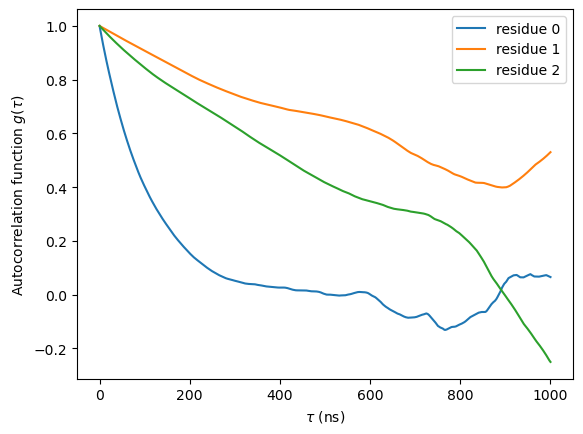

In [10]:
ns_per_step = 0.01
max_tau_res0 = result_res0.shape[0]
max_tau_res1 = result_res1.shape[0]
max_tau_res2 = result_res2.shape[0]

plt.figure()
plt.plot(np.arange(max_tau_res0)*ns_per_step, result_res0, label='residue 0')
plt.plot(np.arange(max_tau_res1)*ns_per_step, result_res1, label='residue 1')
plt.plot(np.arange(max_tau_res2)*ns_per_step, result_res2, label='residue 2')
plt.xlabel(r'$\tau$ (ns)')
plt.ylabel(r'Autocorrelation function $g(\tau)$')
plt.legend(loc='best')

plt.savefig('autocorrel_res012_1us.pdf')

In [ ]:
# Save the autocorrel functions!
Data_autocorrel = Data([result_res0, result_res1, result_res2])
Data_autocorrel.save('autocorrel_res012_1us.pkl')

In [ ]:
2*55078 -1